In [1]:
from valurap import gcode, asg, path_planning as pp
import logging
import pandas as pd
import numpy as np
import numpy
import matplotlib.pyplot as plt
import IPython
import time
from IPython.display import display
import os
import pickle
from pprint import pprint

import imp
imp.reload(pp)
imp.reload(gcode)
imp.reload(asg)

fn = "esk_handle"
lines = gcode.reader(fn + ".gcode")
pg = gcode.path_gen(lines)
sg = gcode.gen_segments(pg)

sk = 25

for i, s in enumerate(sg):
    if isinstance(s, gcode.do_move):
        print(i, s)
    elif isinstance(s, gcode.do_ext):
        print(i, s)
    elif isinstance(s, gcode.do_home):
        print(i, s)
    elif isinstance(s, gcode.do_segment):
        print("segment", i, len(s.path))
        sk -= 1
        if sk == 0:
            break
    else:
        assert (False)
        
print("start")
pprint(s.path[0])
pprint(s.path[1])
pprint(s.path[2])
last_k = len(s.path) - 1
print("end")
pprint(s.path[last_k - 2])
pprint(s.path[last_k - 1])
pprint(s.path[last_k])


Do Home
do_home
0 do_home(cur_pos={'X': 158.75, 'Y': -250.0, 'Z': 12.5, 'E': 0.0})
Set current ['E0']
Set current ['E0']
Set current ['E0']
Set current ['E0']
1 do_ext(deltas={'E': -3.0, 'F': 200.0, 'line': 22})
2 do_ext(deltas={'E': 1.0, 'F': 600.0, 'line': 26})
3 do_move(deltas={'X': -157.546, 'Y': 209.844, 'Z': -12.2, 'F': 4500.0, 'line': 30}, target={'X': 1.2040000000000077, 'Y': -40.156000000000006, 'Z': 0.3000000000000007})
4 do_ext(deltas={'E': -1.0, 'F': 600.0, 'line': 32})
segment 5 717
6 do_ext(deltas={'E': 1.0, 'F': 600.0, 'line': 748})
segment 7 4
8 do_ext(deltas={'E': -1.0, 'F': 600.0, 'line': 752})
segment 9 62
10 do_ext(deltas={'E': 1.0, 'F': 600.0, 'line': 813})
segment 11 7
12 do_ext(deltas={'E': -1.0, 'F': 600.0, 'line': 819})
segment 13 49
14 do_ext(deltas={'E': 1.0, 'F': 600.0, 'line': 867})
segment 15 8
16 do_ext(deltas={'E': -1.0, 'F': 600.0, 'line': 874})
segment 17 5
18 do_ext(deltas={'E': 1.0, 'F': 600.0, 'line': 878})
segment 19 6
20 do_ext(deltas={'E': -1.0, 

In [13]:
from math import sqrt, ceil, hypot
from valurap.asg import ProfileSegment
from valurap.emulate import emulate

import valurap.path_planning2 as pp2
imp.reload(pp2)

if 1:
    gcode_path = s.path
else:
    gcode_path = [
        #    X      Y     F    E  Line
        (  0.00,  0.00,   0,   0.0,    1),
        (  0.00,  1.00, 100,   0.0,    2),
        (  1.00,  1.00, 100,   0.0,    3),
        (  1.00,  2.00, 100,   1.0,    4),
        ( 10.00, 10.00, 100,  11.0,    5),
        ( 10.00, 15.00, 100,  15.0,    6),
        ( 10.00, 15.00,   0,   0.0,    7),
    ]

class LP(pp2.PathPlanner):
    pass

planner = LP()
planner.max_seg = 10.0
planner.emu_in_loop = True

t0 = time.time()
path, slowdowns = planner.make_path(gcode_path, 1.0)
display(path)


recheck = False
# process slowdowns to match max corner error
print("!!!!! corners pass !!!!!!")
slowdowns, updated, cc = planner.process_corner_errors(path, slowdowns)
if recheck:
    print("!!!!! corners pass 2 !!!!!!")
    slowdowns, updated, cc = planner.process_corner_errors(path, slowdowns)
    #display(cc)
    #display(path)



print("!!!!! reverse pass !!!!!!")
slowdowns, updated = planner.reverse_pass(path, slowdowns)
if recheck:
    print("!!!!! reverse pass 2 !!!!!!")
    slowdowns, updated = planner.reverse_pass(path, slowdowns)
print("!!!!! forward pass !!!!!!")
slowdowns, updated = planner.forward_pass(path, slowdowns)
if recheck:
    print("!!!!! forward pass 2 !!!!!!")
    slowdowns, updated = planner.forward_pass(path, slowdowns)
    print("!!!!! reverse pass 3 !!!!!!")
    slowdowns, updated = planner.reverse_pass(path, slowdowns)
    print("!!!!! forward pass 3 !!!!!!")
    slowdowns, updated = planner.forward_pass(path, slowdowns)
    print("!!!!! reverse pass 4 !!!!!!")
    slowdowns, updated = planner.reverse_pass(path, slowdowns)
    print("!!!!! forward pass 4 !!!!!!")
    slowdowns, updated = planner.forward_pass(path, slowdowns)
    print("=====")

t1 = time.time()
print("time:", t1 - t0)
if 0:
    speeds = planner.gen_speeds(path, slowdowns)
    cc_slowdowns, updated, cc = planner.process_corner_errors(path, slowdowns)

    display(path)
    display(speeds)
    display(cc)
    #display(slowdowns[slowdowns["corner"]<1])

segments, profile = planner.gen_segments_float(path, slowdowns)
display(segments)
display(profile)
#segments = planner.gen_segments(path, slowdowns, add_reset = False)


x        y     v           e  line  src_idx       dx     dy  \
idx                                                                       
0     51.4730   77.579  50.0 -130.006005  1123        1   0.0000  9.700   
1     51.4730   87.279  50.0 -130.489940  1123        2   0.0000  9.700   
2     51.4730   96.979  50.0 -130.973875  1123        3   0.0000  9.700   
3     51.4730  106.679  50.0 -131.457810  1123        4   0.0000  9.700   
4     31.7130  106.679  50.0 -132.443642  1124        5 -19.7600  0.000   
5     11.9530  106.679  50.0 -133.429474  1124        6 -19.7600  0.000   
6     -7.8070  106.679  50.0 -134.415306  1124        7 -19.7600  0.000   
7    -27.5670  106.679  50.0 -135.401138  1124        8 -19.7600  0.000   
8    -47.3270  106.679  50.0 -136.386970  1124        9 -19.7600  0.000   
9    -47.3270   96.979  50.0 -136.870905  1125       10   0.0000 -9.700   
10   -47.3270   87.279  50.0 -137.354840  1125       11   0.0000 -9.700   
11   -47.3270   77.579  50.0 -137.838775  1125       12   0.0000 -9.700   
12   -47.3270   67.879  50.0 -138.322710  1125       13   0.0000 -9.700   
13   -27.5670   67.879  50.0 -139.308540  1126       14  19.7600  0.000   
14    -7.8070   67.879  50.0 -140.294370  1126       15  19.7600  0.000   
15    11.9530   67.879  50.0 -141.280200  1126       16  19.7600  0.000   
16    31.7130   67.879  50.0 -142.266030  1126       17  19.7600  0.000   
17    51.4730   67.879  50.0 -143.251860  1126       18  19.7600  0.000   
18    31.7270   75.625  75.0 -143.251860  1128       19 -19.7460  7.746   
19    11.9810   83.371  75.0 -143.251860  1128       20 -19.7460  7.746   
20    -7.7650   91.117  75.0 -143.251860  1128       21 -19.7460  7.746   
21   -27.5110   98.863  75.0 -143.251860  1128       22 -19.7460  7.746   
22   -47.2570  106.609  75.0 -143.251860  1128       23 -19.7460  7.746   
23   -47.7270  107.079  75.0 -143.251860  1129       24  -0.4700  0.470   
24   -47.7270   97.179  50.0 -143.745773  1131       25   0.0000 -9.900   
25   -47.7270   87.279  50.0 -144.239685  1131       26   0.0000 -9.900   
26   -47.7270   77.379  50.0 -144.733598  1131       27   0.0000 -9.900   
27   -47.7270   67.479  50.0 -145.227510  1131       28   0.0000 -9.900   
28   -27.8070   67.479  50.0 -146.221322  1132       29  19.9200  0.000   
29    -7.8870   67.479  50.0 -147.215134  1132       30  19.9200  0.000   
...       ...      ...   ...         ...   ...      ...      ...    ...   
1217  46.9475   72.403  50.0 -625.537850  1593     1218  -3.9555 -3.956   
1218  42.9920   68.447  50.0 -625.816950  1593     1219  -3.9555 -3.956   
1219  43.5570   68.447  75.0 -625.816950  1594     1220   0.5650  0.000   
1220  47.2300   72.120  50.0 -626.076100  1595     1221   3.6730  3.673   
1221  50.9030   75.793  50.0 -626.335250  1595     1222   3.6730  3.673   
1222  50.9030   75.227  75.0 -626.335250  1596     1223   0.0000 -0.566   
1223  44.1230   68.447  50.0 -626.813610  1597     1224  -6.7800 -6.780   
1224  44.6890   68.447  75.0 -626.813610  1598     1225   0.5660  0.000   
1225  50.9030   74.661  50.0 -627.252040  1599     1226   6.2140  6.214   
1226  50.9030   74.096  75.0 -627.252040  1600     1227   0.0000 -0.565   
1227  45.2540   68.447  50.0 -627.650610  1601     1228  -5.6490 -5.649   
1228  45.8200   68.447  75.0 -627.650610  1602     1229   0.5660  0.000   
1229  50.9030   73.530  50.0 -628.009240  1603     1230   5.0830  5.083   
1230  50.9030   72.964  75.0 -628.009240  1604     1231   0.0000 -0.566   
1231  46.3860   68.447  50.0 -628.327940  1605     1232  -4.5170 -4.517   
1232  46.9510   68.447  75.0 -628.327940  1606     1233   0.5650  0.000   
1233  50.9030   72.399  50.0 -628.606780  1607     1234   3.9520  3.952   
1234  50.9030   71.833  75.0 -628.606780  1608     1235   0.0000 -0.566   
1235  47.5170   68.447  50.0 -628.845680  1609     1236  -3.3860 -3.386   
1236  48.0830   68.447  75.0 -628.845680  1610     1237   0.5660  0.000   
1237  50.9030   71.267  50.0 -629.044

!!!!! corners pass !!!!!!
cc updated 494
!!!!! reverse pass !!!!!!
accelerating segment, skipping 1245 21.220505503645548 32.73550648285997
accelerating segment, skipping 1244 18.75876817911967 31.83075825546832
no correction needed 1243 0.10404157547178795 1.2369036396604969
accelerating segment, skipping 1242 18.758768179119695 31.84349094353271
no correction needed 1241 0.10404157547178637 2.037348515963674
accelerating segment, skipping 1240 18.758768179119684 31.84349094353258
no correction needed 1239 0.10374430686763808 2.8381267256001768
accelerating segment, skipping 1238 18.75876817911969 31.813772326751796
no correction needed 1237 0.10404157547178614 3.636824055007645
accelerating segment, skipping 1236 18.758768179119684 31.84349094353256
no correction needed 1235 0.10404157547178797 4.437268931310814
accelerating segment, skipping 1234 18.758768179119684 31.843490943532753
no correction needed 1233 0.10374430686763808 5.238047140947323
accelerating segment, skipping 1232 

no correction needed 1066 0.0 8.157749513192961
no correction needed 1065 0.7248447732637165 7.979416179859627
accelerating segment, skipping 1064 18.758850762292578 31.8137723267519
no correction needed 1063 0.8286026812057915 8.145104964609803
no correction needed 1062 0.0 8.317697068299614
no correction needed 1061 0.0 8.317697068299623
no correction needed 1060 0.0 8.317697068299607
no correction needed 1059 0.7248546857624828 8.139363734966283
accelerating segment, skipping 1058 18.758768179119684 31.814013521927563
no correction needed 1057 0.8285890801313561 8.305053096783944
no correction needed 1056 0.0 8.47764462100175
no correction needed 1055 0.0 8.47764462100175
no correction needed 1054 0.0 8.47764462100175
no correction needed 1053 0.7245475046595692 8.29897795433509
accelerating segment, skipping 1052 18.758768179119684 31.843490943532647
no correction needed 1051 0.8285890801313559 8.465142072044577
no correction needed 1050 0.0 8.637733596262384
no correction needed 1

accelerating segment, skipping 848 18.758832664651827 31.843302429395553
no correction needed 847 0.8285997006613929 10.479405997387413
no correction needed 846 0.0 10.651997974089182
no correction needed 845 0.0 10.65199797408917
no correction needed 844 0.0 10.651997974089182
no correction needed 843 0.8285997006613929 10.479405997387413
Calculated k: 0.7644534995326765
842: correction results: total: 0.5649999999999977 free: 0.0386120349473455: new free: 0.047901533882134875 target: 0.27611203494734426 final: 0.25821050106520943
no correction needed 841 0.7946234269480403 10.552050285095726
no correction needed 840 0.0 10.652139394506627
no correction needed 839 0.0 10.652139394506618
no correction needed 838 0.0 10.652139394506627
no correction needed 837 0.724844773263717 10.473806061173297
accelerating segment, skipping 836 18.758832664651827 31.813772326751856
no correction needed 835 0.8285997006613929 10.479405997387413
no correction needed 834 0.0 10.651997974089182
no correc

no correction needed 640 0.0 10.651856555549365
no correction needed 639 0.8286103213078608 10.479264126342063
Calculated k: 0.7645906957951544
638: correction results: total: 0.565999999999999 free: 0.03911135618904005: new free: 0.04794115490874576 target: 0.2771113561890396 final: 0.2591702012802938
no correction needed 637 0.7944476968464146 10.55154436737916
no correction needed 636 0.0 10.651856555549367
no correction needed 635 0.0 10.651856555549356
no correction needed 634 0.0 10.651856555549369
no correction needed 633 0.7245705167924759 10.473189888882702
accelerating segment, skipping 632 18.758832664651827 31.843113911098094
no correction needed 631 0.8285997006613929 10.479405997387413
no correction needed 630 0.0 10.651997974089182
no correction needed 629 0.0 10.65199797408917
no correction needed 628 0.0 10.65199797408918
no correction needed 627 0.8285997006613929 10.479405997387413
Calculated k: 0.7645902477538818
626: correction results: total: 0.565999999999999 fre

no correction needed 433 0.7946343421715526 10.55190808941435
no correction needed 432 0.0 10.651997974089182
no correction needed 431 0.0 10.65199797408917
no correction needed 430 0.0 10.651997974089182
no correction needed 429 0.7245590106218892 10.473331307422514
accelerating segment, skipping 428 18.758832664651827 31.843302429395624
no correction needed 427 0.8285997006613928 10.479405997387415
no correction needed 426 0.0 10.65199797408918
no correction needed 425 0.0 10.65199797408917
no correction needed 424 0.0 10.651997974089182
no correction needed 423 0.8285997006613929 10.479405997387413
Calculated k: 0.7644534995326766
422: correction results: total: 0.565 free: 0.03861203494734655: new free: 0.04790153388213503 target: 0.2761120349473465 final: 0.2582105010652115
no correction needed 421 0.7946234269480397 10.55205028509573
no correction needed 420 0.0 10.652139394506628
no correction needed 419 0.0 10.652139394506616
no correction needed 418 0.0 10.652139394506628
no c

no correction needed 217 0.828605469537263 9.073360623172688
Calculated k: 0.7645832322448646
216: correction results: total: 0.5660000000000025 free: 0.03911369107414636: new free: 0.047941082579283104 target: 0.27711369107414763 final: 0.25917260849486456
no correction needed 215 0.7944262305128216 8.945706821934118
no correction needed 214 0.0 9.046017051719492
no correction needed 213 0.0 9.046017051719502
no correction needed 212 0.828589080131356 8.873425527501691
Calculated k: 0.7645838774009328
211: correction results: total: 0.565999999999999 free: 0.039112713673279675: new free: 0.047941112856701176 target: 0.27711271367327917 final: 0.259171600816578
no correction needed 210 0.7944260795445378 8.745595433574511
no correction needed 209 0.0 8.845905832643716
no correction needed 208 0.0 8.845905832643712
no correction needed 207 0.8285890801313561 8.673314308425894
Calculated k: 0.7644484911879901
206: correction results: total: 0.5650000000000119 free: 0.03861271367328606: n

no correction needed 73 0.03397110016542343 3.9112744757463576
Calculated k: 0.764458766232865
72: correction results: total: 0.5649999999999977 free: 0.03860407269735722: new free: 0.047901780548117265 target: 0.27610407269735604 final: 0.2582022921492388
no correction needed 71 0.03396688310126212 3.111531041998091
Calculated k: 0.7645838774009331
70: correction results: total: 0.5660000000000025 free: 0.03911271367328145: new free: 0.04794111285670148 target: 0.2771127136732827 final: 0.25917160081658125
no correction needed 69 0.034163000586818745 2.310866255168633
Calculated k: 0.7646722796764162
68: correction results: total: 0.5659999999999954 free: 0.03911271367327801: new free: 0.04794111285670115 target: 0.2771127136732756 final: 0.25917160081657453
no correction needed 67 0.034176948280817104 1.511118932310739
Calculated k: 0.7645705084875845
66: correction results: total: 0.5660000000000025 free: 0.03913296957575635: new free: 0.047940485453761644 target: 0.2771329695757576

no correction needed 78 0.10871308852206621 0.15665403131703132
no correction needed 79 0.034166781482427064 6.310966728864731
no correction needed 80 0.1086965740395915 0.15663768689629318
no correction needed 81 0.034163000586818745 7.110707085862926
no correction needed 82 0.10870600221278788 0.15664711506948945
no correction needed 83 0.03396616990940161 7.9113726724089215
no correction needed 84 0.10807251891500459 0.15597415642905083
no correction needed 85 0.033968134307948955 8.711113080089257
no correction needed 86 0.10808460707737579 0.15598611993407724
no correction needed 87 0.0341630005868188 9.510627501210067
no correction needed 88 0.10870600221278799 0.15664711506948933
no correction needed 89 0.8285890801313565 5.1193956261823095
no correction needed 90 0.7944265699922576 5.191677301279938
no correction needed 91 0.10871010080369553 0.1566511152987388
no correction needed 92 0.8286423255108543 5.519266638794399
no correction needed 93 0.7944771380742367 5.591542011858

no correction needed 301 0.794426079544537 9.536423657653549
no correction needed 302 0.10870600221278688 0.1566471150694881
no correction needed 303 0.828589080131356 9.624231507765568
no correction needed 304 0.0 9.79682303198337
no correction needed 305 0.0 9.796823031983381
no correction needed 306 0.0 9.796823031983372
no correction needed 307 0.7944261916976119 9.696512758673709
no correction needed 308 0.10870693944671903 0.15664802981058
no correction needed 309 0.8286012556462266 9.78417954674217
no correction needed 310 0.0 9.956770586892114
no correction needed 311 0.0 9.956770586892127
no correction needed 312 0.0 9.956770586892116
no correction needed 313 0.7944377549756491 9.85645935659262
no correction needed 314 0.10870475536733899 0.15664586822404036
no correction needed 315 0.8285890801313557 9.944126615574358
no correction needed 316 0.0 10.11671813979217
no correction needed 317 0.0 10.116718139792175
no correction needed 318 0.0 10.116718139792173
no correction nee

no correction needed 483 0.8286103213078608 10.479264126342063
no correction needed 484 0.0 10.651856555549367
no correction needed 485 0.0 10.651856555549355
no correction needed 486 0.0 10.651856555549363
no correction needed 487 0.8286103213078606 10.479264126342065
Calculated k: 0.7644569091086921
488: correction results: total: 0.5649999999999977 free: 0.03861135618903955: new free: 0.047901554908745675 target: 0.2761113561890385 final: 0.2582098012802928
no correction needed 489 0.7946342373283832 10.55190797185174
no correction needed 490 0.0 10.651997974089182
no correction needed 491 0.0 10.65199797408917
no correction needed 492 0.0 10.651997974089182
no correction needed 493 0.7944368881187056 10.551686680485973
no correction needed 494 0.10870396066039922 0.15664509454253425
no correction needed 495 0.8285997006613929 10.479405997387413
no correction needed 496 0.0 10.65199797408918
no correction needed 497 0.0 10.651997974089172
no correction needed 498 0.0 10.651997974089

no correction needed 652 0.0 10.651856555549365
no correction needed 653 0.0 10.651856555549356
no correction needed 654 0.0 10.651856555549363
no correction needed 655 0.8286103213078608 10.479264126342063
Calculated k: 0.7645906957951544
656: correction results: total: 0.565999999999999 free: 0.03911135618904005: new free: 0.04794115490874576 target: 0.2771113561890396 final: 0.2591702012802938
no correction needed 657 0.7944476968464146 10.55154436737916
no correction needed 658 0.0 10.651856555549365
no correction needed 659 0.0 10.651856555549356
no correction needed 660 0.0 10.651856555549363
no correction needed 661 0.7944478016905466 10.551544484942681
no correction needed 662 0.10870279515518196 0.15664392903731722
no correction needed 663 0.8285997006613929 10.479405997387413
no correction needed 664 0.0 10.65199797408918
no correction needed 665 0.0 10.651997974089173
no correction needed 666 0.0 10.65199797408918
no correction needed 667 0.8285997006613929 10.47940599738741

no correction needed 810 0.0 10.651856555549363
no correction needed 811 0.8286103213078608 10.479264126342063
Calculated k: 0.7644569091086924
812: correction results: total: 0.565 free: 0.0386113561890406: new free: 0.047901554908745814 target: 0.2761113561890406 final: 0.25820980128029475
no correction needed 813 0.7946342373283825 10.551907971851739
no correction needed 814 0.0 10.65199797408918
no correction needed 815 0.0 10.651997974089172
no correction needed 816 0.0 10.65199797408918
no correction needed 817 0.7944368881187053 10.551686680485972
no correction needed 818 0.10870396066040092 0.15664509454253597
no correction needed 819 0.8285997006613929 10.479405997387413
no correction needed 820 0.0 10.65199797408918
no correction needed 821 0.0 10.651997974089172
no correction needed 822 0.0 10.65199797408918
no correction needed 823 0.8285997006613929 10.479405997387413
Calculated k: 0.764590247753882
824: correction results: total: 0.5660000000000001 free: 0.039112034947346

no correction needed 934 0.0 10.65213939450663
no correction needed 935 0.0 10.65213939450662
no correction needed 936 0.0 10.652139394506623
no correction needed 937 0.7946234269480403 10.552050285095726
no correction needed 938 0.10807683694886099 0.15597837083099583
no correction needed 939 0.8285997006613931 10.479405997387412
no correction needed 940 0.0 10.651997974089184
no correction needed 941 0.0 10.65199797408917
no correction needed 942 0.0 10.651997974089182
no correction needed 943 0.8285997006613929 10.479405997387413
Calculated k: 0.7645872865427854
944: correction results: total: 0.565999999999999 free: 0.03911203494734594: new free: 0.04794113388213489 target: 0.2771120349473455 final: 0.2591709010652106
no correction needed 945 0.7944368881187058 10.551686680485975
no correction needed 946 0.0 10.65199797408918
no correction needed 947 0.0 10.65199797408917
no correction needed 948 0.0 10.651997974089184
no correction needed 949 0.7944369929560066 10.551686798042006


no correction needed 1150 0.8285890801313559 8.890160387989772
Calculated k: 0.7645898538524728
1151: correction results: total: 0.565999999999999 free: 0.03911271367327973: new free: 0.047941112856701246 target: 0.27711271367327917 final: 0.259171600816578
no correction needed 1152 0.7944481059691276 8.695860691608978
no correction needed 1153 0.0 8.79617265885819
no correction needed 1154 0.8286120499840122 8.623582047860369
Calculated k: 0.7645829732149583
1155: correction results: total: 0.5660000000000025 free: 0.03911408350326001: new free: 0.04794107042291909 target: 0.2771140835032613 final: 0.25917301308034213
no correction needed 1156 0.7944262911264921 8.429283237374886
no correction needed 1157 0.0 8.529593399192915
no correction needed 1158 0.8285890801313556 8.357001874975118
Calculated k: 0.7645838774009331
1159: correction results: total: 0.5660000000000025 free: 0.03911271367328145: new free: 0.04794111285670148 target: 0.2771127136732827 final: 0.25917160081658125
no 

l1, l2, l, fl 2.7916378587597695e-06 0 9.68787526679435 9.68787247515649
dt1, dt2 5.583278834819794e-08 0.0
long plato
l1, l2, l, fl 1.8610919058398463e-06 0 9.68787526679435 9.687873405702444
dt1, dt2 3.7221858898798626e-08 0.0
plato accel: x: (51.47299999999814, 87.29112473320565) -> (51.472999999999985, 87.2790018610919) v: (0.0, 49.99994416721165) -> (0.0, 50.0)
e: -130.49061738214596 -> -130.48994009285036 (-2.4945103092783625)
testing:  [[1, [<ProfileSegment apg=X a=0 j=0 jj=0 target_v=0.0>, <ProfileSegment apg=Y a=25145 j=0 jj=0 target_v=343597.0>, <ProfileSegment apg=Z a=20650 j=0 jj=0 target_v=-179350.0>]]]
int_v: 0 0.0 343597 343597.0 -179350 -179350.0
int_j: 0 0 0
[[1, [<ProfileSegment apg=X a=0 j=0 jj=0 target_v=0.0>, <ProfileSegment apg=Y a=25145 j=0 jj=0 target_v=343597.0>, <ProfileSegment apg=Z a=20650 j=0 jj=0 target_v=-179350.0>]]]
last_x 51.47299999999814 last_y 87.29612472762237 last_e -130.49086683361514 last_vx 0.0 last_vy 49.99994416721165 last_ve -2.4945146917157

int_v: -343597 -343597.0 0 0.0 -179350 -179350.0
int_j: 0 0 0
[[3951, [<ProfileSegment apg=X a=-6 j=0 jj=0 target_v=-343597.0>, <ProfileSegment apg=Y a=0 j=0 jj=0 target_v=0.0>, <ProfileSegment apg=Z a=1 j=0 jj=0 target_v=-179350.0>]]]
last_x 11.946672021178529 last_y 106.69201483488432 last_e -133.430552151275 last_vx -49.99994416721165 last_vy 0.0 last_ve -2.494514691715742
d_x -0.0063279788214600785 d_y 0.013014834884316429 d_e -0.0010781512748962996 d_vx 5.583278834819794e-05 d_vy 0.0 d_ve -5.216752150261073e-07
======== 6 L1124.0 T1.6140 =========
e: -133.430552151275 -> -133.4294740000001 v_to_ve: -0.049890283400809116
corner: x: (11.946672021178529, 106.69201483488432) -> (11.952999999999989, 106.679) v: (-49.99994416721165, 0.0) -> (-50.0, 0.0)
corner_0 (5.583278834819794e-08 5.583278834819794e-08): x: (11.946672021178529, 106.69201483488432) -> (11.946669229540671, 106.69201483488432) v: (-49.99994416721165, 0.0) -> (-50.0, 0.0)
testing:  [[1, [<ProfileSegment apg=X a=-25145 j

int_v: -163522 0.0 0 -163443.0 -85375 -85314.0
int_j: 0 0 0
[[238, [<ProfileSegment apg=X a=45027638 j=0 jj=0 target_v=0.0>, <ProfileSegment apg=Y a=-45005989 j=0 jj=0 target_v=-163443.0>, <ProfileSegment apg=Z a=16916 j=0 jj=0 target_v=-85314.0>]]]
last_x -47.33966870070435 last_y 106.41006476890179 last_e -136.40244410848 last_vx -0.0023283064365386963 last_vy -23.784086806699634 last_ve -1.1874501912753357
d_x -0.0012699242617273399 d_y 0.0010286979660634188 d_e -1.541098743018665e-05 d_vx -0.0023283064365386963 d_vy 5.5493354789604155e-05 d_ve -0.0008544279787487952
plato: x: (-47.33966870070435, 106.41006476890179) -> (-47.32700000000001, 96.979) v: (-0.0023283064365386963, -23.784086806699634) -> (0.0, -50.0) -> (0.0, -50.0)
l1, l2, l, fl 0.9671586078672173 0 9.43107327779814 8.463914669930922
dt1, dt2 0.026215913193300366 0.0
long plato
l1, l2, l, fl 0.6447724052448116 0 9.43107327779814 8.786300872553328
dt1, dt2 0.017477275462200244 0.0
plato accel: x: (-47.33966870070435, 106

int_v: 343518 343597.0 -16 0.0 -179350 -179350.0
int_j: 0 0 0
[[3770, [<ProfileSegment apg=X a=1380 j=0 jj=0 target_v=343597.0>, <ProfileSegment apg=Y a=278 j=0 jj=0 target_v=0.0>, <ProfileSegment apg=Z a=7 j=0 jj=0 target_v=-179350.0>]]]
last_x -27.56895901937969 last_y 67.86836062911316 last_e -139.31191839834813 last_vx 49.98844815418124 last_vy -0.0023283064365386963 last_ve -2.494514691715742
d_x -0.001959019379675908 d_y -0.01063937088684952 d_e -0.003378398348019118 d_vx -0.01155184581875801 d_vy -0.0023283064365386963 d_ve -5.582404019044418e-06
======== 14 L1126.0 T4.0150 =========
e: -139.31191839834813 -> -139.3085400000001 v_to_ve: -0.049890182186234464
corner: x: (-27.56895901937969, 67.86836062911316) -> (-27.567000000000014, 67.879) v: (49.98844815418124, -0.0023283064365386963) -> (50.0, 0.0)
corner_0 (1.1551845818758012e-05 1.1551845818758012e-05): x: (-27.56895901937969, 67.86836062911316) -> (-27.568381493811323, 67.86836061566504) v: (49.98844815418124, -0.002328306

last_x 31.720973624498583 last_y 67.86836039628251 last_e -142.26991391978467 last_vx 49.99994416721165 last_vy 0.0 last_ve -2.494514691715742
d_x 0.007973624498603726 d_y -0.010639603717493173 d_e -0.0038839197845561557 d_vx -5.583278834819794e-05 d_vy 0.0 d_ve -5.582404019044418e-06
======== 17 L1126.0 T5.2008 =========
e: -142.26991391978467 -> -142.26603000000011 v_to_ve: -0.04989018218623444
corner: x: (31.720973624498583, 67.86836039628251) -> (31.71299999999998, 67.879) v: (49.99994416721165, 0.0) -> (50.0, 0.0)
corner_0 (5.583278834819794e-08 5.583278834819794e-08): x: (31.720973624498583, 67.86836039628251) -> (31.720976416136445, 67.86836039628251) v: (49.99994416721165, 0.0) -> (50.0, 0.0)
testing:  [[1, [<ProfileSegment apg=X a=25145 j=0 jj=0 target_v=343597.0>, <ProfileSegment apg=Y a=0 j=0 jj=0 target_v=0.0>, <ProfileSegment apg=Z a=26304 j=0 jj=0 target_v=-179350.0>]]]
int_v: 343597 343597.0 0 0.0 -179350 -179350.0
int_j: 0 0 0
[[1, [<ProfileSegment apg=X a=25145 j=0 jj=

testing:  [[1, [<ProfileSegment apg=X a=31058 j=0 jj=0 target_v=-479800.0>, <ProfileSegment apg=Y a=46443 j=0 jj=0 target_v=188217.0>, <ProfileSegment apg=Z a=0 j=0 jj=0 target_v=0.0>]]]
int_v: -479800 -479800.0 188216 188217.0 0 0.0
int_j: 0 0 0
[[1, [<ProfileSegment apg=X a=31058 j=0 jj=0 target_v=-479800.0>, <ProfileSegment apg=Y a=46443 j=0 jj=0 target_v=188217.0>, <ProfileSegment apg=Z a=0 j=0 jj=0 target_v=0.0>]]]
last_x 11.951441600569524 last_y 83.37059867863427 last_e -143.25669081194724 last_vx -69.82008926570415 last_vy 27.389032766222954 last_ve 0.0
d_x -0.029553599384724905 d_y -0.0004032043371751115 d_e -0.004830811947130087 d_vx -6.896186836513607e-05 d_vy -0.0001031232489374645 d_ve 0.0
plato feed: x: (11.951441600569524, 83.37059867863427) -> (-7.765, 91.11699999999999) v: (-69.82008926570415, 27.389032766222954) -> (-69.82002030383579, 27.38913588947189)
e: -143.25669081194724 -> -143.2518600000001 (0.0)
testing:  [[2826, [<ProfileSegment apg=X a=11 j=0 jj=0 target_v=

d_x -0.017872586452391204 d_y -0.0096100441938205 d_e -0.004915307280725756 d_vx -0.005820766091346741 d_vy 5.583278834819794e-05 d_ve 6.792682402334549e-06
plato feed: x: (-47.7448725864524, 106.11930222312803) -> (-47.72700000000001, 97.179) v: (-0.005820766091346741, -49.99994416721165) -> (0.0, -50.0)
e: -143.30417532821684 -> -143.7457725000001 (-2.494507575757544)
testing:  [[1789, [<ProfileSegment apg=X a=1465 j=0 jj=0 target_v=0.0>, <ProfileSegment apg=Y a=-14 j=0 jj=0 target_v=-343597.0>, <ProfileSegment apg=Z a=-18 j=0 jj=0 target_v=-179349.0>]]]
int_v: -40 0.0 -343597 -343597.0 -179349 -179349.0
int_j: 0 0 0
[[1789, [<ProfileSegment apg=X a=1465 j=0 jj=0 target_v=0.0>, <ProfileSegment apg=Y a=-14 j=0 jj=0 target_v=-343597.0>, <ProfileSegment apg=Z a=-18 j=0 jj=0 target_v=-179349.0>]]]
last_x -47.745913921506144 last_y 97.17431221161387 last_e -143.750441518309 last_vx -0.005820766091346741 last_vy -49.99994416721165 last_ve -2.4945007830751416
d_x -0.018913921506133136 d_y -

testing:  [[3803, [<ProfileSegment apg=X a=1368 j=0 jj=0 target_v=343597.0>, <ProfileSegment apg=Y a=276 j=0 jj=0 target_v=0.0>, <ProfileSegment apg=Z a=118925 j=-63 jj=0 target_v=-179350.0>]]]
int_v: 343518 343597.0 -16 0.0 -179350 -179350.0
int_j: 0 0 -63.0
[[3803, [<ProfileSegment apg=X a=1368 j=0 jj=0 target_v=343597.0>, <ProfileSegment apg=Y a=276 j=0 jj=0 target_v=0.0>, <ProfileSegment apg=Z a=118925 j=-63 jj=0 target_v=-179350.0>]]]
last_x -27.809792648884468 last_y 67.46701225875294 last_e -146.22740671431018 last_vx 49.98844815418124 last_vy -0.0023283064365386963 last_ve -2.494514691715742
d_x -0.0027926488844549624 d_y -0.011987741247054373 d_e -0.006084714310077288 d_vx -0.01155184581875801 d_vy -0.0023283064365386963 d_ve -6.659587249657761e-06
======== 29 L1132.0 T8.3260 =========
e: -146.22740671431018 -> -146.2213220000001 v_to_ve: -0.04989016064257127
corner: x: (-27.809792648884468, 67.46701225875294) -> (-27.807000000000013, 67.479) v: (49.98844815418124, -0.00232830

======== 31 L1132.0 T9.1230 =========
e: -148.21553492360763 -> -148.2089460000001 v_to_ve: -0.04989016064257126
corner: x: (12.040161702781916, 67.4670120259223) -> (12.03299999999998, 67.479) v: (49.99994416721165, 0.0) -> (50.0, 0.0)
corner_0 (5.583278834819794e-08 5.583278834819794e-08): x: (12.040161702781916, 67.4670120259223) -> (12.040164494419773, 67.4670120259223) v: (49.99994416721165, 0.0) -> (50.0, 0.0)
testing:  [[1, [<ProfileSegment apg=X a=25145 j=0 jj=0 target_v=343597.0>, <ProfileSegment apg=Y a=0 j=0 jj=0 target_v=0.0>, <ProfileSegment apg=Z a=31379 j=0 jj=0 target_v=-179350.0>]]]
int_v: 343597 343597.0 0 0.0 -179350 -179350.0
int_j: 0 0 0
[[1, [<ProfileSegment apg=X a=25145 j=0 jj=0 target_v=343597.0>, <ProfileSegment apg=Y a=0 j=0 jj=0 target_v=0.0>, <ProfileSegment apg=Z a=31379 j=0 jj=0 target_v=-179350.0>]]]
last_x 12.045161697198637 last_y 67.4670120259223 last_e -148.2157843750768 last_vx 49.99994416721165 last_vy 0.0 last_ve -2.494514691715742
d_x 0.004997202

last_x 51.6040789084509 last_y 107.09132746506366 last_e -152.18835264639796 last_vx -23.784086806699634 last_vy 0.0 last_ve -1.1874501912753357
d_x 0.0008926464920904209 d_y 0.0012691474732378083 d_e -2.900402864725038e-05 d_vx 5.5493354789604155e-05 d_vy 0.0 d_ve -0.0008555111798798087
plato: x: (51.6040789084509, 107.09132746506366) -> (31.952999999999985, 107.079) v: (-23.784086806699634, 0.0) -> (-50.0, 0.0) -> (-50.0, 0.0)
l1, l2, l, fl 0.9671586073856882 0 19.65108277506762 18.683924167681933
dt1, dt2 0.026215913193300366 0.0
long plato
l1, l2, l, fl 0.6447724049237922 0 19.65108277506762 19.00631037014383
dt1, dt2 0.017477275462200244 0.0
plato accel: x: (51.6040789084509, 107.09132746506366) -> (50.94538488260157, 107.079) v: (-23.784086806699634, 0.0) -> (-50.0, 0.0)
e: -152.18835264639796 -> -152.2185088672216 (-2.4945080321284925)
testing:  [[175, [<ProfileSegment apg=X a=-67466273 j=0 jj=0 target_v=-343597.0>, <ProfileSegment apg=Y a=0 j=0 jj=0 target_v=0.0>, <ProfileSegme

int_v: -343597 -343597.0 0 0.0 -179350 -179350.0
int_j: 0 0 0
[[3982, [<ProfileSegment apg=X a=-6 j=0 jj=0 target_v=-343597.0>, <ProfileSegment apg=Y a=0 j=0 jj=0 target_v=0.0>, <ProfileSegment apg=Z a=8 j=0 jj=0 target_v=-179350.0>]]]
last_x -27.81525414274074 last_y 107.09132746506366 last_e -156.15061238269726 last_vx -49.99994416721165 last_vy 0.0 last_ve -2.494514691715742
d_x -0.008254142740732107 d_y 0.012327465063663112 d_e -0.003134382697140836 d_vx 5.583278834819794e-05 d_vy 0.0 d_ve -6.6595872501018505e-06
======== 41 L1134.0 T12.3498 =========
e: -156.15061238269726 -> -156.14747800000012 v_to_ve: -0.04989016064256984
corner: x: (-27.81525414274074, 107.09132746506366) -> (-27.80700000000001, 107.079) v: (-49.99994416721165, 0.0) -> (-50.0, 0.0)
corner_0 (5.583278834819794e-08 5.583278834819794e-08): x: (-27.81525414274074, 107.09132746506366) -> (-27.815256934378603, 107.09132746506366) v: (-49.99994416721165, 0.0) -> (-50.0, 0.0)
testing:  [[1, [<ProfileSegment apg=X a=-2

d_x -0.0035609032837555787 d_y -0.011494371006307347 d_e -0.0034207740782221663 d_vx 0.0 d_vy 5.583278834819794e-05 d_ve 1.3524714055357379e-06
plato feed: x: (-46.94056090328377, 96.7725037679018) -> (-46.93700000000001, 87.279) v: (0.0, -49.99994416721165) -> (0.0, -50.0)
e: -157.61891836692882 -> -158.0897050000001 (-2.4945160441871477)
testing:  [[1900, [<ProfileSegment apg=X a=0 j=0 jj=0 target_v=0.0>, <ProfileSegment apg=Y a=-13 j=0 jj=0 target_v=-343597.0>, <ProfileSegment apg=Z a=-3 j=0 jj=0 target_v=-179350.0>]]]
int_v: 0 0.0 -343597 -343597.0 -179350 -179350.0
int_j: 0 0 0
[[1900, [<ProfileSegment apg=X a=0 j=0 jj=0 target_v=0.0>, <ProfileSegment apg=Y a=-13 j=0 jj=0 target_v=-343597.0>, <ProfileSegment apg=Z a=-3 j=0 jj=0 target_v=-179350.0>]]]
last_x -46.94056090328377 last_y 87.27251437613158 last_e -158.0928761583548 last_vx 0.0 last_vy -49.99994416721165 last_ve -2.494514691715742
d_x -0.0035609032837555787 d_y -0.006485623868414336 d_e -0.003171158354717818 d_vx 0.0 d_v

testing:  [[1, [<ProfileSegment apg=X a=5202489 j=0 jj=0 target_v=343597.0>, <ProfileSegment apg=Y a=1048576 j=0 jj=0 target_v=0.0>, <ProfileSegment apg=Z a=-25633 j=0 jj=0 target_v=-179349.0>]]]
int_v: 343518 343597.0 -16 0.0 -179349 -179349.0
int_j: 0 0 0
[[1, [<ProfileSegment apg=X a=5202489 j=0 jj=0 target_v=343597.0>, <ProfileSegment apg=Y a=1048576 j=0 jj=0 target_v=0.0>, <ProfileSegment apg=Z a=-25633 j=0 jj=0 target_v=-179349.0>]]]
last_x -27.32936396158766 last_y 68.25521762021235 last_e -160.0202822150666 last_vx 49.99994416721165 last_vy 0.0 last_ve -2.4945007830751416
d_x 0.004421319247050803 d_y -2.1938252814379666e-07 d_e -0.0002206339584347461 d_vx -5.583278834819794e-05 d_vy 0.0 d_ve 5.440144625445953e-06
plato: x: (-27.32936396158766, 68.25521762021235) -> (-7.729000000000013, 68.269) v: (49.99994416721165, 0.0) -> (50.0, 0.0) -> (50.0, 0.0)
l1, l2, l, fl 2.7916378587597695e-06 0 19.600368807262186 19.600366015624328
dt1, dt2 5.583278834819794e-08 0.0
long plato
l1, l2

d_x 0.016568490044956974 d_y -0.013782379787656396 d_e -0.0047582935042669305 d_vx -5.583278834819794e-05 d_vy 0.0 d_ve 5.440144625445953e-06
plato feed: x: (31.49557035113685, 68.25521762021235) -> (50.155385762508445, 68.269) v: (49.99994416721165, 0.0) -> (50.0, 0.0)
e: -162.95506238635448 -> -163.88207121023672 (-2.494506223219767)
testing:  [[3733, [<ProfileSegment apg=X a=7 j=0 jj=0 target_v=343597.0>, <ProfileSegment apg=Y a=0 j=0 jj=0 target_v=0.0>, <ProfileSegment apg=Z a=-7 j=0 jj=0 target_v=-179349.0>]]]
int_v: 343597 343597.0 0 0.0 -179349 -179349.0
int_j: 0 0 0
[[3733, [<ProfileSegment apg=X a=7 j=0 jj=0 target_v=343597.0>, <ProfileSegment apg=Y a=0 j=0 jj=0 target_v=0.0>, <ProfileSegment apg=Z a=-7 j=0 jj=0 target_v=-179349.0>]]]
last_x 50.16054950875696 last_y 68.25521762021235 last_e -163.88625952867645 last_vx 49.99994416721165 last_vy 0.0 last_ve -2.4945007830751416
d_x 0.005163746248513235 d_y -0.013782379787656396 d_e -0.004188318439730665 d_vx -5.583278834819794e-0

last_x 51.09146023506764 last_y 96.79372449118527 last_e -165.35669605099298 last_vx 0.0 last_vy 49.99994416721165 last_ve -2.494514691715742
d_x 0.008460235067659028 d_y 0.00972449118526697 d_e -0.00572355099288302 d_vx 0.0 d_vy -5.583278834819794e-05 d_ve 1.3524715551938016e-06
======== 56 L1140.0 T16.1647 =========
e: -165.35669605099298 -> -165.3509725000001 v_to_ve: -0.049890320883746016
corner: x: (51.09146023506764, 96.79372449118527) -> (51.082999999999984, 96.784) v: (0.0, 49.99994416721165) -> (0.0, 50.0)
corner_0 (5.583278834819794e-08 5.583278834819794e-08): x: (51.09146023506764, 96.79372449118527) -> (51.09146023506764, 96.79372728282314) v: (0.0, 49.99994416721165) -> (0.0, 50.0)
testing:  [[1, [<ProfileSegment apg=X a=0 j=0 jj=0 target_v=0.0>, <ProfileSegment apg=Y a=25145 j=0 jj=0 target_v=343597.0>, <ProfileSegment apg=Z a=-6373 j=0 jj=0 target_v=-179350.0>]]]
int_v: 0 0.0 343597 343597.0 -179350 -179350.0
int_j: 0 0 0
[[1, [<ProfileSegment apg=X a=0 j=0 jj=0 target_v

last_x 11.860131926834583 last_y 106.29962564217276 last_e -167.782735425659 last_vx -49.99994416721165 last_vy 0.0 last_ve -2.494514691715742
d_x -0.004997202778863397 d_y 0.0 d_e -0.00024931219357426926 d_vx 5.583278834819794e-05 d_vy 0.0 d_ve -3.3674961921192903e-06
plato: x: (11.860131926834583, 106.29962564217276) -> (-7.729000000000013, 106.289) v: (-49.99994416721165, 0.0) -> (-50.0, 0.0) -> (-50.0, 0.0)
l1, l2, l, fl 2.7916378587597695e-06 0 19.589134808643337 19.58913201700548
dt1, dt2 5.583278834819794e-08 0.0
long plato
l1, l2, l, fl 1.8610919058398463e-06 0 19.589134808643337 19.58913294755143
dt1, dt2 3.7221858898798626e-08 0.0
plato accel: x: (11.860131926834583, 106.29962564217276) -> (11.87499813890808, 106.289) v: (-49.99994416721165, 0.0) -> (-50.0, 0.0)
e: -167.782735425659 -> -167.7812760928504 (-2.49451132421955)
testing:  [[1, [<ProfileSegment apg=X a=-25145 j=0 jj=0 target_v=-343597.0>, <ProfileSegment apg=Y a=0 j=0 jj=0 target_v=0.0>, <ProfileSegment apg=Z a=158

last_x -46.86800694570411 last_y 106.15660597050446 last_e -170.71686893556515 last_vx 8.445204002782702 last_vy -14.513498172163963 last_ve -0.0010153307638430397
d_x -0.001256566538117454 d_y -0.00032096951746041213 d_e -7.601558624514837e-05 d_vx -0.0015652077379684215 d_vy 1.1355305790772263e-05 d_ve -0.0010153307638430397
plato: x: (-46.86800694570411, 106.15660597050446) -> (-46.814039855821186, 106.07772594011261) v: (8.445204002782702, -14.513498172163963) -> (37.72551166716419, -64.8211830303232) -> (6.611694140763194, -11.360424739101822)
l1, l2, l, fl 2.30891538828043 2.356131704638505 0.09557460952078116 -4.569472483398154
dt1, dt2 0.050307684858159236 0.05346075829122138
single segment plato (top = last)
l1, l2, l, fl 0 0.03146357360867898 0.09557460952078116 0.06411103591210218
dt1, dt2 0.0 0.002102048955374761
plato feed: x: (-46.86800694570411, 106.15660597050446) -> (-46.82986624799805, 106.10491935429496) v: (8.445204002782702, -14.513498172163963) -> (8.4452040027827

last_x -45.562145954580046 last_y 106.03520487148198 last_e -170.85780652321867 last_vx 11.242664186283946 last_vy 11.25154085457325 last_ve -0.7947258152770883
d_x 0.003772486372518813 d_y -0.0018204477233183525 d_e -0.00011186917001282382 d_vx 6.108501671064914e-05 d_vy 2.2128324856041104e-05 d_ve -0.0012351919521347288
======== 68 L1148.0 T18.5783 =========
e: -170.85780652321867 -> -170.8627000000001 v_to_ve: 0.0
corner: x: (-45.562145954580046, 106.03520487148198) -> (-45.344499605291674, 106.108) v: (11.242664186283946, 11.25154085457325) -> (23.8586209956573, 0.0)
corner_0 (0.012615956809373354 0.012615956809373354): x: (-45.562145954580046, 106.03520487148198) -> (-45.34072780567561, 106.10617934821208) v: (11.242664186283946, 11.25154085457325) -> (23.8586209956573, 0.0)
testing:  [[127, [<ProfileSegment apg=X a=44737967 j=0 jj=0 target_v=163955.0>, <ProfileSegment apg=Y a=-39899555 j=0 jj=0 target_v=0.0>, <ProfileSegment apg=Z a=29485524 j=0 jj=0 target_v=0.0>]]]
int_v: 77259

l1, l2, l, fl 0.5524837506033932 0.5298354417498699 3.913608219761806 2.831289027408543
dt1, dt2 0.017677676115334023 0.01608252865718868
plato accel: x: (-43.917557995417155, 105.98676902537117) -> (-44.31062305948925, 105.59520363994974) v: (-8.841889211907983, -8.844799594953656) -> (-35.349363340861714, -35.36131376795469)
e: -171.17050093587147 -> -171.19662302610126 (-2.494412647105533)
testing:  [[177, [<ProfileSegment apg=X a=-67445791 j=0 jj=0 target_v=-242919.0>, <ProfileSegment apg=Y a=-67468793 j=0 jj=0 target_v=-243001.0>, <ProfileSegment apg=Z a=-49793906 j=0 jj=0 target_v=-179343.0>]]]
int_v: -60761 -242919.0 -60781 -243001.0 -44859 -179343.0
int_j: 0 0 0
[[177, [<ProfileSegment apg=X a=-67445791 j=0 jj=0 target_v=-242919.0>, <ProfileSegment apg=Y a=-67468793 j=0 jj=0 target_v=-243001.0>, <ProfileSegment apg=Z a=-49793906 j=0 jj=0 target_v=-179343.0>]]]
last_x -44.30751988501288 last_y 105.59675562199554 last_e -171.1980091712511 last_vx -35.34936695359647 last_vy -35.36

d_x -0.002610143559039102 d_y -0.0031902314777312313 d_e -0.003122814915911931 d_vx -0.0026193447411060333 d_vy -0.0033922084526700758 d_ve -2.7817281201179168e-05
======== 79 L1159.0 T19.2865 =========
e: -171.909512814916 -> -171.91500042589834 v_to_ve: -0.04989010054275693
corner: x: (-46.75861014355905, 101.70769156484748) -> (-46.6339750584337, 101.57405115530241) v: (-0.0026193447411060333, -18.7616387847811) -> (8.8417724801616, 8.843671894228237)
corner_0 (8.175556531775068e-06 0.027605310679009336): x: (-46.75861014355905, 101.70769156484748) -> (-46.75861015426635, 101.70753821142883) v: (-0.0026193447411060333, -18.7616387847811) -> (0.0, -18.753463228249323)
testing:  [[1, [<ProfileSegment apg=X a=1179648 j=0 jj=0 target_v=0.0>, <ProfileSegment apg=Y a=3681943 j=0 jj=0 target_v=-128873.0>, <ProfileSegment apg=Z a=-870595 j=0 jj=0 target_v=-15.0>]]]
int_v: -18 0.0 -128929 -128873.0 -2 -15.0
int_j: 0 0 0
[[1, [<ProfileSegment apg=X a=1179648 j=0 jj=0 target_v=0.0>, <ProfileSe

d_x -0.004459153563701079 d_y -0.0023354110021927 d_e -0.004369028049467261 d_vx 0.0 d_vy 0.0 d_ve -6.954320300294793e-05
plato decel: x: (-46.760459153563716, 100.65002204446937) -> (-46.756000000000014, 100.57988728632672) v: (-0.01280568540096283, -23.86004780419171) -> (0.0, -18.758768179119684)
e: -172.60759902804958 -> -172.6032300000001 (0.0)
testing:  [[35, [<ProfileSegment apg=X a=164776 j=0 jj=0 target_v=0.0>, <ProfileSegment apg=Y a=65640346 j=0 jj=0 target_v=-128909.0>, <ProfileSegment apg=Z a=9362 j=0 jj=0 target_v=0.0>]]]
int_v: -88 0.0 -163965 -128909.0 -5 0.0
int_j: 0 0 0
[[35, [<ProfileSegment apg=X a=164776 j=0 jj=0 target_v=0.0>, <ProfileSegment apg=Y a=65640346 j=0 jj=0 target_v=-128909.0>, <ProfileSegment apg=Z a=9362 j=0 jj=0 target_v=0.0>]]]
last_x -46.7604866566835 last_y 100.57517892510513 last_e -172.6075992714508 last_vx -0.0026193447411060333 last_vy -18.761784303933382 last_ve -6.954320300294793e-05
d_x -0.004486656683482693 d_y -0.004708361221588575 d_e -0

d_x 0.00030204392412258585 d_y -0.0017457631622619374 d_e -0.00029595464366138913 d_vx 0.0 d_vy -0.0038892397273997403 d_ve -4.172592180176875e-05
======== 87 L1167.0 T20.1254 =========
e: -173.46003595464379 -> -173.46835058615116 v_to_ve: -0.04988997107504419
corner: x: (-46.75569795607589, 99.44714152316446) -> (-46.63395936285028, 99.31204063714974) v: (0.0, -18.762657418847084) -> (8.842968124107964, 8.842968124107973)
corner_0 (0.018762657418847084 0.027605625542955058): x: (-46.75569795607589, 99.44714152316446) -> (-46.69931352935462, 99.27112286645595) v: (0.0, -18.762657418847084) -> (6.01028153556059, 0.0)
testing:  [[188, [<ProfileSegment apg=X a=14397820 j=0 jj=0 target_v=41302.0>, <ProfileSegment apg=Y a=44946541 j=0 jj=0 target_v=0.0>, <ProfileSegment apg=Z a=-10627507 j=0 jj=0 target_v=-30490.0>]]]
int_v: 0 41302.0 -128936 0.0 -3 -30490.0
int_j: 0 0 0
[[188, [<ProfileSegment apg=X a=14397820 j=0 jj=0 target_v=41302.0>, <ProfileSegment apg=Y a=44946541 j=0 jj=0 target_v=

int_j: 0 0 0
[[177, [<ProfileSegment apg=X a=67458740 j=0 jj=0 target_v=242945.0>, <ProfileSegment apg=Y a=67491761 j=0 jj=0 target_v=242975.0>, <ProfileSegment apg=Z a=-49796575 j=0 jj=0 target_v=-179348.0>]]]
last_x -46.251336665125564 last_y 98.56265890066861 last_e -174.51357586415742 last_vx 35.34441930241883 last_vy 35.33583367243409 last_ve -2.494486874434541
d_x -0.008079549762761928 d_y -0.008147686650261221 d_e -0.0015172001652672407 d_vx -0.008723568508614221 d_vy -0.02170143887975229 d_ve -1.7917304222514474e-06
plato feed: x: (-46.251336665125564, 98.56265890066861) -> (-42.73150000000001, 102.083) v: (35.34441930241883, 35.33583367243409) -> (35.35314287092744, 35.357535111313844)
e: -174.51357586415742 -> -174.7598450000001 (-2.4944850827041187)
testing:  [[996, [<ProfileSegment apg=X a=3945 j=0 jj=0 target_v=242945.0>, <ProfileSegment apg=Y a=9813 j=0 jj=0 target_v=242975.0>, <ProfileSegment apg=Z a=8 j=0 jj=0 target_v=-179348.0>]]]
int_v: 242885 242945.0 242826 242975.

dt1, dt2 0.026523345149774707 0.0
long plato
l1, l2, l, fl 0.5525378345067478 0 6.333062575473749 5.780524740967001
dt1, dt2 0.017682230099849806 0.0
plato accel: x: (-46.64534098946024, 97.04103864151402) -> (-46.243256113208425, 97.43974388679159) v: (8.84057953953743, 8.831993909552693) -> (35.35533905932734, 35.3553390593274)
e: -175.66412499793856 -> -175.68782689876352 (-2.4945134497832235)
testing:  [[177, [<ProfileSegment apg=X a=67464328 j=0 jj=0 target_v=242960.0>, <ProfileSegment apg=Y a=67486174 j=0 jj=0 target_v=242960.0>, <ProfileSegment apg=Z a=-49796960 j=0 jj=0 target_v=-179350.0>]]]
int_v: 60752 242960.0 60693 242960.0 -44858 -179350.0
int_j: 0 0 0
[[177, [<ProfileSegment apg=X a=67464328 j=0 jj=0 target_v=242960.0>, <ProfileSegment apg=Y a=67486174 j=0 jj=0 target_v=242960.0>, <ProfileSegment apg=Z a=-49796960 j=0 jj=0 target_v=-179350.0>]]]
last_x -46.25562894169707 last_y 97.43059872362646 last_e -175.69163298713525 last_vx 35.34441930241883 last_vy 35.335833672434

int_j: 0 0 0
[[89, [<ProfileSegment apg=X a=14427275 j=0 jj=0 target_v=60765.0>, <ProfileSegment apg=Y a=44818228 j=0 jj=0 target_v=60771.0>, <ProfileSegment apg=Z a=-10581239 j=0 jj=0 target_v=-44858.0>]]]
last_x -46.643599358038045 last_y 95.90973782706423 last_e -176.99682181142103 last_vx 8.84057953953743 last_vy 8.831993909552693 last_ve -0.6239138000612475
d_x -0.00013377962458349657 d_y -0.003526286725687555 d_e -3.3493647151772166e-05 d_vx -0.001848820999128975 d_vy -0.011291940157711622 d_ve -4.67718243057913e-06
plato: x: (-46.643599358038045, 95.90973782706423) -> (-41.600000000000016, 100.95150000000001) v: (8.84057953953743, 8.831993909552693) -> (35.353624819515616, 35.35705321602649) -> (35.353624819515616, 35.35705321602649)
l1, l2, l, fl 0.8288603127896772 0 7.131427647592571 6.302567334802894
dt1, dt2 0.0265250593064738 0.0
long plato
l1, l2, l, fl 0.5525735418597849 0 7.131427647592571 6.578854105732786
dt1, dt2 0.017683372870982535 0.0
plato accel: x: (-46.643599358

d_x -0.00032999023553514917 d_y -0.0032236530164482247 d_e -1.1011129799953778e-05 d_vx -0.018038315510497505 d_vy -0.01367880031466484 d_ve -3.827713638770991e-06
corner_2 (0.02760475242804135 0.02760475242804135): x: (-46.710548194358125, 94.73938517276547) -> (-46.64454890363632, 94.78170786840391) v: (5.9913145378232, -0.01367880031466484) -> (8.842968124107976, 8.842968124107966)
testing:  [[89, [<ProfileSegment apg=X a=14430007 j=0 jj=0 target_v=60768.0>, <ProfileSegment apg=Y a=44816620 j=0 jj=0 target_v=60768.0>, <ProfileSegment apg=Z a=-10580052 j=0 jj=0 target_v=-44858.0>]]]
int_v: 41172 60768.0 -94 60768.0 -30490 -44858.0
int_j: 0 0 0
[[89, [<ProfileSegment apg=X a=14430007 j=0 jj=0 target_v=60768.0>, <ProfileSegment apg=Y a=44816620 j=0 jj=0 target_v=60768.0>, <ProfileSegment apg=Z a=-10580052 j=0 jj=0 target_v=-44858.0>]]]
last_x -46.644688728963956 last_y 94.77818439136608 last_e -178.49440836598717 last_vx 8.84057953953743 last_vy 8.831993909552693 last_ve -0.62391380006

last_x -46.69502495334018 last_y 94.16466467319405 last_e -180.13208656521346 last_vx -11.245865607634187 last_vy -11.24877599067986 last_ve -0.7927229710306034
d_x -0.009793892587744324 d_y -0.004110159045382034 d_e -7.993293604613427e-05 d_vx -0.010931966771625667 d_vy -0.012906807004318566 d_ve -1.238952189730469e-07
======== 115 L1186.0 T23.3250 =========
e: -180.13208656521346 -> -180.1370000000001 v_to_ve: 0.0
corner: x: (-46.69502495334018, 94.16466467319405) -> (-46.756000000000014, 93.94787015889011) v: (-11.245865607634187, -11.24877599067986) -> (0.0, -23.833885604561495)
corner_0 (0.012585109613881635 0.012585109613881635): x: (-46.69502495334018, 94.16466467319405) -> (-46.76579017902771, 93.94390510233264) v: (-11.245865607634187, -11.24877599067986) -> (0.0, -23.833885604561495)
testing:  [[126, [<ProfileSegment apg=X a=40195933 j=0 jj=0 target_v=0.0>, <ProfileSegment apg=Y a=-44982774 j=0 jj=0 target_v=-163785.0>, <ProfileSegment apg=Z a=29644637 j=0 jj=0 target_v=0.0>]

testing:  [[188, [<ProfileSegment apg=X a=-44937129 j=0 jj=0 target_v=0.0>, <ProfileSegment apg=Y a=-14396854 j=0 jj=0 target_v=-41300.0>, <ProfileSegment apg=Z a=-10627571 j=0 jj=0 target_v=-30487.0>]]]
int_v: 128909 0.0 0 -41300.0 0 -30487.0
int_j: 0 0 0
[[188, [<ProfileSegment apg=X a=-44937129 j=0 jj=0 target_v=0.0>, <ProfileSegment apg=Y a=-14396854 j=0 jj=0 target_v=-41300.0>, <ProfileSegment apg=Z a=-10627571 j=0 jj=0 target_v=-30487.0>]]]
last_x -33.69521994271781 last_y 106.06177089157863 last_e -181.0296074045269 last_vx 0.0 last_vy -6.00994098931551 last_ve -0.42403272599017466
d_x 0.0012447621310087698 d_y 9.425298991061482e-05 d_e -7.990915321443026e-06 d_vx 0.0 d_vy -6.267803020065799e-05 d_ve -2.676992786998511e-06
corner_1 (0.02760169652584339 0.02760169652584339): x: (-33.69521994271781, 106.06177089157863) -> (-33.73556374747081, 105.9960050147985) v: (0.0, -6.00994098931551) -> (-8.842968124107966, -8.842968124107973)
testing:  [[89, [<ProfileSegment apg=X a=-4474740

int_v: 242951 242951.0 242968 242969.0 -179350 -179350.0
int_j: 0 0 0
[[1813, [<ProfileSegment apg=X a=6 j=0 jj=0 target_v=242951.0>, <ProfileSegment apg=Y a=33 j=0 jj=0 target_v=242969.0>, <ProfileSegment apg=Z a=-4 j=0 jj=0 target_v=-179350.0>]]]
last_x -33.49023900181055 last_y 105.66878298941883 last_e -182.89067346128283 last_vx 35.35402356646955 last_vy 35.35649739205837 last_ve -2.494514691715742
d_x 0.005186602353745684 d_y 0.006241092167968532 d_e -0.003631867748424611 d_vx -2.5740408261754055e-05 d_vy -0.00013137267049501133 d_ve 1.6123265429435207e-06
plato decel: x: (-33.49023900181055, 105.66878298941883) -> (-33.12092908541525, 106.03706573954571) v: (35.35402356646955, 35.35649739205837) -> (11.247275705840998, 11.248096315479533)
e: -182.89067346128283 -> -182.91346537497222 (-0.7935869631437362)
testing:  [[161, [<ProfileSegment apg=X a=-67433007 j=0 jj=0 target_v=77291.0>, <ProfileSegment apg=Y a=-67437631 j=0 jj=0 target_v=77296.0>, <ProfileSegment apg=Z a=49780039 j

last_x -46.69394234905485 last_y 91.90272343931137 last_e -183.9252116502721 last_vx -11.270749382674694 last_vy -11.270749382674694 last_ve -0.7948649016830942
d_x -0.008872512460193605 d_y -0.004206724093975822 d_e -0.004786123179968627 d_vx -0.02300009647398049 d_vy -0.02300009647398049 d_ve -0.0012807073702509886
======== 128 L1194.0 T25.0610 =========
e: -183.9252116502721 -> -183.92543000000012 v_to_ve: 0.0
corner: x: (-46.69394234905485, 91.90272343931137) -> (-46.756000000000014, 91.68553440139621) v: (-11.270749382674694, -11.270749382674694) -> (0.0, -23.860079380076023)
corner_0 (0.012589329997401328 0.012589329997401328): x: (-46.69394234905485, 91.90272343931137) -> (-46.764887940703105, 91.68158664112315) v: (-11.270749382674694, -11.270749382674694) -> (0.0, -23.860079380076023)
testing:  [[126, [<ProfileSegment apg=X a=40284875 j=0 jj=0 target_v=0.0>, <ProfileSegment apg=Y a=-44997859 j=0 jj=0 target_v=-163965.0>, <ProfileSegment apg=Z a=29724737 j=0 jj=0 target_v=0.0>]

last_x -31.862362127401866 last_y 105.60259792492143 last_e -185.00863059528066 last_vx -35.354169085621834 last_vy -35.35649739205837 last_ve -2.494514691715742
d_x 0.0032754065537154986 d_y 0.007268740545100627 d_e -0.00012007837457872483 d_vx 2.2315288241259168e-05 d_vy -1.0711566261534244e-05 d_ve -4.842042985231387e-06
plato feed: x: (-31.862362127401866, 105.60259792492143) -> (-36.487333333333346, 100.97333333333333) v: (-35.354169085621834, -35.35649739205837) -> (-35.354191400910075, -35.35648668049211)
e: -185.00863059528066 -> -185.3346066666668 (-2.494509849672757)
testing:  [[1309, [<ProfileSegment apg=X a=-8 j=0 jj=0 target_v=-242952.0>, <ProfileSegment apg=Y a=4 j=0 jj=0 target_v=-242968.0>, <ProfileSegment apg=Z a=17 j=0 jj=0 target_v=-179350.0>]]]
int_v: -242952 -242952.0 -242968 -242968.0 -179350 -179350.0
int_j: 0 0 0
[[1309, [<ProfileSegment apg=X a=-8 j=0 jj=0 target_v=-242952.0>, <ProfileSegment apg=Y a=4 j=0 jj=0 target_v=-242968.0>, <ProfileSegment apg=Z a=17 j=

last_x -46.766510436544195 last_y 90.3929132962774 last_e -186.06025841303688 last_vx 0.0 last_vy -18.757564248517156 last_ve -0.0001808123278076646
d_x -1.5607241010684447e-07 d_y -0.0017825242079823056 d_e -6.324825108094956e-09 d_vx 0.0 d_vy -4.8452916445285155e-05 d_ve 1.6357108632016027e-06
corner_1 (0.0187625118996948 0.027605480023802774): x: (-46.766510436544195, 90.3929132962774) -> (-46.71014625416555, 90.21877362107428) v: (0.0, -18.757564248517156) -> (6.00975384165291, 0.0)
testing:  [[188, [<ProfileSegment apg=X a=14396556 j=0 jj=0 target_v=41299.0>, <ProfileSegment apg=Y a=44934340 j=0 jj=0 target_v=0.0>, <ProfileSegment apg=Z a=-10624181 j=0 jj=0 target_v=-30490.0>]]]
int_v: 0 41299.0 -128901 0.0 -13 -30490.0
int_j: 0 0 0
[[188, [<ProfileSegment apg=X a=14396556 j=0 jj=0 target_v=41299.0>, <ProfileSegment apg=Y a=44934340 j=0 jj=0 target_v=0.0>, <ProfileSegment apg=Z a=-10624181 j=0 jj=0 target_v=-30490.0>]]]
last_x -46.71049164561555 last_y 90.21548968103598 last_e -18

plato: x: (-41.25499528844375, 95.07940918211243) -> (-46.6850700196504, 89.64392998034961) v: (-35.3553332388401, -35.3553332388401) -> (-35.35533905932738, -35.35533905932738) -> (-11.24773477216112, -11.24773477216112)
l1, l2, l, fl 2.9102433976344693e-07 0.794426310415146 7.683107817757413 6.888681216317927
dt1, dt2 5.8204872743772285e-09 0.024107604287166257
long plato
l1, l2, l, fl 1.9401622650896464e-07 0.5296175402767639 7.683107817757413 7.153490083464423
dt1, dt2 3.880324849584819e-09 0.016071736191444173
plato accel: x: (-41.25499528844375, 95.07940918211243) -> (-41.244333470523536, 95.08466652947648) v: (-35.3553332388401, -35.3553332388401) -> (-35.35533905932738, -35.35533905932738)
e: -187.9670136670789 -> -187.96359000967968 (-2.494523904455621)
testing:  [[1, [<ProfileSegment apg=X a=-2621 j=0 jj=0 target_v=-242960.0>, <ProfileSegment apg=Y a=-2621 j=0 jj=0 target_v=-242960.0>, <ProfileSegment apg=Z a=22127 j=0 jj=0 target_v=-179351.0>]]]
int_v: -242960 -242960.0 -242

int_j: 0 0 0
[[89, [<ProfileSegment apg=X a=-44747402 j=0 jj=0 target_v=-60768.0>, <ProfileSegment apg=Y a=-14335753 j=0 jj=0 target_v=-60768.0>, <ProfileSegment apg=Z a=-10582462 j=0 jj=0 target_v=-44858.0>]]]
last_x -29.209735206211917 last_y 105.99427976358565 last_e -189.57253475821096 last_vx -8.842907845973969 last_vy -8.842907845973969 last_ve -0.6239138000612475
d_x 0.0014228448295838803 d_y -0.000202378732282682 d_e -3.076562876458411e-05 d_vx 6.0278134000668615e-05 d_vy 6.027813399889226e-05 d_ve 4.503965254087916e-06
plato: x: (-29.209735206211917, 105.99427976358565) -> (-34.97866666666668, 100.21933333333334) v: (-8.842907845973969, -8.842907845973969) -> (-35.355339059327385, -35.35533905932737) -> (-35.355339059327385, -35.35533905932737)
l1, l2, l, fl 0.8285898339578147 0 8.162755445785981 7.334165611828166
dt1, dt2 0.026512431213353418 0.0
long plato
l1, l2, l, fl 0.5523932226385432 0 8.162755445785981 7.610362223147438
dt1, dt2 0.017674954142235612 0.0
plato accel: x:

======== 155 L1207.0 T28.5396 =========
e: -191.6643956787133 -> -191.66301000000013 v_to_ve: -0.049890354876860624
corner: x: (-34.59746001998428, 100.03775739988195) -> (-34.60133333333335, 100.03066666666668) v: (35.3553332388401, 35.3553332388401) -> (35.35533905932739, 35.355339059327356)
corner_0 (5.820487288588083e-09 5.820487288588083e-09): x: (-34.59746001998428, 100.03775739988195) -> (-34.597459814199, 100.03775760566724) v: (35.3553332388401, 35.3553332388401) -> (35.35533905932739, 35.355339059327356)
testing:  [[1, [<ProfileSegment apg=X a=2621 j=0 jj=0 target_v=242960.0>, <ProfileSegment apg=Y a=2621 j=0 jj=0 target_v=242960.0>, <ProfileSegment apg=Z a=-14381 j=0 jj=0 target_v=-179350.0>]]]
int_v: 242960 242960.0 242960 242960.0 -179350 -179350.0
int_j: 0 0 0
[[1, [<ProfileSegment apg=X a=2621 j=0 jj=0 target_v=242960.0>, <ProfileSegment apg=Y a=2621 j=0 jj=0 target_v=242960.0>, <ProfileSegment apg=Z a=-14381 j=0 jj=0 target_v=-179350.0>]]]
last_x -34.5939244866604 last_

dt1, dt2 4.8266305967104015e-08 0.0
plato accel: x: (-34.233230354846455, 99.83849946529953) -> (-34.22466837309452, 99.84199829348138) v: (-35.3544601239264, -35.35635187290609) -> (-35.35439862019294, -35.35627947344714)
e: -192.53639685801923 -> -192.53388678706722 (-2.494500436985623)
testing:  [[1, [<ProfileSegment apg=X a=27699 j=0 jj=0 target_v=-242954.0>, <ProfileSegment apg=Y a=32606 j=0 jj=0 target_v=-242967.0>, <ProfileSegment apg=Z a=1631 j=0 jj=0 target_v=-179349.0>]]]
int_v: -242954 -242954.0 -242967 -242967.0 -179349 -179349.0
int_j: 0 0 0
[[1, [<ProfileSegment apg=X a=27699 j=0 jj=0 target_v=-242954.0>, <ProfileSegment apg=Y a=32606 j=0 jj=0 target_v=-242967.0>, <ProfileSegment apg=Z a=1631 j=0 jj=0 target_v=-179349.0>]]]
last_x -34.23676580085885 last_y 99.83496383011224 last_e -192.53664630809754 last_vx -35.3544601239264 last_vy -35.35635187290609 last_ve -2.4945007830751416
d_x -0.012097427764331314 d_y -0.007034463369137711 d_e -0.0027595210303275053 d_vx -6.150373

last_x -40.305168367456645 last_y 93.19874956218409 last_e -193.87661720430947 last_vx 35.34441930241883 last_vy 35.34572897478938 last_ve -2.494514691715742
d_x -0.0035017007899611485 d_y -0.0005837711492517883 d_e -0.0031672043093635693 d_vx -0.0109197569085282 d_vy -0.00961008453801071 d_ve 5.969477288925162e-06
======== 162 L1211.0 T29.5341 =========
e: -193.87661720430947 -> -193.8734500000001 v_to_ve: -0.04989041322386376
corner: x: (-40.305168367456645, 93.19874956218409) -> (-40.301666666666684, 93.19933333333334) v: (35.34441930241883, 35.34572897478938) -> (35.35533905932741, 35.355339059327335)
corner_0 (1.0919756908585044e-05 1.0919756908585044e-05): x: (-40.305168367456645, 93.19874956218409) -> (-40.30478235536924, 93.19913558142215) v: (35.34441930241883, 35.34572897478938) -> (35.35533905932741, 35.355339059327335)
testing:  [[1, [<ProfileSegment apg=X a=4917821 j=0 jj=0 target_v=242960.0>, <ProfileSegment apg=Y a=4327997 j=0 jj=0 target_v=242960.0>, <ProfileSegment apg

last_x -46.31694116641302 last_y 86.62237095068558 last_e -196.16353929856916 last_vx -35.3553332388401 last_vy -35.3553332388401 last_ve -2.494514691715742
d_x -0.006367375149949339 d_y -0.0020552580513708563 d_e -0.004636554934393189 d_vx 5.820487267271801e-06 d_vy 5.820487267271801e-06 d_ve -2.059304756496516e-06
plato decel: x: (-46.31694116641302, 86.62237095068558) -> (-46.68506983659466, 86.24993016340535) v: (-35.3553332388401, -35.3553332388401) -> (-11.247749286200714, -11.247749286200714)
e: -196.16353929856916 -> -196.1853254888473 (-0.7935902589857136)
testing:  [[161, [<ProfileSegment apg=X a=67435345 j=0 jj=0 target_v=-77294.0>, <ProfileSegment apg=Y a=67435345 j=0 jj=0 target_v=-77294.0>, <ProfileSegment apg=Z a=49779942 j=0 jj=0 target_v=-57057.0>]]]
int_v: -242960 -77294.0 -242960 -77294.0 -179350 -57057.0
int_j: 0 0 0
[[161, [<ProfileSegment apg=X a=67435345 j=0 jj=0 target_v=-77294.0>, <ProfileSegment apg=Y a=67435345 j=0 jj=0 target_v=-77294.0>, <ProfileSegment apg

testing:  [[33, [<ProfileSegment apg=X a=0 j=0 jj=0 target_v=163771>, <ProfileSegment apg=Y a=0 j=0 jj=0 target_v=0>, <ProfileSegment apg=Z a=83409 j=0 jj=0 target_v=0.0>]]]
int_v: 163771 163771 0 0 -42 0.0
int_j: 0 0 0
[[33, [<ProfileSegment apg=X a=0 j=0 jj=0 target_v=163771>, <ProfileSegment apg=Y a=0 j=0 jj=0 target_v=0>, <ProfileSegment apg=Z a=83409 j=0 jj=0 target_v=0.0>]]]
last_x -26.025427621323615 last_y 106.11728384338203 last_e -197.63653297870383 last_vx 23.831817088648677 last_vy 0.0 last_ve -0.00012517776540530627
d_x 0.0014808106563961587 d_y 0.009283843382021928 d_e -0.00017297870371635327 d_vx 0.0 d_vy 0.0 d_ve -0.00012517776540530627
plato decel: x: (-26.025427621323615, 106.11728384338203) -> (-25.954888500038233, 106.108) v: (23.831817088648677, 0.0) -> (18.758883493467035, 0.0)
e: -197.63653297870383 -> -197.6363600000001 (0.0)
testing:  [[34, [<ProfileSegment apg=X a=-67195476 j=0 jj=0 target_v=128910.0>, <ProfileSegment apg=Y a=0 j=0 jj=0 target_v=0.0>, <Profile

last_x -46.765472972299904 last_y 84.73799721632967 last_e -199.12342739794036 last_vx -0.0018917489796876907 last_vy -18.7625118996948 last_ve -2.7817281201179168e-05
d_x -0.009472972299889193 d_y -0.0028900699970506594 d_e -0.001137397940254914 d_vx -0.0018917489796876907 d_vy -0.003743720575112519 d_ve -2.7817281201179168e-05
======== 177 L1219.0 T31.8242 =========
e: -199.12342739794036 -> -199.1309006198735 v_to_ve: -0.04989016646341902
corner: x: (-46.765472972299904, 84.73799721632967) -> (-46.63395936285028, 84.60404063714974) v: (-0.0018917489796876907, -18.7625118996948) -> (8.842968124107975, 8.842968124107964)
corner_0 (5.904292370726654e-06 0.027605480023802764): x: (-46.765472972299904, 84.73799721632967) -> (-46.76547297788463, 84.73788645440415) v: (-0.0018917489796876907, -18.7625118996948) -> (0.0, -18.756607607324074)
testing:  [[1, [<ProfileSegment apg=X a=851968 j=0 jj=0 target_v=0.0>, <ProfileSegment apg=Y a=2659057 j=0 jj=0 target_v=-128894.0>, <ProfileSegment ap

d_x 0.003618979548118517 d_y 0.0069616192558186185 d_e -0.0022283205954067853 d_vx -5.820487238850092e-06 d_vy -5.820487309904365e-06 d_ve -6.368544793300401e-06
======== 180 L1219.0 T32.3144 =========
e: -200.26889082059552 -> -200.2666625000001 v_to_ve: -0.04989016646341902
corner: x: (-30.532881020451896, 100.70846161925583) -> (-30.536500000000014, 100.70150000000001) v: (35.3553332388401, 35.3553332388401) -> (35.35533905932739, 35.35533905932735)
corner_0 (5.820487288588083e-09 5.820487288588083e-09): x: (-30.532881020451896, 100.70846161925583) -> (-30.532880814666612, 100.70846182504111) v: (35.3553332388401, 35.3553332388401) -> (35.35533905932739, 35.35533905932735)
testing:  [[1, [<ProfileSegment apg=X a=2621 j=0 jj=0 target_v=242960.0>, <ProfileSegment apg=Y a=2621 j=0 jj=0 target_v=242960.0>, <ProfileSegment apg=Z a=30008 j=0 jj=0 target_v=-179350.0>]]]
int_v: 242960 242960.0 242960 242960.0 -179350 -179350.0
int_j: 0 0 0
[[1, [<ProfileSegment apg=X a=2621 j=0 jj=0 target_

l1, l2, l, fl 2.527849080598133 2.6365563099729483 0.15396719312163445 -5.010438197449447
dt1, dt2 0.05113995219580829 0.05624133853245114
single segment plato (top = last)
l1, l2, l, fl 0 0.07247150365953572 0.15396719312163445 0.08149568946209873
dt1, dt2 0.0 0.003400924224428567
plato feed: x: (-46.76506032363977, 83.76258654407575) -> (-46.756000000000014, 83.68135766682067) v: (-0.01280568540096283, -23.86004780419171) -> (-0.01280568540096283, -23.86004780419171)
e: -202.21724580612485 -> -202.2138900000001 (0.0)
testing:  [[35, [<ProfileSegment apg=X a=0 j=0 jj=0 target_v=-88>, <ProfileSegment apg=Y a=0 j=0 jj=0 target_v=-163965>, <ProfileSegment apg=Z a=136689 j=0 jj=0 target_v=0.0>]]]
int_v: -88 -88 -163965 -163965 -73 0.0
int_j: 0 0 0
[[35, [<ProfileSegment apg=X a=0 j=0 jj=0 target_v=-88>, <ProfileSegment apg=Y a=0 j=0 jj=0 target_v=-163965>, <ProfileSegment apg=Z a=136689 j=0 jj=0 target_v=0.0>]]]
last_x -46.765105143538676 last_y 83.67907637676107 last_e -202.2172477046542

dt1, dt2 0.017674954142235615 0.0
plato accel: x: (-23.551908685010858, 105.99450320824398) -> (-23.945641630758956, 105.59535836924107) v: (-8.842907845973969, -8.842907845973969) -> (-35.35533905932739, -35.35533905932735)
e: -203.83305114361968 -> -203.85571977611502 (-2.4945198000196416)
testing:  [[177, [<ProfileSegment apg=X a=-67458404 j=0 jj=0 target_v=-242960.0>, <ProfileSegment apg=Y a=-67458404 j=0 jj=0 target_v=-242960.0>, <ProfileSegment apg=Z a=-49796758 j=0 jj=0 target_v=-179350.0>]]]
int_v: -60768 -242960.0 -60768 -242960.0 -44859 -179350.0
int_j: 0 0 0
[[177, [<ProfileSegment apg=X a=-67458404 j=0 jj=0 target_v=-242960.0>, <ProfileSegment apg=Y a=-67458404 j=0 jj=0 target_v=-242960.0>, <ProfileSegment apg=Z a=-49796758 j=0 jj=0 target_v=-179350.0>]]]
last_x -23.94188860442955 last_y 105.60452328882529 last_e -203.8605593789993 last_vx -35.3553332388401 last_vy -35.3553332388401 last_ve -2.494514691715742
d_x 0.003753026329405884 d_y 0.009164919584222275 d_e -0.00483960

last_x -46.25495349999983 last_y 82.72401565573527 last_e -205.50138972543476 last_vx 35.34441930241883 last_vy 35.33583367243409 last_ve -2.4945007830751416
d_x -0.011697386791404085 d_y -0.007728231056304935 d_e -9.304605296733826e-05 d_vx -0.01091975690854241 d_vy -0.019505386893278853 d_ve -2.46036995443788e-06
plato feed: x: (-46.25495349999983, 82.72401565573527) -> (-40.78375000000001, 88.19125) v: (35.34441930241883, 35.33583367243409) -> (35.35533905932737, 35.35533905932737)
e: -205.50138972543476 -> -205.88649250000012 (-2.494498322705187)
testing:  [[1547, [<ProfileSegment apg=X a=3179 j=0 jj=0 target_v=242960.0>, <ProfileSegment apg=Y a=5678 j=0 jj=0 target_v=242960.0>, <ProfileSegment apg=Z a=7 j=0 jj=0 target_v=-179349.0>]]]
int_v: 242885 242960.0 242826 242960.0 -179349 -179349.0
int_j: 0 0 0
[[1547, [<ProfileSegment apg=X a=3179 j=0 jj=0 target_v=242960.0>, <ProfileSegment apg=Y a=5678 j=0 jj=0 target_v=242960.0>, <ProfileSegment apg=Z a=7 j=0 jj=0 target_v=-179349.0>]

d_x 0.0011523643908653014 d_y 0.009631605052149439 d_e -0.0015805295648760875 d_vx 6.431973112341893e-06 d_vy 0.0 d_ve -8.34518436035375e-05
======== 202 L1229.0 T35.3142 =========
e: -207.152190529565 -> -207.15922067555954 v_to_ve: -0.04989028767728962
corner: x: (-22.559735967195593, 106.11763160505215) -> (-22.42403863459503, 105.98595637486623) v: (18.75887392088771, 0.0) -> (-8.842834131871674, -8.843195742820052)
corner_0 (0.01875887392088771 0.027601708052759386): x: (-22.559735967195593, 106.11763160505215) -> (-22.383788291805715, 106.0612604655925) v: (18.75887392088771, 0.0) -> (0.0, -6.010077118423407)
testing:  [[188, [<ProfileSegment apg=X a=-44937477 j=0 jj=0 target_v=0.0>, <ProfileSegment apg=Y a=-14397330 j=0 jj=0 target_v=-41301.0>, <ProfileSegment apg=Z a=-10626285 j=0 jj=0 target_v=-30489.0>]]]
int_v: 128910 0.0 0 -41301.0 -6 -30489.0
int_j: 0 0 0
[[188, [<ProfileSegment apg=X a=-44937477 j=0 jj=0 target_v=0.0>, <ProfileSegment apg=Y a=-14397330 j=0 jj=0 target_v=-

int_j: 0 0 0
[[1, [<ProfileSegment apg=X a=4917821 j=0 jj=0 target_v=242960.0>, <ProfileSegment apg=Y a=4131389 j=0 jj=0 target_v=242960.0>, <ProfileSegment apg=Z a=-4229 j=0 jj=0 target_v=-179350.0>]]]
last_x -40.500902162864804 last_y 87.34790645194589 last_e -209.3208255508615 last_vx 35.3553332388401 last_vy 35.3553332388401 last_ve -2.494514691715742
d_x 0.0031484298428381408 d_y 0.003148594931616344 d_e -0.0002222119702253167 d_vx -5.820487231744664e-06 d_vy -5.820487309904365e-06 d_ve 8.974701675157348e-07
plato: x: (-40.500902162864804, 87.34790645194589) -> (-34.246000000000016, 93.598) v: (35.3553332388401, 35.3553332388401) -> (35.355339059327335, 35.35533905932741) -> (35.355339059327335, 35.35533905932741)
l1, l2, l, fl 2.910243415398036e-07 0 8.842367919649025 8.842367628624682
dt1, dt2 5.820487309904365e-09 0.0
long plato
l1, l2, l, fl 1.9401622769320238e-07 0 8.842367919649025 8.842367725632798
dt1, dt2 3.880324873269577e-09 0.0
plato accel: x: (-40.500902162864804, 87.

int_v: -242960 -242960.0 -242960 -242960.0 -179350 -179350.0
int_j: 0 0 0
[[1809, [<ProfileSegment apg=X a=-1 j=0 jj=0 target_v=-242960.0>, <ProfileSegment apg=Y a=-1 j=0 jj=0 target_v=-242960.0>, <ProfileSegment apg=Z a=14 j=0 jj=0 target_v=-179350.0>]]]
last_x -33.97213717061095 last_y 93.31206550069037 last_e -211.54862764692757 last_vx -35.3553332388401 last_vy -35.3553332388401 last_ve -2.494514691715742
d_x -0.00913717061093422 d_y -0.002934499309631633 d_e -0.004702646927455589 d_vx 5.820487267271801e-06 d_vy 5.820487288588083e-06 d_ve -5.2439682494132e-06
======== 214 L1233.0 T37.2153 =========
e: -211.54862764692757 -> -211.54392500000012 v_to_ve: -0.04989018895494992
corner: x: (-33.97213717061095, 93.31206550069037) -> (-33.963000000000015, 93.315) v: (-35.3553332388401, -35.3553332388401) -> (-35.35533905932739, -35.355339059327356)
corner_0 (5.820487288588083e-09 5.820487288588083e-09): x: (-33.97213717061095, 93.31206550069037) -> (-33.97213737639623, 93.31206529490508) v

int_v: 60752 242955.0 60693 242965.0 -44858 -179350.0
int_j: 0 0 0
[[177, [<ProfileSegment apg=X a=67462608 j=0 jj=0 target_v=242955.0>, <ProfileSegment apg=Y a=67487894 j=0 jj=0 target_v=242965.0>, <ProfileSegment apg=Z a=-49796887 j=0 jj=0 target_v=-179350.0>]]]
last_x -46.25489530689083 last_y 80.45947990267886 last_e -212.48748662818852 last_vx 35.34441930241883 last_vy 35.33583367243409 last_ve -2.494514691715742
d_x -0.011638886059742504 d_y -0.009283283525320485 d_e -0.004769099213149275 d_vx -0.010243778914215795 d_vy -0.0201813519634797 d_ve -3.98500236897803e-06
plato feed: x: (-46.25489530689083, 80.45947990267886) -> (-40.21825000000001, 86.494) v: (35.34441930241883, 35.33583367243409) -> (35.354663081333044, 35.35601502439757)
e: -212.48748662818852 -> -212.90782250000012 (-2.494510706713373)
testing:  [[1707, [<ProfileSegment apg=X a=2703 j=0 jj=0 target_v=242955.0>, <ProfileSegment apg=Y a=5324 j=0 jj=0 target_v=242965.0>, <ProfileSegment apg=Z a=11 j=0 jj=0 target_v=-1

d_x 0.005160042343415938 d_y 0.005796094481823388 d_e -0.006082865503032053 d_vx -5.743825434478822e-05 d_vy -9.970894834054889e-05 d_ve -3.985002368089852e-06
plato decel: x: (-21.045265849796124, 105.66835316949873) -> (-20.67592959843306, 106.03706768925774) v: (35.354605643078685, 35.35591531544924) -> (11.247501075145946, 11.247931173462456)
e: -214.26632505485102 -> -214.28666543688755 (-0.793587306748671)
testing:  [[161, [<ProfileSegment apg=X a=-67434004 j=0 jj=0 target_v=77292.0>, <ProfileSegment apg=Y a=-67436465 j=0 jj=0 target_v=77295.0>, <ProfileSegment apg=Z a=49780029 j=0 jj=0 target_v=-57057.0>]]]
testing:  [[161, [<ProfileSegment apg=X a=-67434004 j=0 jj=0 target_v=77292.0>, <ProfileSegment apg=Y a=-67436465 j=0 jj=0 target_v=77295.0>, <ProfileSegment apg=Z a=116625649 j=-830380 jj=0 target_v=-57057.0>]]]
int_v: 242955 77292.0 242964 77295.0 -179350 -57057.0
int_j: 0 0 -830380.0
[[161, [<ProfileSegment apg=X a=-67434004 j=0 jj=0 target_v=77292.0>, <ProfileSegment apg=

int_v: -18 0.0 -128930 -128874.0 -5 -18.0
int_j: 0 0 0
[[1, [<ProfileSegment apg=X a=1179648 j=0 jj=0 target_v=0.0>, <ProfileSegment apg=Y a=3681371 j=0 jj=0 target_v=-128874.0>, <ProfileSegment apg=Z a=-870443 j=0 jj=0 target_v=-18.0>]]]
last_x -46.76575490110554 last_y 79.07880994553561 last_e -216.17790044982624 last_vx 0.0 last_vy -18.753635231405497 last_ve -0.00025035553081061254
d_x -2.5122883329231627e-07 d_y -0.0017228476463628795 d_e -5.630823807223351e-09 d_vx 0.0 d_vy -2.521361835050584e-05 d_ve 3.920983853053907e-06
corner_1 (0.018761784303933382 0.027604752428041352): x: (-46.76575490110554, 79.07880994553561) -> (-46.709406119941356, 78.90468384883233) v: (0.0, -18.753635231405497) -> (6.0093528533336915, 0.0)
testing:  [[188, [<ProfileSegment apg=X a=14395595 j=0 jj=0 target_v=41296.0>, <ProfileSegment apg=Y a=44924928 j=0 jj=0 target_v=0.0>, <ProfileSegment apg=Z a=-10622376 j=0 jj=0 target_v=-30490.0>]]]
int_v: 0 41296.0 -128874 0.0 -18 -30490.0
int_j: 0 0 0
[[188, [<

dt1, dt2 5.820487281482656e-09 0.02412000084148731
long plato
l1, l2, l, fl 1.9401622674581217e-07 0.529748926673199 9.530936870856653 9.001187750167228
dt1, dt2 3.8803248543217705e-09 0.01608000056099154
plato accel: x: (-26.283888262230903, 99.29856072067632) -> (-26.293749862809825, 99.28725013719018) v: (35.3553332388401, 35.3553332388401) -> (35.35533905932737, 35.355339059327385)
e: -217.62319836438007 -> -217.62042000967963 (-2.494506230093492)
testing:  [[1, [<ProfileSegment apg=X a=2621 j=0 jj=0 target_v=242960.0>, <ProfileSegment apg=Y a=2621 j=0 jj=0 target_v=242960.0>, <ProfileSegment apg=Z a=-25666 j=0 jj=0 target_v=-179349.0>]]]
int_v: 242960 242960.0 242960 242960.0 -179349 -179349.0
int_j: 0 0 0
[[1, [<ProfileSegment apg=X a=2621 j=0 jj=0 target_v=242960.0>, <ProfileSegment apg=Y a=2621 j=0 jj=0 target_v=242960.0>, <ProfileSegment apg=Z a=-25666 j=0 jj=0 target_v=-179349.0>]]]
last_x -26.28035272890702 last_y 99.3020962540002 last_e -217.6234478144584 last_vx 35.3553332

last_x -46.76606930978596 last_y 78.0222983938118 last_e -220.07016489249594 last_vx -0.007130438461899757 last_vy -23.83385435678065 last_ve -2.7817281201179168e-05
d_x -0.010069309785947667 d_y -0.002642636825385125 d_e -0.0036448924958278894 d_vx 0.0 d_vy 0.0 d_ve -2.7817281201179168e-05
plato decel: x: (-46.76606930978596, 78.0222983938118) -> (-46.756000000000014, 77.95288728632673) v: (-0.007130438461899757, -23.83385435678065) -> (0.0, -18.758768179119684)
e: -220.07016489249594 -> -220.0665200000001 (0.0)
testing:  [[34, [<ProfileSegment apg=X a=94449 j=0 jj=0 target_v=0.0>, <ProfileSegment apg=Y a=67223989 j=0 jj=0 target_v=-128909.0>, <ProfileSegment apg=Z a=3855 j=0 jj=0 target_v=0.0>]]]
int_v: -49 0.0 -163785 -128909.0 -2 0.0
int_j: 0 0 0
[[34, [<ProfileSegment apg=X a=94449 j=0 jj=0 target_v=0.0>, <ProfileSegment apg=Y a=67223989 j=0 jj=0 target_v=-128909.0>, <ProfileSegment apg=Z a=3855 j=0 jj=0 target_v=0.0>]]]
last_x -46.76608538965229 last_y 77.94963100405293 last_e -2

int_v: 242960 242960.0 242960 242960.0 -179350 -179350.0
int_j: 0 0 0
[[1606, [<ProfileSegment apg=X a=2 j=0 jj=0 target_v=242960.0>, <ProfileSegment apg=Y a=2 j=0 jj=0 target_v=242960.0>, <ProfileSegment apg=Z a=18 j=0 jj=0 target_v=-179350.0>]]]
last_x -29.702728264499456 last_y 94.75103846289566 last_e -221.27424976507675 last_vx 35.3553332388401 last_vy 35.3553332388401 last_ve -2.494514691715742
d_x 0.004871735500557861 d_y 0.008638462895660837 d_e -0.004873765076638392 d_vx -5.820487267271801e-06 d_vy -5.820487267271801e-06 d_ve -6.0152683816205865e-06
======== 240 L1243.0 T41.3858 =========
e: -221.27424976507675 -> -221.2693760000001 v_to_ve: -0.04989017352895075
corner: x: (-29.702728264499456, 94.75103846289566) -> (-29.707600000000014, 94.7424) v: (35.3553332388401, 35.3553332388401) -> (35.35533905932737, 35.35533905932737)
corner_0 (5.820487267271801e-09 5.820487267271801e-09): x: (-29.702728264499456, 94.75103846289566) -> (-29.70272805871417, 94.75103866868095) v: (35.35

d_x -0.003535327538600086 d_y -0.003535327538600086 d_e -0.00024943694990042786 d_vx 5.820487288588083e-06 d_vy 5.820487253060946e-06 d_ve 8.974701430908283e-07
plato: x: (-35.177098906831816, 88.71206187705393) -> (-40.960000000000015, 82.924) v: (-35.3553332388401, -35.3553332388401) -> (-35.35533905932739, -35.355339059327356) -> (-35.35533905932739, -35.355339059327356)
l1, l2, l, fl 2.9102434047398957e-07 0 8.181907194900887 8.181906903876547
dt1, dt2 5.820487288588083e-09 0.0
long plato
l1, l2, l, fl 1.940162269826597e-07 0 8.181907194900887 8.18190700088466
dt1, dt2 3.880324859058722e-09 0.0
plato accel: x: (-35.177098906831816, 88.71206187705393) -> (-35.16400013719021, 88.71999986280981) v: (-35.3553332388401, -35.3553332388401) -> (-35.35533905932739, -35.355339059327356)
e: -223.30423684608974 -> -223.29810000967964 (-2.4945155891858852)
testing:  [[1, [<ProfileSegment apg=X a=-2621 j=0 jj=0 target_v=-242960.0>, <ProfileSegment apg=Y a=-2621 j=0 jj=0 target_v=-242960.0>, <Pr

[[1, [<ProfileSegment apg=X a=2621 j=0 jj=0 target_v=242960.0>, <ProfileSegment apg=Y a=2621 j=0 jj=0 target_v=242960.0>, <ProfileSegment apg=Z a=20831 j=0 jj=0 target_v=-179350.0>]]]
last_x -29.01664952468127 last_y 94.30137019608519 last_e -225.36858047112398 last_vx 35.3553332388401 last_vy 35.3553332388401 last_ve -2.494514691715742
d_x 0.01175033812855375 d_y 0.011770058894995827 d_e -0.0018224614443624887 d_vx -5.820487267271801e-06 d_vy -5.820487267271801e-06 d_ve -4.4208415523883104e-06
plato feed: x: (-29.01664952468127, 94.30137019608519) -> (-23.119200000000014, 100.1988) v: (35.3553332388401, 35.3553332388401) -> (35.35533905932737, 35.35533905932737)
e: -225.36858047112398 -> -225.78368400000014 (-2.4945102708741898)
testing:  [[1670, [<ProfileSegment apg=X a=2 j=0 jj=0 target_v=242960.0>, <ProfileSegment apg=Y a=2 j=0 jj=0 target_v=242960.0>, <ProfileSegment apg=Z a=12 j=0 jj=0 target_v=-179350.0>]]]
int_v: 242960 242960.0 242960 242960.0 -179350 -179350.0
int_j: 0 0 0
[[

last_x -40.74293919210322 last_y 82.01429641285795 last_e -227.90267013979903 last_vx -35.3553332388401 last_vy -35.3553332388401 last_ve -2.4945007830751416
d_x -0.009139192103205573 d_y -0.0049035871420528565 d_e -0.002468139798907032 d_vx 5.820487238850092e-06 d_vy 5.820487317009793e-06 d_ve 5.021386771719705e-06
======== 259 L1249.0 T44.2068 =========
e: -227.90267013979903 -> -227.90020200000012 v_to_ve: -0.049890116089234986
corner: x: (-40.74293919210322, 82.01429641285795) -> (-40.733800000000016, 82.0192) v: (-35.3553332388401, -35.3553332388401) -> (-35.35533905932737, -35.35533905932737)
corner_0 (5.820487267271801e-09 5.820487267271801e-09): x: (-40.74293919210322, 82.01429641285795) -> (-40.742939397888506, 82.01429620707266) v: (-35.3553332388401, -35.3553332388401) -> (-35.35533905932737, -35.35533905932737)
testing:  [[1, [<ProfileSegment apg=X a=-2621 j=0 jj=0 target_v=-242960.0>, <ProfileSegment apg=Y a=-2621 j=0 jj=0 target_v=-242960.0>, <ProfileSegment apg=Z a=-2366

d_x -0.011893619368258612 d_y -0.009100751926837347 d_e -0.002550462760694927 d_vx -0.010919756908535305 d_vy -0.019505386893307275 d_ve -2.3039275194314257e-06
plato feed: x: (-46.25514973257668, 75.93464313486474) -> (-40.62060000000002, 81.5664) v: (35.34441930241883, 35.33583367243409) -> (35.35533905932736, 35.3553390593274)
e: -228.36382734612255 -> -228.7579860000001 (-2.4945123877882227)
testing:  [[1593, [<ProfileSegment apg=X a=3087 j=0 jj=0 target_v=242960.0>, <ProfileSegment apg=Y a=5514 j=0 jj=0 target_v=242960.0>, <ProfileSegment apg=Z a=7 j=0 jj=0 target_v=-179350.0>]]]
int_v: 242885 242960.0 242826 242960.0 -179350 -179350.0
int_j: 0 0 0
[[1593, [<ProfileSegment apg=X a=3087 j=0 jj=0 target_v=242960.0>, <ProfileSegment apg=Y a=5514 j=0 jj=0 target_v=242960.0>, <ProfileSegment apg=Z a=7 j=0 jj=0 target_v=-179350.0>]]]
last_x -40.624783737701364 last_y 81.5636414388835 last_e -228.76120353651288 last_vx 35.34441930241883 last_vy 35.33583367243409 last_ve -2.49451469171574

last_x -22.20112067833543 last_y 99.98730363968643 last_e -230.06109514236596 last_vx 35.3553332388401 last_vy 35.3553332388401 last_ve -2.494514691715742
d_x 0.01327918447439913 d_y 0.014703502496246301 d_e -0.004451132686313031 d_vx -5.820487267271801e-06 d_vy -5.820487281482656e-06 d_ve -2.303927520319604e-06
plato feed: x: (-22.20112067833543, 99.98730363968643) -> (-16.524426208736962, 105.66257379126306) v: (35.3553332388401, 35.3553332388401) -> (35.35533905932737, 35.355339059327385)
e: -230.06109514236596 -> -230.45810274671666 (-2.494512387788222)
testing:  [[1607, [<ProfileSegment apg=X a=2 j=0 jj=0 target_v=242960.0>, <ProfileSegment apg=Y a=2 j=0 jj=0 target_v=242960.0>, <ProfileSegment apg=Z a=7 j=0 jj=0 target_v=-179350.0>]]]
int_v: 242960 242960.0 242960 242960.0 -179350 -179350.0
int_j: 0 0 0
[[1607, [<ProfileSegment apg=X a=2 j=0 jj=0 target_v=242960.0>, <ProfileSegment apg=Y a=2 j=0 jj=0 target_v=242960.0>, <ProfileSegment apg=Z a=7 j=0 jj=0 target_v=-179350.0>]]]
la

last_x -46.693752373801544 last_y 74.93245117603219 last_e -232.69386768428578 last_vx -11.270749382674694 last_vy -11.270749382674694 last_ve -0.7948788103236948
d_x -0.008682438793201186 d_y -0.0034788889594778993 d_e -0.004982178030331852 d_vx -0.02300789945062931 d_vy -0.02300789945062931 d_ve -0.0012907612899736298
======== 272 L1254.0 T46.2406 =========
e: -232.69386768428578 -> -232.69389000000012 v_to_ve: 0.0
corner: x: (-46.693752373801544, 74.93245117603219) -> (-46.756000000000014, 74.71453461016316) v: (-11.270749382674694, -11.270749382674694) -> (0.0, -23.86006282746292)
corner_0 (0.012589313444788225 0.012589313444788225): x: (-46.693752373801544, 74.93245117603219) -> (-46.76469787216961, 74.71131477279047) v: (-11.270749382674694, -11.270749382674694) -> (0.0, -23.86006282746292)
testing:  [[126, [<ProfileSegment apg=X a=40284875 j=0 jj=0 target_v=0.0>, <ProfileSegment apg=Y a=-44997799 j=0 jj=0 target_v=-163965.0>, <ProfileSegment apg=Z a=29725257 j=0 jj=0 target_v=0.

last_x -14.788766492973082 last_y 106.11661570674623 last_e -234.93924808225194 last_vx 23.851607693359256 last_vy 0.0 last_ve -1.3908640600589584e-05
d_x 0.000853916124810894 d_y 0.001010993688694839 d_e -7.464470220952535e-05 d_vx -0.00841385425088248 d_vy 0.0 d_ve -1.3908640600589584e-05
plato: x: (-14.788766492973082, 106.11661570674623) -> (-14.640887286326734, 106.108) v: (23.851607693359256, 0.0) -> (75.0, 0.0) -> (18.758768179119684, 0.0)
l1, l2, l, fl 2.528050405221043 2.6365543082010237 0.14812997725339114 -5.016474736168675
dt1, dt2 0.05114839230664074 0.05624123182088032
single segment plato (top = last)
l1, l2, l, fl 0 0.07233593531998707 0.14812997725339114 0.07579404193340407
dt1, dt2 0.0 0.003395226342826381
plato feed: x: (-14.788766492973082, 106.11661570674623) -> (-14.713223221646722, 106.108) v: (23.851607693359256, 0.0) -> (23.851607693359256, 0.0)
e: -234.93924808225194 -> -234.93815000000012 (0.0)
testing:  [[32, [<ProfileSegment apg=X a=0 j=0 jj=0 target_v=1639

last_x -46.76708583382424 last_y 73.42378663252457 last_e -237.22439266197892 last_vx -0.0026193447411060333 last_vy -18.761784303933382 last_ve -6.954320300294793e-05
d_x -0.011085833824225233 d_y -0.003100653802164288 d_e -0.0020826619788181233 d_vx -0.0026193447411060333 d_vy -0.0030161248136941765 d_ve -6.954320300294793e-05
======== 285 L1259.0 T48.1841 =========
e: -237.22439266197892 -> -237.23092064495455 v_to_ve: -0.049890311783717875
corner: x: (-46.76708583382424, 73.42378663252457) -> (-46.63395936285028, 73.29004063714974) v: (-0.0026193447411060333, -18.761784303933382) -> (8.842968124107975, 8.842968124107966)
corner_0 (8.17428614623513e-06 0.02760475242804135): x: (-46.76708583382424, 73.42378663252457) -> (-46.76708584452988, 73.42363330174054) v: (-0.0026193447411060333, -18.761784303933382) -> (-4.336808689942018e-19, -18.753610017787146)
testing:  [[1, [<ProfileSegment apg=X a=1179648 j=0 jj=0 target_v=-0.0>, <ProfileSegment apg=Y a=3681371 j=0 jj=0 target_v=-128874

d_x 0.0012447681262237609 d_y 9.608908702318786e-05 d_e -8.37992303104329e-06 d_vx 0.0 d_vy -5.906020060386652e-05 d_ve -5.4100226237752125e-06
corner_1 (0.027601744249120607 0.027601744249120607): x: (-13.329927226994187, 106.06088738659746) -> (-13.370270172941382, 105.99511900605677) v: (0.0, -6.0100865084677935) -> (-8.842870328232898, -8.843134255119285)
testing:  [[89, [<ProfileSegment apg=X a=-44746907 j=0 jj=0 target_v=-60768.0>, <ProfileSegment apg=Y a=-14335857 j=0 jj=0 target_v=-60770.0>, <ProfileSegment apg=Z a=-10581106 j=0 jj=0 target_v=-44858.0>]]]
int_v: 0 -60768.0 -41301 -60770.0 -30489 -44858.0
int_j: 0 0 0
[[89, [<ProfileSegment apg=X a=-44746907 j=0 jj=0 target_v=-60768.0>, <ProfileSegment apg=Y a=-14335857 j=0 jj=0 target_v=-60770.0>, <ProfileSegment apg=Z a=-10581106 j=0 jj=0 target_v=-44858.0>]]]
last_x -13.368848186917603 last_y 105.99491783596459 last_e -239.55859601441625 last_vx -8.842907845973969 last_vy -8.843198884278536 last_ve -0.6239138000612475
d_x 0.0

l1, l2, l, fl 0.5524262732690007 0 9.475268758280956 8.922842485011955
dt1, dt2 0.017676506346526625 0.0
plato accel: x: (-46.64299020031467, 72.1523368172755) -> (-46.243334998916154, 72.54966500108387) v: (8.84057953953743, 8.842762326821685) -> (35.35533905932737, 35.35533905932737)
e: -241.92355495547818 -> -241.94657138904375 (-2.4945173186791947)
testing:  [[177, [<ProfileSegment apg=X a=67464328 j=0 jj=0 target_v=242960.0>, <ProfileSegment apg=Y a=67458774 j=0 jj=0 target_v=242960.0>, <ProfileSegment apg=Z a=-49796692 j=0 jj=0 target_v=-179350.0>]]]
int_v: 60752 242960.0 60767 242960.0 -44859 -179350.0
int_j: 0 0 0
[[177, [<ProfileSegment apg=X a=67464328 j=0 jj=0 target_v=242960.0>, <ProfileSegment apg=Y a=67458774 j=0 jj=0 target_v=242960.0>, <ProfileSegment apg=Z a=-49796692 j=0 jj=0 target_v=-179350.0>]]]
last_x -46.2532781525515 last_y 72.5420875003736 last_e -241.9510631908578 last_vx 35.34441930241883 last_vy 35.34660208970308 last_ve -2.494514691715742
d_x -0.00994315363

last_x -19.494775653118268 last_y 99.3009798456158 last_e -243.83916136101746 last_vx 35.3553332388401 last_vy 35.3553332388401 last_ve -2.494514691715742
d_x 0.00442434688174842 d_y 0.007179845615794989 d_e -0.005641361017353574 d_vx -5.820487267271801e-06 d_vy -5.820487267271801e-06 d_ve 2.626963305107921e-06
======== 301 L1263.0 T50.9745 =========
e: -243.83916136101746 -> -243.8335200000001 v_to_ve: -0.049890346373583895
corner: x: (-19.494775653118268, 99.3009798456158) -> (-19.499200000000016, 99.2938) v: (35.3553332388401, 35.3553332388401) -> (35.35533905932737, 35.35533905932737)
corner_0 (5.820487267271801e-09 5.820487267271801e-09): x: (-19.494775653118268, 99.3009798456158) -> (-19.494775447332984, 99.30098005140108) v: (35.3553332388401, 35.3553332388401) -> (35.35533905932737, 35.35533905932737)
testing:  [[1, [<ProfileSegment apg=X a=2621 j=0 jj=0 target_v=242960.0>, <ProfileSegment apg=Y a=2621 j=0 jj=0 target_v=242960.0>, <ProfileSegment apg=Z a=-12378 j=0 jj=0 target_

testing:  [[1, [<ProfileSegment apg=X a=-2621 j=0 jj=0 target_v=-242960.0>, <ProfileSegment apg=Y a=-2621 j=0 jj=0 target_v=-242960.0>, <ProfileSegment apg=Z a=-8309 j=0 jj=0 target_v=-179349.0>]]]
int_v: -242960 -242960.0 -242960 -242960.0 -179349 -179349.0
int_j: 0 0 0
[[1, [<ProfileSegment apg=X a=-2621 j=0 jj=0 target_v=-242960.0>, <ProfileSegment apg=Y a=-2621 j=0 jj=0 target_v=-242960.0>, <ProfileSegment apg=Z a=-8309 j=0 jj=0 target_v=-179349.0>]]]
last_x -39.84552016435191 last_y 78.38801456619403 last_e -246.27085355911214 last_vx -35.3553332388401 last_vy -35.3553332388401 last_ve -2.4945007830751416
d_x -0.016920027161702933 d_y -0.01038529661579446 d_e -0.001497549432571077 d_vx 5.820487253060946e-06 d_vy 5.820487288588083e-06 d_ve 1.763333784765564e-06
plato feed: x: (-39.84552016435191, 78.38801456619403) -> (-46.31057382731901, 71.91642617268101) v: (-35.3553332388401, -35.3553332388401) -> (-35.355339059327356, -35.35533905932739)
e: -246.27085355911214 -> -246.72669287

int_v: 242956 242957.0 242963 242963.0 -179350 -179350.0
int_j: 0 0 0
[[1863, [<ProfileSegment apg=X a=21 j=0 jj=0 target_v=242957.0>, <ProfileSegment apg=Y a=17 j=0 jj=0 target_v=242963.0>, <ProfileSegment apg=Z a=3 j=0 jj=0 target_v=-179350.0>]]]
last_x -11.995380525593646 last_y 105.66753615221823 last_e -249.21280453312784 last_vx 35.35475116223097 last_vy 35.355769796296954 last_ve -2.494514691715742
d_x 0.004045448003958896 d_y 0.004974779243838157 d_e -0.002382231934717538 d_vx -8.572267497441999e-05 d_vy -7.143031925238574e-05 d_ve -1.0556681377948962e-06
plato decel: x: (-11.995380525593646, 105.66753615221823) -> (-11.624929743699273, 106.0370682413657) v: (35.35475116223097, 35.355769796296954) -> (11.247564893595262, 11.24788440853457)
e: -249.21280453312784 -> -249.23684544536349 (-0.7935888402127569)
testing:  [[161, [<ProfileSegment apg=X a=-67434233 j=0 jj=0 target_v=77293.0>, <ProfileSegment apg=Y a=-67436189 j=0 jj=0 target_v=77295.0>, <ProfileSegment apg=Z a=49779984

last_x -25.3033548501553 last_y 91.7973621306417 last_e -250.25471434336134 last_vx -35.3553332388401 last_vy -35.3553332388401 last_ve -2.494514691715742
d_x -0.008154850155285942 d_y -0.003437869358307921 d_e -0.0034123433612194276 d_vx 5.820487281482656e-06 d_vy 5.820487267271801e-06 d_ve -2.0082189111647608e-07
======== 317 L1269.0 T53.7101 =========
e: -250.25471434336134 -> -250.25130200000012 v_to_ve: -0.049890289817874175
corner: x: (-25.3033548501553, 91.7973621306417) -> (-25.295200000000015, 91.80080000000001) v: (-35.3553332388401, -35.3553332388401) -> (-35.35533905932734, -35.35533905932741)
corner_0 (5.820487309904365e-09 5.820487309904365e-09): x: (-25.3033548501553, 91.7973621306417) -> (-25.30335505594059, 91.79736192485642) v: (-35.3553332388401, -35.3553332388401) -> (-35.35533905932734, -35.35533905932741)
testing:  [[1, [<ProfileSegment apg=X a=-2621 j=0 jj=0 target_v=-242960.0>, <ProfileSegment apg=Y a=-2621 j=0 jj=0 target_v=-242960.0>, <ProfileSegment apg=Z a=9

d_x 0.003535327538600086 d_y 0.003535327538600086 d_e -0.00024943694990042786 d_vx -5.820487302798938e-06 d_vy -5.820487238850092e-06 d_ve -4.508445714535014e-06
plato: x: (-32.21418998099398, 84.3174409727042) -> (-24.95560000000001, 91.5744) v: (35.3553332388401, 35.3553332388401) -> (35.355339059327406, 35.35533905932734) -> (35.355339059327406, 35.35533905932734)
l1, l2, l, fl 2.9102434118453226e-07 0 10.26404320119688 10.26404291017254
dt1, dt2 5.820487302798938e-09 0.0
long plato
l1, l2, l, fl 1.9401622745635484e-07 0 10.26404320119688 10.264043007180653
dt1, dt2 3.880324868532625e-09 0.0
plato accel: x: (-32.21418998099398, 84.3174409727042) -> (-32.22239986280982, 84.30760013719019) v: (35.3553332388401, 35.3553332388401) -> (35.355339059327406, 35.35533905932734)
e: -252.79605030112933 -> -252.7909040096796 (-2.4945101832700276)
testing:  [[1, [<ProfileSegment apg=X a=2621 j=0 jj=0 target_v=242960.0>, <ProfileSegment apg=Y a=2621 j=0 jj=0 target_v=242960.0>, <ProfileSegment ap

last_x -32.00186605635099 last_y 83.96605664693634 last_e -255.89189086292603 last_vx -35.35489668138325 last_vy -35.355769796296954 last_ve -2.4945007830751416
d_x -0.005466056350979187 d_y -0.001943353063666109 d_e -0.0007808629258931887 d_vx -3.670142813660959e-05 d_vy 4.833591105324331e-05 d_ve 6.997514803153138e-07
======== 330 L1273.0 T56.0796 =========
e: -255.89189086292603 -> -255.89111000000014 v_to_ve: -0.04989002965652966
corner: x: (-32.00186605635099, 83.96605664693634) -> (-31.996400000000012, 83.968) v: (-35.35489668138325, -35.355769796296954) -> (-35.35485997995508, -35.355818132208036)
corner_0 (4.833591108166502e-08 4.833591108166502e-08): x: (-32.00186605635099, 83.96605664693634) -> (-32.001867765261245, 83.96605493798182) v: (-35.35489668138325, -35.355769796296954) -> (-35.35485997995508, -35.355818132208036)
testing:  [[1, [<ProfileSegment apg=X a=16529 j=0 jj=0 target_v=-242957.0>, <ProfileSegment apg=Y a=-21769 j=0 jj=0 target_v=-242963.0>, <ProfileSegment ap

last_x -46.76491819508374 last_y 68.8981134933827 last_e -256.9335344951592 last_vx 0.0 last_vy -18.7553814612329 last_ve -0.00022253824960943335
d_x -2.2437136237840605e-07 d_y -0.0017399404973303945 d_e -4.562593858281616e-09 d_vx 0.0 d_vy -0.00013602426525238798 d_ve -2.686860453581197e-06
corner_1 (0.0187625118996948 0.027605480023802767): x: (-46.76491819508374, 68.8981134933827) -> (-46.70856295222983, 68.72397381817957) v: (0.0, -18.7553814612329) -> (6.009520768142883, 0.0)
testing:  [[188, [<ProfileSegment apg=X a=14395998 j=0 jj=0 target_v=41297.0>, <ProfileSegment apg=Y a=44929111 j=0 jj=0 target_v=0.0>, <ProfileSegment apg=Z a=-10623118 j=0 jj=0 target_v=-30490.0>]]]
int_v: 0 41297.0 -128886 0.0 -16 -30490.0
int_j: 0 0 0
[[188, [<ProfileSegment apg=X a=14395998 j=0 jj=0 target_v=41297.0>, <ProfileSegment apg=Y a=44929111 j=0 jj=0 target_v=0.0>, <ProfileSegment apg=Z a=-10623118 j=0 jj=0 target_v=-30490.0>]]]
last_x -46.70889940415509 last_y 68.72073091454222 last_e -256.937

d_x 0.001422844829582104 d_y -0.000202378732282682 d_e -3.081345840882932e-05 d_vx 6.0278134000668615e-05 d_vy 6.0278134000668615e-05 d_ve 6.076460819515184e-06
plato: x: (-8.842766837449744, 105.99295523370965) -> (-16.25720000000001, 98.5758) v: (-8.842907845973969, -8.842907845973969) -> (-35.35533905932737, -35.35533905932738) -> (-35.35533905932737, -35.35533905932738)
l1, l2, l, fl 0.8285898339578143 0 10.487516907393838 9.658927073436024
dt1, dt2 0.026512431213353407 0.0
long plato
l1, l2, l, fl 0.5523932226385428 0 10.487516907393838 9.935123684755295
dt1, dt2 0.017674954142235605 0.0
plato accel: x: (-8.842766837449744, 105.99295523370965) -> (-9.237641630758953, 105.59535836924107) v: (-8.842907845973969, -8.842907845973969) -> (-35.35533905932737, -35.35533905932738)
e: -259.5868159090258 -> -259.61201967724816 (-2.494512981467581)
testing:  [[177, [<ProfileSegment apg=X a=-67458404 j=0 jj=0 target_v=-242960.0>, <ProfileSegment apg=Y a=-67458404 j=0 jj=0 target_v=-242960.0>,

d_x 0.005486256625367503 d_y -0.006821562452856256 d_e -0.0032499340642857533 d_vx -0.02267396707641467 d_vy -0.011389149300569557 d_ve -6.143682333092926e-06
plato feed: x: (-45.368955557467416, 68.88574845452676) -> (-38.28800000000001, 75.9792) v: (35.332195693627, 35.34441930241883) -> (35.354869660703415, 35.3558084517194)
e: -262.2677268680444 -> -262.7644700000002 (-2.494508548033409)
testing:  [[2005, [<ProfileSegment apg=X a=5093 j=0 jj=0 target_v=242957.0>, <ProfileSegment apg=Y a=2558 j=0 jj=0 target_v=242963.0>, <ProfileSegment apg=Z a=14 j=0 jj=0 target_v=-179350.0>]]]
int_v: 242801 242957.0 242885 242963.0 -179350 -179350.0
int_j: 0 0 0
[[2005, [<ProfileSegment apg=X a=5093 j=0 jj=0 target_v=242957.0>, <ProfileSegment apg=Y a=2558 j=0 jj=0 target_v=242963.0>, <ProfileSegment apg=Z a=14 j=0 jj=0 target_v=-179350.0>]]]
last_x -38.2848503208952 last_y 75.97230452466174 last_e -262.76787706373347 last_vx 35.332195693627 last_vy 35.34441930241883 last_ve -2.494514691715742
d_x

plato: x: (-15.679024683311582, 98.57878259736462) -> (-8.23092985421677, 106.03706826235641) v: (35.35475116223097, 35.355769796296954) -> (35.35486966070343, 35.35580845171939) -> (11.247583519052592, 11.247882180325009)
l1, l2, l, fl 5.924917039011583e-06 0.7944368881187057 10.540405193530793 9.74596238049505
dt1, dt2 1.1849847246026002e-07 0.024107926271394384
long plato
l1, l2, l, fl 3.949944692674388e-06 0.529624592079137 10.540405193530793 10.010776651506962
dt1, dt2 7.899898164017334e-08 0.016071950847596255
plato accel: x: (-15.679024683311582, 98.57878259736462) -> (-15.691997207004416, 98.57580279306976) v: (35.35475116223097, 35.355769796296954) -> (35.35486966070343, 35.35580845171939)
e: -264.36286975761647 -> -264.3587601970636 (-2.4945085480334086)
testing:  [[1, [<ProfileSegment apg=X a=53367 j=0 jj=0 target_v=242957.0>, <ProfileSegment apg=Y a=17409 j=0 jj=0 target_v=242963.0>, <ProfileSegment apg=Z a=28948 j=0 jj=0 target_v=-179350.0>]]]
int_v: 242956 242957.0 242963

int_v: -242957 -242957.0 -242963 -242963.0 -179350 -179350.0
int_j: 0 0 0
[[2128, [<ProfileSegment apg=X a=6 j=0 jj=0 target_v=-242957.0>, <ProfileSegment apg=Y a=-8 j=0 jj=0 target_v=-242963.0>, <ProfileSegment apg=Z a=14 j=0 jj=0 target_v=-179350.0>]]]
last_x -37.72666992107406 last_y 75.97556038472685 last_e -267.0207264271538 last_vx -35.35489668138325 last_vy -35.355769796296954 last_ve -2.494514691715742
d_x -0.004669921074054173 d_y -0.0036396152731583697 d_e -0.004816427153627956 d_vx -2.70206798234085e-05 d_vy 3.865542243630671e-05 d_ve -6.143682333537015e-06
======== 355 L1281.0 T60.7565 =========
e: -267.0207264271538 -> -267.0159100000002 v_to_ve: -0.04989017096066818
corner: x: (-37.72666992107406, 75.97556038472685) -> (-37.72200000000001, 75.9792) v: (-35.35489668138325, -35.355769796296954) -> (-35.354869660703415, -35.3558084517194)
corner_0 (3.865542244341213e-08 3.865542244341213e-08): x: (-37.72666992107406, 75.97556038472685) -> (-37.72667128773201, 75.975559018033

last_x -37.143440334592015 last_y 75.98056769875693 last_e -268.07969530748 last_vx 35.3553332388401 last_vy 35.3553332388401 last_ve -2.494514691715742
d_x 0.013359528217797845 d_y 0.001367561566738118 d_e -0.0009172978002993659 d_vx -5.820487260166374e-06 d_vy -5.820487288588083e-06 d_ve -1.7102481604247544e-06
plato feed: x: (-37.143440334592015, 75.98056769875693) -> (-29.624600000000008, 83.51140000000001) v: (35.3553332388401, 35.3553332388401) -> (35.35533905932736, 35.35533905932739)
e: -268.07969530748 -> -268.61021600000015 (-2.4945129814675817)
testing:  [[2130, [<ProfileSegment apg=X a=1 j=0 jj=0 target_v=242960.0>, <ProfileSegment apg=Y a=1 j=0 jj=0 target_v=242960.0>, <ProfileSegment apg=Z a=4 j=0 jj=0 target_v=-179350.0>]]]
int_v: 242960 242960.0 242960 242960.0 -179350 -179350.0
int_j: 0 0 0
[[2130, [<ProfileSegment apg=X a=1 j=0 jj=0 target_v=242960.0>, <ProfileSegment apg=Y a=1 j=0 jj=0 target_v=242960.0>, <ProfileSegment apg=Z a=4 j=0 jj=0 target_v=-179350.0>]]]
last

d_x 0.01264884844747538 d_y 0.000656881796402331 d_e -0.0008796137828994688 d_vx 8.070413196392678e-06 d_vy 8.070413191063608e-06 d_ve -0.001302348931676356
======== 362 L1284.0 T62.0931 =========
e: -270.20040510192996 -> -270.20453000000015 v_to_ve: 0.0
corner: x: (-7.086281314957887, 106.03772671839106) -> (-6.877534401396213, 106.108) v: (11.247757356613874, 11.247757356613874) -> (23.860079380075952, 0.0)
corner_0 (0.012612322023462078 0.012612322023462078): x: (-7.086281314957887, 106.03772671839106) -> (-6.864885643722755, 106.10865688730274) v: (11.247757356613874, 11.247757356613874) -> (23.860079380075952, 0.0)
testing:  [[127, [<ProfileSegment apg=X a=44725078 j=0 jj=0 target_v=163965.0>, <ProfileSegment apg=Y a=-39886138 j=0 jj=0 target_v=0.0>, <ProfileSegment apg=Z a=29491716 j=0 jj=0 target_v=0.0>]]]
int_v: 77294 163965.0 77294 0.0 -57151 0.0
int_j: 0 0 0
[[127, [<ProfileSegment apg=X a=44725078 j=0 jj=0 target_v=163965.0>, <ProfileSegment apg=Y a=-39886138 j=0 jj=0 targe

l1, l2, l, fl 2.6370161659129963 2.5278494714552164 0.16378563655703282 -5.00108000081118
dt1, dt2 0.05626586433500051 0.05113996946587103
single segment plato (top = target)
l1, l2, l, fl 0.07277775074841099 0 0.16378563655703282 0.09100788580862183
dt1, dt2 0.0034172632460863213 0.0
plato accel: x: (-43.871069253771566, 68.43925660887616) -> (-43.79133496292488, 68.447) v: (18.734135664999485, -0.023865140974521637) -> (23.860030534128967, 0.0)
e: -272.8633938317472 -> -272.86172000000016 (0.0)
testing:  [[35, [<ProfileSegment apg=X a=65957081 j=0 jj=0 target_v=163965.0>, <ProfileSegment apg=Y a=307083 j=0 jj=0 target_v=0.0>, <ProfileSegment apg=Z a=249037 j=0 jj=0 target_v=0.0>]]]
int_v: 128740 163965.0 -164 0.0 -133 0.0
int_j: 0 0 0
[[35, [<ProfileSegment apg=X a=65957081 j=0 jj=0 target_v=163965.0>, <ProfileSegment apg=Y a=307083 j=0 jj=0 target_v=0.0>, <ProfileSegment apg=Z a=249037 j=0 jj=0 target_v=0.0>]]]
last_x -43.796789439045824 last_y 68.439207714441 last_e -272.8633978235

d_x 0.0011927529935435999 d_y 0.0023901354770572425 d_e -0.0026215616706508627 d_vx -3.977738426286237e-05 d_vy 0.0 d_ve -1.3908640600589584e-05
======== 375 L1289.0 T64.3511 =========
e: -275.5214915616708 -> -275.5274806359532 v_to_ve: -0.049890259629351626
corner: x: (-5.588694533333182, 106.11039013547706) -> (-5.453040637149743, 105.98595936285027) v: (18.758728401735425, 0.0) -> (-8.842968124107966, -8.842968124107973)
corner_0 (0.018758728401735425 0.02760169652584339): x: (-5.588694533333182, 106.11039013547706) -> (-5.412749587708144, 106.05402129799262) v: (18.758728401735425, 0.0) -> (0.0, -6.009878311285309)
testing:  [[188, [<ProfileSegment apg=X a=-44937129 j=0 jj=0 target_v=0.0>, <ProfileSegment apg=Y a=-14396854 j=0 jj=0 target_v=-41300.0>, <ProfileSegment apg=Z a=-10627330 j=0 jj=0 target_v=-30487.0>]]]
int_v: 128909 0.0 0 -41300.0 -1 -30487.0
int_j: 0 0 0
[[188, [<ProfileSegment apg=X a=-44937129 j=0 jj=0 target_v=0.0>, <ProfileSegment apg=Y a=-14396854 j=0 jj=0 targe

last_x -42.57380111038219 last_y 68.43638090304448 last_e -278.1796478024637 last_vx 23.857865016907454 last_vy -0.0034924596548080444 last_ve -0.00038944193681650835
d_x 0.002664488221597594 d_y -0.010619096955522878 d_e -0.003587802463528078 d_vx -0.0022143631683881893 d_vy -0.0034924596548080444 d_ve -0.00038944193681650835
======== 381 L1291.0 T65.4859 =========
e: -278.1796478024637 -> -278.1810644930194 v_to_ve: -0.049890071873641625
corner: x: (-42.57380111038219, 68.43638090304448) -> (-42.355069836594645, 68.51793016340535) v: (23.857865016907454, -0.0034924596548080444) -> (11.247749286200628, 11.247749286200628)
corner_0 (3.914263103286067e-06 0.012610115730706825): x: (-42.57380111038219, 68.43638090304448) -> (-42.57370773208216, 68.43638089620929) v: (23.857865016907454, -0.0034924596548080444) -> (23.853950753804167, 0.0)
testing:  [[1, [<ProfileSegment apg=X a=-1762827 j=0 jj=0 target_v=163923.0>, <ProfileSegment apg=Y a=1572864 j=0 jj=0 target_v=0.0>, <ProfileSegment a

testing:  [[2129, [<ProfileSegment apg=X a=1 j=0 jj=0 target_v=242960.0>, <ProfileSegment apg=Y a=1 j=0 jj=0 target_v=242960.0>, <ProfileSegment apg=Z a=-6 j=0 jj=0 target_v=-179349.0>]]]
int_v: 242960 242960.0 242960 242960.0 -179349 -179349.0
int_j: 0 0 0
[[2129, [<ProfileSegment apg=X a=1 j=0 jj=0 target_v=242960.0>, <ProfileSegment apg=Y a=1 j=0 jj=0 target_v=242960.0>, <ProfileSegment apg=Z a=-6 j=0 jj=0 target_v=-179349.0>]]]
last_x -12.283894189284183 last_y 98.57369521869695 last_e -280.306175396292 last_vx 35.3553332388401 last_vy 35.3553332388401 last_ve -2.4945007830751416
d_x 0.013305810715817046 d_y -0.002104781303046366 d_e -0.004371396291844576 d_vx -5.820487267271801e-06 d_vy -5.820487281482656e-06 d_ve 2.8106069400735123e-06
======== 385 L1291.0 T66.3547 =========
e: -280.306175396292 -> -280.3018040000002 v_to_ve: -0.04989007187364163
corner: x: (-12.283894189284183, 98.57369521869695) -> (-12.2972, 98.5758) v: (35.3553332388401, 35.3553332388401) -> (35.3553390593273

d_x -0.0035341230101906262 d_y -0.003534210286659345 d_e -0.00024935504279710585 d_vx -2.7020679816303073e-05 d_vy 3.865542242920128e-05 d_ve -6.143682333981104e-06
plato: x: (-34.33365111367311, 75.96956682919408) -> (-41.737960663184516, 68.56904257737143) v: (-35.35489668138325, -35.355769796296954) -> (-35.354869660703436, -35.35580845171938) -> (-8.84288111794282, -8.843115926257157)
l1, l2, l, fl 1.9327709624391716e-06 0.8285997006613927 10.46859871744069 9.639997084008336
dt1, dt2 3.865542242920128e-08 0.026512692525462227
long plato
l1, l2, l, fl 1.2885139749594477e-06 0.5523998004409285 10.46859871744069 9.916197628485786
dt1, dt2 2.5770281619467523e-08 0.017675128350308152
plato accel: x: (-34.33365111367311, 75.96956682919408) -> (-34.328000911104866, 75.97919908887094) v: (-35.35489668138325, -35.355769796296954) -> (-35.354869660703436, -35.35580845171938)
e: -282.9640010342613 -> -282.9589600642843 (-2.494508548033408)
testing:  [[1, [<ProfileSegment apg=X a=12169 j=0 jj=

d_x 0.019595299583818004 d_y 0.004974573713454333 d_e -0.001348755112701383 d_vx -5.820487267271801e-06 d_vy -5.820487281482656e-06 d_ve -1.7102481608688436e-06
plato feed: x: (-11.146604563225992, 98.58077471090364) -> (-4.0794262087369475, 105.66257379126306) v: (35.3553332388401, 35.3553332388401) -> (35.35533905932737, 35.355339059327385)
e: -285.6174907647924 -> -286.11615273923724 (-2.4945129814675813)
testing:  [[2002, [<ProfileSegment apg=X a=1 j=0 jj=0 target_v=242960.0>, <ProfileSegment apg=Y a=1 j=0 jj=0 target_v=242960.0>, <ProfileSegment apg=Z a=4 j=0 jj=0 target_v=-179350.0>]]]
int_v: 242960 242960.0 242960 242960.0 -179350 -179350.0
int_j: 0 0 0
[[2002, [<ProfileSegment apg=X a=1 j=0 jj=0 target_v=242960.0>, <ProfileSegment apg=Y a=1 j=0 jj=0 target_v=242960.0>, <ProfileSegment apg=Z a=4 j=0 jj=0 target_v=-179350.0>]]]
last_x -4.068466848810203 last_y 105.65891242531943 last_e -286.1168926060739 last_vx 35.3553332388401 last_vy 35.3553332388401 last_ve -2.494514691715742

last_x -40.219594243797474 last_y 68.95271978810779 last_e -288.77000945151406 last_vx -35.3553332388401 last_vy -35.3553332388401 last_ve -2.494514691715742
d_x -0.0032355191992152754 d_y -0.006921487293965356 d_e -0.0014091036894683384 d_vx 5.820487260166374e-06 d_vy 5.820487288588083e-06 d_ve -1.7102481604247544e-06
plato decel: x: (-40.219594243797474, 68.95271978810779) -> (-40.60695936285026, 68.56904063714974) v: (-35.3553332388401, -35.3553332388401) -> (-8.842968124107966, -8.842968124107975)
e: -288.77000945151406 -> -288.7961593640471 (-0.6239198765220673)
testing:  [[177, [<ProfileSegment apg=X a=67458236 j=0 jj=0 target_v=-60768.0>, <ProfileSegment apg=Y a=67458236 j=0 jj=0 target_v=-60768.0>, <ProfileSegment apg=Z a=49796831 j=0 jj=0 target_v=-44858.0>]]]
int_v: -242960 -60768.0 -242960 -60768.0 -179350 -44858.0
int_j: 0 0 0
[[177, [<ProfileSegment apg=X a=67458236 j=0 jj=0 target_v=-60768.0>, <ProfileSegment apg=Y a=67458236 j=0 jj=0 target_v=-60768.0>, <ProfileSegment a

int_v: 242956 242957.0 242963 242963.0 -179350 -179350.0
int_j: 0 0 0
[[1, [<ProfileSegment apg=X a=53367 j=0 jj=0 target_v=242957.0>, <ProfileSegment apg=Y a=17409 j=0 jj=0 target_v=242963.0>, <ProfileSegment apg=Z a=28948 j=0 jj=0 target_v=-179350.0>]]]
last_x -25.081193263293244 last_y 83.51277204001671 last_e -289.8703275742738 last_vx 35.35475116223097 last_vy 35.355769796296954 last_ve -2.494514691715742
d_x 0.0035312856251970004 d_y 0.0035313873726323664 d_e -0.00024915587334817246 d_vx -0.0001184984724815763 d_vy -3.8655422414990426e-05 d_ve -6.14368233087248e-06
plato: x: (-25.081193263293244, 83.51277204001671) -> (-17.567, 91.0436) v: (35.35475116223097, 35.355769796296954) -> (35.35486966070345, 35.35580845171937) -> (35.35486966070345, 35.35580845171937)
l1, l2, l, fl 5.924917040077396e-06 0 10.638443032746265 10.638437107829224
dt1, dt2 1.184984724815763e-07 0.0
long plato
l1, l2, l, fl 3.94994469338493e-06 0 10.638443032746265 10.638439082801572
dt1, dt2 7.89989816543842

int_v: -242957 -242957.0 -242963 -242963.0 -179350 -179350.0
int_j: 0 0 0
[[2128, [<ProfileSegment apg=X a=6 j=0 jj=0 target_v=-242957.0>, <ProfileSegment apg=Y a=-8 j=0 jj=0 target_v=-242963.0>, <ProfileSegment apg=Z a=14 j=0 jj=0 target_v=-179350.0>]]]
last_x -24.535971183911897 last_y 83.50542230419232 last_e -293.0592664202866 last_vx -35.35489668138325 last_vy -35.355769796296954 last_ve -2.494514691715742
d_x -0.002971183911892439 d_y -0.0059776958076867 d_e -0.0030564202863843093 d_vx -2.7020679780775936e-05 d_vy 3.8655422393674144e-05 d_ve -6.143682332204747e-06
======== 414 L1301.0 T71.7381 =========
e: -293.0592664202866 -> -293.0562100000002 v_to_ve: -0.049890170960668175
corner: x: (-24.535971183911897, 83.50542230419232) -> (-24.533000000000005, 83.51140000000001) v: (-35.35489668138325, -35.355769796296954) -> (-35.35486966070343, -35.35580845171939)
corner_0 (3.865542243630671e-08 3.865542243630671e-08): x: (-24.535971183911897, 83.50542230419232) -> (-24.53597255056984,

int_v: 242960 242960.0 242960 242960.0 -179350 -179350.0
int_j: 0 0 0
[[2128, [<ProfileSegment apg=X a=1 j=0 jj=0 target_v=242960.0>, <ProfileSegment apg=Y a=1 j=0 jj=0 target_v=242960.0>, <ProfileSegment apg=Z a=4 j=0 jj=0 target_v=-179350.0>]]]
last_x -16.42434569611214 last_y 91.04102306246641 last_e -295.7173504947068 last_vx 35.3553332388401 last_vy 35.3553332388401 last_ve -2.494514691715742
d_x 0.011054303887860328 d_y -0.002576937533589785 d_e -0.003966494706617141 d_vx -5.820487288588083e-06 d_vy -5.820487260166374e-06 d_ve -1.7102478913066932e-06
======== 420 L1303.0 T72.8580 =========
e: -295.7173504947068 -> -295.7133840000002 v_to_ve: -0.049890259629351626
corner: x: (-16.42434569611214, 91.04102306246641) -> (-16.4354, 91.0436) v: (35.3553332388401, 35.3553332388401) -> (35.35533905932737, 35.355339059327385)
corner_0 (5.820487281482656e-09 5.820487281482656e-09): x: (-16.42434569611214, 91.04102306246641) -> (-16.424345490326857, 91.04102326825169) v: (35.3553332388401, 

last_x -0.9236500768456608 last_y 105.98569819358526 last_e -296.78909805680826 last_vx -8.842907845973969 last_vy -8.843053365126252 last_ve -0.6239277087018482
d_x 0.0014220814358433254 d_y -0.00020008021867568004 d_e -3.1969974429557624e-05 d_vx -2.6728031151890264e-05 d_vy 6.256113090508109e-05 d_ve -6.7962604840543506e-06
plato: x: (-0.9236500768456608, 105.98569819358526) -> (-8.338000000000003, 98.5758) v: (-8.842907845973969, -8.843053365126252) -> (-35.35486966070343, -35.35580845171939) -> (-35.35486966070343, -35.35580845171939)
l1, l2, l, fl 0.8286013199824265 0 10.482326841988707 9.65372552200628
dt1, dt2 0.026512755086593138 0.0
long plato
l1, l2, l, fl 0.5524008799882844 0 10.482326841988707 9.929925962000423
dt1, dt2 0.01767517005772876 0.0
plato accel: x: (-0.9236500768456608, 105.98569819358526) -> (-1.3186405590643597, 105.59534582860003) v: (-8.842907845973969, -8.843053365126252) -> (-35.35486966070343, -35.35580845171939)
e: -296.78909805680826 -> -296.81243001756

int_v: -242957 -242957.0 -242963 -242963.0 -179350 -179350.0
int_j: 0 0 0
[[1, [<ProfileSegment apg=X a=12169 j=0 jj=0 target_v=-242957.0>, <ProfileSegment apg=Y a=-17409 j=0 jj=0 target_v=-242963.0>, <ProfileSegment apg=Z a=28948 j=0 jj=0 target_v=-179350.0>]]]
last_x -30.94103341526352 last_y 75.96758060918073 last_e -298.90700960384567 last_vx -35.35489668138325 last_vy -35.355769796296954 last_ve -2.494514691715742
d_x -0.003534123010194179 d_y -0.003534210286659345 d_e -0.00024935504279710585 d_vx -2.7020679816303073e-05 d_vy 3.865542242920128e-05 d_ve -6.143682333981104e-06
plato: x: (-30.94103341526352, 75.96758060918073) -> (-38.343960663184525, 68.56904257737143) v: (-35.35489668138325, -35.355769796296954) -> (-35.354869660703436, -35.35580845171938) -> (-8.84288111794282, -8.843115926257157)
l1, l2, l, fl 1.9327709624391716e-06 0.8285997006613927 10.4662169309708 9.637615297538446
dt1, dt2 3.865542242920128e-08 0.026512692525462227
long plato
l1, l2, l, fl 1.2885139749594477

testing:  [[2129, [<ProfileSegment apg=X a=25 j=0 jj=0 target_v=242957.0>, <ProfileSegment apg=Y a=8 j=0 jj=0 target_v=242963.0>, <ProfileSegment apg=Z a=360052 j=-338 jj=0 target_v=-179350.0>]]]
int_v: 242956 242957.0 242963 242963.0 -179350 -179350.0
int_j: 0 0 -338.0
[[2129, [<ProfileSegment apg=X a=25 j=0 jj=0 target_v=242957.0>, <ProfileSegment apg=Y a=8 j=0 jj=0 target_v=242963.0>, <ProfileSegment apg=Z a=360052 j=-338 jj=0 target_v=-179350.0>]]]
last_x -7.758282677503303 last_y 98.57458336573909 last_e -301.564903014448 last_vx 35.35475116223097 last_vy 35.355769796296954 last_ve -2.494514691715742
d_x 0.01371732249670643 d_y -0.0012166342609134517 d_e -0.005773014447868263 d_vx -0.00011849847246026002 d_vy -3.865542243630671e-05 d_ve -6.143682333537015e-06
======== 433 L1307.0 T75.3100 =========
e: -301.564903014448 -> -301.55913000000015 v_to_ve: -0.049890170960668175
corner: x: (-7.758282677503303, 98.57458336573909) -> (-7.772000000000009, 98.5758) v: (35.35475116223097, 35.

d_x 0.001214297202425385 d_y -0.0023050447604191504 d_e -0.00024866291545322383 d_vx -2.70206798234085e-05 d_vy 3.865542243630671e-05 d_ve -6.143682333537015e-06
======== 436 L1309.0 T75.7895 =========
e: -302.6222386629156 -> -302.62199000000015 v_to_ve: -0.049890170960668175
corner: x: (-7.205785702797584, 98.57349495523958) -> (-7.20700000000001, 98.5758) v: (-35.35489668138325, -35.355769796296954) -> (-35.354869660703436, -35.35580845171939)
corner_0 (3.865542243630671e-08 3.865542243630671e-08): x: (-7.205785702797584, 98.57349495523958) -> (-7.205787069455528, 98.57349358854661) v: (-35.35489668138325, -35.355769796296954) -> (-35.354869660703436, -35.35580845171939)
testing:  [[1, [<ProfileSegment apg=X a=12169 j=0 jj=0 target_v=-242957.0>, <ProfileSegment apg=Y a=-17409 j=0 jj=0 target_v=-242963.0>, <ProfileSegment apg=Z a=28948 j=0 jj=0 target_v=-179350.0>]]]
int_v: -242957 -242957.0 -242963 -242963.0 -179350 -179350.0
int_j: 0 0 0
[[1, [<ProfileSegment apg=X a=12169 j=0 jj=0

d_x -0.003534123010194179 d_y -0.003534210286659345 d_e -0.00024935504279710585 d_vx -2.70206798234085e-05 d_vy 3.865542243630671e-05 d_ve -6.143682333537015e-06
plato: x: (-22.277578158071265, 83.50133029107819) -> (-29.80300000000001, 75.9792) v: (-35.35489668138325, -35.355769796296954) -> (-35.35486966070343, -35.35580845171939) -> (-35.35486966070343, -35.35580845171939)
l1, l2, l, fl 1.9327709627944426e-06 0 10.640226408067369 10.640224475296407
dt1, dt2 3.865542243630671e-08 0.0
long plato
l1, l2, l, fl 1.2885139751962952e-06 0 10.640226408067369 10.640225119553394
dt1, dt2 2.5770281624204475e-08 0.0
plato accel: x: (-22.277578158071265, 83.50133029107819) -> (-22.271000911104885, 83.51139908887095) v: (-35.35489668138325, -35.355769796296954) -> (-35.35486966070343, -35.35580845171939)
e: -303.685650275994 -> -303.6848500642843 (-2.4945085480334086)
testing:  [[1, [<ProfileSegment apg=X a=12169 j=0 jj=0 target_v=-242957.0>, <ProfileSegment apg=Y a=-17409 j=0 jj=0 target_v=-2429

last_x -6.619809835217893 last_y 98.58136844359687 last_e -306.8756237092835 last_vx 35.35431460477412 last_vy 35.356206353753805 last_ve -2.494514691715742
d_x 0.02198814631658408 d_y 0.005566425024142063 d_e -0.002217566865738263 d_vx -8.563860931332101e-05 d_vy -7.149658911487222e-05 d_ve -1.1896391680643603e-06
plato feed: x: (-6.619809835217893, 98.58136844359687) -> (0.4445741637129065, 105.66255050796867) v: (35.35431460477412, 35.356206353753805) -> (35.35440024338343, 35.35627785034292)
e: -306.8756237092835 -> -307.37340192442423 (-2.494513502076574)
testing:  [[2002, [<ProfileSegment apg=X a=19 j=0 jj=0 target_v=242954.0>, <ProfileSegment apg=Y a=16 j=0 jj=0 target_v=242966.0>, <ProfileSegment apg=Z a=3 j=0 jj=0 target_v=-179350.0>]]]
int_v: 242953 242954.0 242966 242966.0 -179350 -179350.0
int_j: 0 0 0
[[2002, [<ProfileSegment apg=X a=19 j=0 jj=0 target_v=242954.0>, <ProfileSegment apg=Y a=16 j=0 jj=0 target_v=242966.0>, <ProfileSegment apg=Z a=3 j=0 jj=0 target_v=-179350.0

e: -308.4700688881384 -> -308.4676780000002 v_to_ve: -0.049890270041526186
corner: x: (-13.612104550236836, 91.0358937888348) -> (-13.607600000000016, 91.0436) v: (-35.3544601239264, -35.356206353753805) -> (-35.35440024338348, -35.356277850342885)
corner_0 (7.149658907934508e-08 7.149658907934508e-08): x: (-13.612104550236836, 91.0358937888348) -> (-13.612107077958003, 91.03589126098409) v: (-35.3544601239264, -35.356206353753805) -> (-35.35440024338348, -35.356277850342885)
testing:  [[1, [<ProfileSegment apg=X a=26968 j=0 jj=0 target_v=-242954.0>, <ProfileSegment apg=Y a=-32199 j=0 jj=0 target_v=-242966.0>, <ProfileSegment apg=Z a=5605 j=0 jj=0 target_v=-179350.0>]]]
int_v: -242954 -242954.0 -242966 -242966.0 -179350 -179350.0
int_j: 0 0 0
[[1, [<ProfileSegment apg=X a=26968 j=0 jj=0 target_v=-242954.0>, <ProfileSegment apg=Y a=-32199 j=0 jj=0 target_v=-242966.0>, <ProfileSegment apg=Z a=5605 j=0 jj=0 target_v=-179350.0>]]]
last_x -13.615639996249229 last_y 91.03235816819942 last_e 

d_x 0.017136822356683012 d_y 0.005523222116124771 d_e -0.0038485476471237234 d_vx -0.0001184984724815763 d_vy -3.8655422414990426e-05 d_ve -6.14368233087248e-06
plato feed: x: (-20.556860384647734, 83.51692601518589) -> (-13.042000000000016, 91.0436) v: (35.35475116223097, 35.355769796296954) -> (35.35486966070345, 35.35580845171937)
e: -311.1286587447107 -> -311.6562400000002 (-2.4945085480334113)
testing:  [[2129, [<ProfileSegment apg=X a=25 j=0 jj=0 target_v=242957.0>, <ProfileSegment apg=Y a=8 j=0 jj=0 target_v=242963.0>, <ProfileSegment apg=Z a=14 j=0 jj=0 target_v=-179350.0>]]]
int_v: 242956 242957.0 242963 242963.0 -179350 -179350.0
int_j: 0 0 0
[[2129, [<ProfileSegment apg=X a=25 j=0 jj=0 target_v=242957.0>, <ProfileSegment apg=Y a=8 j=0 jj=0 target_v=242963.0>, <ProfileSegment apg=Z a=14 j=0 jj=0 target_v=-179350.0>]]]
last_x -13.029833862208761 last_y 91.04416940481751 last_e -311.659740922577 last_vx 35.35475116223097 last_vy 35.355769796296954 last_ve -2.494514691715742
d_x

======== 462 L1317.0 T80.6934 =========
e: -314.3178470421926 -> -314.3133900000002 v_to_ve: -0.049890170960668175
corner: x: (-20.015173794934526, 83.50604070238187) -> (-20.00800000000002, 83.51140000000001) v: (-35.35489668138325, -35.355769796296954) -> (-35.35486966070343, -35.35580845171939)
corner_0 (3.865542243630671e-08 3.865542243630671e-08): x: (-20.015173794934526, 83.50604070238187) -> (-20.01517516159247, 83.5060393356889) v: (-35.35489668138325, -35.355769796296954) -> (-35.35486966070343, -35.35580845171939)
testing:  [[1, [<ProfileSegment apg=X a=12169 j=0 jj=0 target_v=-242957.0>, <ProfileSegment apg=Y a=-17409 j=0 jj=0 target_v=-242963.0>, <ProfileSegment apg=Z a=28948 j=0 jj=0 target_v=-179350.0>]]]
int_v: -242957 -242957.0 -242963 -242963.0 -179350 -179350.0
int_j: 0 0 0
[[1, [<ProfileSegment apg=X a=12169 j=0 jj=0 target_v=-242957.0>, <ProfileSegment apg=Y a=-17409 j=0 jj=0 target_v=-242963.0>, <ProfileSegment apg=Z a=28948 j=0 jj=0 target_v=-179350.0>]]]
last_x -

last_x -34.4266236347612 last_y 68.50838776681921 last_e -315.3860365987795 last_vx 11.247466318309307 last_vy 11.236406862735748 last_ve -0.7935853067478399
d_x 0.004452065428210972 d_y -0.00010995667990698621 d_e 1.2538368423520296e-06 d_vx 5.5163209957243e-05 d_vy -0.011601621615849211 d_ve 2.4446114220699755e-06
plato: x: (-34.4266236347612, 68.50838776681921) -> (-26.974200000000014, 75.9792) v: (11.247466318309307, 11.236406862735748) -> (35.35440024338343, 35.35627785034292) -> (35.35440024338343, 35.35627785034292)
l1, l2, l, fl 0.7947316530585481 0 10.55232929051169 9.757597637453141
dt1, dt2 0.02411987098760717 0.0
long plato
l1, l2, l, fl 0.529821102039032 0 10.55232929051169 10.022508188472658
dt1, dt2 0.016079913991738113 0.0
plato accel: x: (-34.4266236347612, 68.50838776681921) -> (-34.06044039215302, 68.8925832706956) v: (11.247466318309307, 11.236406862735748) -> (35.35440024338343, 35.35627785034292)
e: -315.3860365987795 -> -315.4076875141456 (-2.494513502076574)
tes

last_x -11.890173743711784 last_y 91.04813491813256 last_e -316.97648892403504 last_vx 35.35431460477412 last_vy 35.356206353753805 last_ve -2.494514691715742
d_x 0.020424237822691538 d_y 0.004532899559833936 d_e -0.005966781617246397 d_vx -8.563860930621559e-05 d_vy -7.149658912908308e-05 d_ve -1.1896394336297078e-06
plato feed: x: (-11.890173743711784, 91.04813491813256) -> (-4.378800000000016, 98.5758) v: (35.35431460477412, 35.356206353753805) -> (35.354400243383424, 35.356277850342934)
e: -316.97648892403504 -> -317.50194600000015 (-2.4945135020763085)
testing:  [[2128, [<ProfileSegment apg=X a=18 j=0 jj=0 target_v=242954.0>, <ProfileSegment apg=Y a=15 j=0 jj=0 target_v=242966.0>, <ProfileSegment apg=Z a=3 j=0 jj=0 target_v=-179350.0>]]]
testing:  [[2128, [<ProfileSegment apg=X a=18 j=0 jj=0 target_v=242954.0>, <ProfileSegment apg=Y a=15 j=0 jj=0 target_v=242966.0>, <ProfileSegment apg=Z a=335604 j=-315 jj=0 target_v=-179350.0>]]]
int_v: 242953 242954.0 242966 242966.0 -179350 -17

testing:  [[1, [<ProfileSegment apg=X a=12169 j=0 jj=0 target_v=-242957.0>, <ProfileSegment apg=Y a=-17409 j=0 jj=0 target_v=-242963.0>, <ProfileSegment apg=Z a=28948 j=0 jj=0 target_v=-179350.0>]]]
int_v: -242957 -242957.0 -242963 -242963.0 -179350 -179350.0
int_j: 0 0 0
[[1, [<ProfileSegment apg=X a=12169 j=0 jj=0 target_v=-242957.0>, <ProfileSegment apg=Y a=-17409 j=0 jj=0 target_v=-242963.0>, <ProfileSegment apg=Z a=28948 j=0 jj=0 target_v=-179350.0>]]]
last_x -18.88277484930586 last_y 83.50293693893472 last_e -319.6284786104592 last_vx -35.35489668138325 last_vy -35.355769796296954 last_ve -2.494514691715742
d_x -0.003534123010194179 d_y -0.003534210286659345 d_e -0.00024935504279710585 d_vx -2.70206798234085e-05 d_vy 3.865542243630671e-05 d_ve -6.143682333537015e-06
plato: x: (-18.88277484930586, 83.50293693893472) -> (-26.40900000000002, 75.9792) v: (-35.35489668138325, -35.355769796296954) -> (-35.35486966070343, -35.35580845171939) -> (-35.35486966070343, -35.35580845171939)
l

d_x 0.0030217680679776038 d_y -0.01005292080068898 d_e -0.0010104079829034163 d_vx -0.02267396707642888 d_vy -0.011389149300562451 d_ve -6.143682333537015e-06
======== 478 L1323.0 T83.6262 =========
e: -321.22296040798307 -> -321.22195000000016 v_to_ve: -0.049890170960668175
corner: x: (-25.839978231932037, 75.96914707919932) -> (-25.843000000000014, 75.9792) v: (35.332195693627, 35.34441930241883) -> (35.35486966070343, 35.35580845171939)
corner_0 (2.267396707642888e-05 2.267396707642888e-05): x: (-25.839978231932037, 75.96914707919932) -> (-25.83917685383575, 75.96994860651752) v: (35.332195693627, 35.34441930241883) -> (35.35486966070343, 35.35580845171939)
testing:  [[1, [<ProfileSegment apg=X a=10211447 j=0 jj=0 target_v=242957.0>, <ProfileSegment apg=Y a=5129217 j=0 jj=0 target_v=242963.0>, <ProfileSegment apg=Z a=28948 j=0 jj=0 target_v=-179350.0>]]]
int_v: 242801 242957.0 242885 242963.0 -179350 -179350.0
int_j: 0 0 0
[[1, [<ProfileSegment apg=X a=10211447 j=0 jj=0 target_v=242

d_x -0.007985064513208684 d_y -0.011959006388437388 d_e -0.0026926718251729653 d_vx -5.988054297745293e-05 d_vy 7.149658911487222e-05 d_ve -1.1896391680643603e-06
plato feed: x: (-2.689786749659106, 98.56383930837619) -> (-10.213600000000017, 91.0436) v: (-35.3544601239264, -35.356206353753805) -> (-35.354400243383424, -35.35627785034292)
e: -323.8817867907248 -> -324.4105180000002 (-2.494513502076574)
testing:  [[2129, [<ProfileSegment apg=X a=13 j=0 jj=0 target_v=-242954.0>, <ProfileSegment apg=Y a=-15 j=0 jj=0 target_v=-242966.0>, <ProfileSegment apg=Z a=3 j=0 jj=0 target_v=-179350.0>]]]
int_v: -242954 -242954.0 -242966 -242966.0 -179350 -179350.0
int_j: 0 0 0
[[2129, [<ProfileSegment apg=X a=13 j=0 jj=0 target_v=-242954.0>, <ProfileSegment apg=Y a=-15 j=0 jj=0 target_v=-242966.0>, <ProfileSegment apg=Z a=3 j=0 jj=0 target_v=-179350.0>]]]
last_x -10.216751310043037 last_y 91.036502975662 last_e -324.4128689685911 last_vx -35.3544601239264 last_vy -35.356206353753805 last_ve -2.49451

d_x 0.009038796364350787 d_y -0.0009359519461753507 d_e -0.0033098791080306 d_vx -0.00011849847246026002 d_vy -3.865542243630671e-05 d_ve -6.143682333537015e-06
======== 491 L1327.0 T86.0781 =========
e: -327.0709598791082 -> -327.0676500000002 v_to_ve: -0.04989017096066822
corner: x: (-17.17096120363567, 83.51046404805383) -> (-17.18000000000002, 83.51140000000001) v: (35.35475116223097, 35.355769796296954) -> (35.35486966070345, 35.35580845171937)
corner_0 (1.184984724815763e-07 1.184984724815763e-07): x: (-17.17096120363567, 83.51046404805383) -> (-17.170957014144644, 83.51046823766083) v: (35.35475116223097, 35.355769796296954) -> (35.35486966070345, 35.35580845171937)
testing:  [[1, [<ProfileSegment apg=X a=53367 j=0 jj=0 target_v=242957.0>, <ProfileSegment apg=Y a=17409 j=0 jj=0 target_v=242963.0>, <ProfileSegment apg=Z a=28948 j=0 jj=0 target_v=-179350.0>]]]
int_v: 242956 242957.0 242963 242963.0 -179350 -179350.0
int_j: 0 0 0
[[1, [<ProfileSegment apg=X a=53367 j=0 jj=0 target_

d_x 0.0017010300458837335 d_y 0.004695770029670143 d_e -0.003734938443471947 d_vx 0.0 d_vy 0.0 d_ve -1.3908640600589584e-05
plato decel: x: (5.652477936120704, 106.11269577002967) -> (5.723112034947322, 106.108) v: (23.851607693359256, 0.0) -> (18.758832664651827, 0.0)
e: -328.66567493844366 -> -328.6619400000002 (0.0)
testing:  [[34, [<ProfileSegment apg=X a=-67458293 j=0 jj=0 target_v=128910.0>, <ProfileSegment apg=Y a=0 j=0 jj=0 target_v=0.0>, <ProfileSegment apg=Z a=1928 j=0 jj=0 target_v=0.0>]]]
int_v: 163907 128910.0 0 0.0 -1 0.0
int_j: 0 0 0
[[34, [<ProfileSegment apg=X a=-67458293 j=0 jj=0 target_v=128910.0>, <ProfileSegment apg=Y a=0 j=0 jj=0 target_v=0.0>, <ProfileSegment apg=Z a=1928 j=0 jj=0 target_v=0.0>]]]
last_x 5.725164869101718 last_y 106.11269577002967 last_e -328.66567498573306 last_vx 18.75887392088771 last_vy 0.0 last_ve -1.3908640600589584e-05
d_x 0.002052834154396166 d_y 0.004695770029670143 d_e -0.003734985732876339 d_vx 4.1256235881803605e-05 d_vy 0.0 d_ve -1.3

last_x -24.15394698572345 last_y 75.97233534561819 last_e -330.792228161724 last_vx -35.35489668138325 last_vy -35.355769796296954 last_ve -2.494514691715742
d_x -0.003534123010194179 d_y -0.003534210286659345 d_e -0.00024935504279710585 d_vx -2.70206798234085e-05 d_vy 3.865542243630671e-05 d_ve -6.143682333537015e-06
plato: x: (-24.15394698572345, 75.97233534561819) -> (-31.555960663184546, 68.56904257737143) v: (-35.35489668138325, -35.355769796296954) -> (-35.35486966070343, -35.35580845171939) -> (-8.842881117942817, -8.843115926257157)
l1, l2, l, fl 1.9327709627944426e-06 0.828599700661393 10.468932624374649 9.640330990942294
dt1, dt2 3.865542243630671e-08 0.026512692525462234
long plato
l1, l2, l, fl 1.2885139751962952e-06 0.5523998004409286 10.468932624374649 9.916531535419745
dt1, dt2 2.5770281624204475e-08 0.017675128350308156
plato accel: x: (-24.15394698572345, 75.97233534561819) -> (-24.146000911104903, 75.97919908887094) v: (-35.35489668138325, -35.355769796296954) -> (-35

d_x 0.0035324037624757665 d_y 0.0035325927759828346 d_e -0.00024923784246766445 d_vx -8.563860930621559e-05 d_vy -7.149658912908308e-05 d_ve -1.1896394336297078e-06
plato: x: (-8.500739713315852, 91.0452088772261) -> (-0.9848000000000285, 98.5758) v: (35.35431460477412, 35.356206353753805) -> (35.354400243383424, 35.356277850342934) -> (35.354400243383424, 35.356277850342934)
l1, l2, l, fl 4.2819257076108105e-06 0 10.639509031557752 10.639504749632044
dt1, dt2 8.563860930621558e-08 0.0
long plato
l1, l2, l, fl 2.8546171384072067e-06 0 10.639509031557752 10.639506176940614
dt1, dt2 5.709240620414372e-08 0.0
plato accel: x: (-8.500739713315852, 91.0452088772261) -> (-8.516597981534487, 91.04360201857273) v: (35.35431460477412, 35.356206353753805) -> (35.354400243383424, 35.356277850342934)
e: -332.9190394723484 -> -332.9133621424178 (-2.4945135020763085)
testing:  [[1, [<ProfileSegment apg=X a=38568 j=0 jj=0 target_v=242954.0>, <ProfileSegment apg=Y a=32199 j=0 jj=0 target_v=242966.0>, <

last_x 6.993449468165636 last_y 105.9873495594773 last_e -333.9849845888199 last_vx -8.842907845973969 last_vy -8.843053365126252 last_ve -0.6239277087018482
d_x 0.0014220814358436584 d_y -0.00020008021867568004 d_e -3.130660547867592e-05 d_vx -2.6728031151890264e-05 d_vy 6.256113090508109e-05 d_ve -6.7962604840543506e-06
plato: x: (6.993449468165636, 105.9873495594773) -> (-0.419000000000028, 98.5758) v: (-8.842907845973969, -8.843053365126252) -> (-35.35486966070343, -35.35580845171939) -> (-35.35486966070343, -35.35580845171939)
l1, l2, l, fl 0.8286013199824265 0 10.482150256063758 9.65354893608133
dt1, dt2 0.026512755086593138 0.0
long plato
l1, l2, l, fl 0.5524008799882844 0 10.482150256063758 9.929749376075474
dt1, dt2 0.01767517005772876 0.0
plato accel: x: (6.993449468165636, 105.9873495594773) -> (6.600359440935615, 105.59534582860003) v: (-8.842907845973969, -8.843053365126252) -> (-35.35486966070343, -35.35580845171939)
e: -333.9849845888199 -> -334.01238001756565 (-2.494508

last_x -23.020398380584083 last_y 75.97276755205239 last_e -336.1026466843881 last_vx -35.35489668138325 last_vy -35.355769796296954 last_ve -2.494514691715742
d_x -0.005398380584054507 d_y -0.006432447947616993 d_e -0.000716684387953137 d_vx -2.70206798234085e-05 d_vy 3.8655422443412135e-05 d_ve -6.143682333092926e-06
======== 511 L1333.0 T89.8623 =========
e: -336.1026466843881 -> -336.10193000000015 v_to_ve: -0.04989017096066816
corner: x: (-23.020398380584083, 75.97276755205239) -> (-23.01500000000003, 75.9792) v: (-35.35489668138325, -35.355769796296954) -> (-35.354869660703436, -35.35580845171938)
corner_0 (3.865542242920128e-08 3.865542242920128e-08): x: (-23.020398380584083, 75.97276755205239) -> (-23.020399747242028, 75.97276618535942) v: (-35.35489668138325, -35.355769796296954) -> (-35.354869660703436, -35.35580845171938)
testing:  [[1, [<ProfileSegment apg=X a=12169 j=0 jj=0 target_v=-242957.0>, <ProfileSegment apg=Y a=-17409 j=0 jj=0 target_v=-242963.0>, <ProfileSegment ap

d_x 0.003531285625195224 d_y 0.0035313873726323664 d_e -0.00024915587329132904 d_vx -0.00011849847246026002 d_vy -3.865542243630671e-05 d_ve -6.143682333537015e-06
plato: x: (0.1612026976654306, 98.5762343387294) -> (7.6082266203310835, 106.03722474105922) v: (35.35475116223097, 35.355769796296954) -> (35.35486966070343, 35.35580845171939) -> (11.23517032381896, 11.235468655479181)
l1, l2, l, fl 5.924917039011583e-06 0.7946342373283828 10.541562649266574 9.746922487021152
dt1, dt2 1.1849847246026002e-07 0.02412033979624021
long plato
l1, l2, l, fl 3.949944692674388e-06 0.5297561582189217 10.541562649266574 10.01180254110296
dt1, dt2 7.899898164017334e-08 0.016080226530826806
plato accel: x: (0.1612026976654306, 98.5762343387294) -> (0.14700279299556557, 98.57580279306976) v: (35.35475116223097, 35.355769796296954) -> (35.35486966070343, 35.35580845171939)
e: -338.7607895854038 -> -338.75908019706355 (-2.4945085480334086)
testing:  [[1, [<ProfileSegment apg=X a=53367 j=0 jj=0 target_v=2

last_x -28.90617497859057 last_y 68.95362567393458 last_e -341.91377992525514 last_vx -35.3544601239264 last_vy -35.356206353753805 last_ve -2.494514691715742
d_x -0.0038132942848889684 d_y -0.006039867034772328 d_e -0.0023203366147299676 d_vx -5.988054297745293e-05 d_vy 7.149658912908308e-05 d_ve -1.1896391667320927e-06
plato decel: x: (-28.90617497859057, 68.95362567393458) -> (-29.29296196357657, 68.56904451763839) v: (-35.3544601239264, -35.356206353753805) -> (-8.842794107750281, -8.84326373222825)
e: -341.91377992525514 -> -341.9390193170999 (-0.6239242964387297)
testing:  [[177, [<ProfileSegment apg=X a=67456457 j=0 jj=0 target_v=-60767.0>, <ProfileSegment apg=Y a=67459705 j=0 jj=0 target_v=-60770.0>, <ProfileSegment apg=Z a=49796713 j=0 jj=0 target_v=-44859.0>]]]
int_v: -242954 -60767.0 -242966 -60770.0 -179350 -44859.0
int_j: 0 0 0
[[177, [<ProfileSegment apg=X a=67456457 j=0 jj=0 target_v=-60767.0>, <ProfileSegment apg=Y a=67459705 j=0 jj=0 target_v=-60770.0>, <ProfileSegment

corner: x: (8.75442872394342, 106.03703590987134) -> (8.960468105910001, 106.108) v: (11.247466318309307, 11.248048394918442) -> (23.859995667450743, 0.0)
corner_0 (0.012612529349141435 0.012612529349141435): x: (8.75442872394342, 106.03703590987134) -> (8.975825671278054, 106.10796908012206) v: (11.247466318309307, 11.248048394918442) -> (23.859995667450743, 0.0)
testing:  [[127, [<ProfileSegment apg=X a=44725813 j=0 jj=0 target_v=163965.0>, <ProfileSegment apg=Y a=-39887171 j=0 jj=0 target_v=0.0>, <ProfileSegment apg=Z a=29491200 j=0 jj=0 target_v=0.0>]]]
int_v: 77292 163965.0 77296 0.0 -57150 0.0
int_j: 0 0 0
[[127, [<ProfileSegment apg=X a=44725813 j=0 jj=0 target_v=163965.0>, <ProfileSegment apg=Y a=-39887171 j=0 jj=0 target_v=0.0>, <ProfileSegment apg=Z a=29491200 j=0 jj=0 target_v=0.0>]]]
last_x 8.976676720078103 last_y 106.10898033137782 last_e -344.6082999995173 last_vx 23.851462174206972 last_vy 0.0 last_ve 0.0
d_x 0.00085104880004927 d_y 0.0010112512557611808 d_e -7.45082240

dt1, dt2 0.003416948963329605 0.0
plato accel: x: (-28.032274916302413, 68.4380946529971) -> (-27.952340290805953, 68.447) v: (18.734572222456336, -0.024301698431372643) -> (23.859995667450743, 0.0)
e: -347.2662012239939 -> -347.26189000000016 (0.0)
testing:  [[35, [<ProfileSegment apg=X a=65951015 j=0 jj=0 target_v=163965.0>, <ProfileSegment apg=Y a=312700 j=0 jj=0 target_v=0.0>, <ProfileSegment apg=Z a=249037 j=0 jj=0 target_v=0.0>]]]
int_v: 128743 163965.0 -167 0.0 -133 0.0
int_j: 0 0 0
[[35, [<ProfileSegment apg=X a=65951015 j=0 jj=0 target_v=163965.0>, <ProfileSegment apg=Y a=312700 j=0 jj=0 target_v=0.0>, <ProfileSegment apg=Z a=249037 j=0 jj=0 target_v=0.0>]]]
last_x -27.957993573625572 last_y 68.43804423061083 last_e -347.26620521577377 last_vx 23.858301574364305 last_vy -0.00392901711165905 last_ve -0.00038944193681650835
d_x -0.0056532828196189655 d_y -0.008955769389174861 d_e -0.004315215773601722 d_vx -0.0016940930864386416 d_vy -0.00392901711165905 d_ve -0.0003894419368165

last_x 10.24969517358113 last_y 106.10941293071373 last_e -349.919113850255 last_vx 18.75887392088771 last_vy 0.0 last_ve -6.954320300294793e-05
d_x 0.0015838173921203236 d_y 0.0014129307137267233 d_e -0.00010385025478854004 d_vx -2.3232385050420135e-05 d_vy 0.0 d_ve -6.954320300294793e-05
======== 543 L1345.0 T95.6957 =========
e: -349.919113850255 -> -349.92762068290045 v_to_ve: -0.04989027004153148
corner: x: (10.24969517358113, 106.10941293071373) -> (10.384961963576512, 105.98595548236162) v: (18.75887392088771, 0.0) -> (-8.842794107750281, -8.843263732228246)
corner_0 (0.01875887392088771 0.027601668028637987): x: (10.24969517358113, 106.10941293071373) -> (10.425642848971012, 106.05304127611188) v: (18.75887392088771, 0.0) -> (0.0, -6.010132040929935)
testing:  [[188, [<ProfileSegment apg=X a=-44937477 j=0 jj=0 target_v=0.0>, <ProfileSegment apg=Y a=-14397462 j=0 jj=0 target_v=-41301.0>, <ProfileSegment apg=Z a=-10626551 j=0 jj=0 target_v=-30489.0>]]]
int_v: 128910 0.0 0 -41301.

l1, l2, l, fl 0.7949814062615667 0 10.55718096115162 9.762199554890053
dt1, dt2 0.024134535580821143 0.0
long plato
l1, l2, l, fl 0.5299876041743777 0 10.55718096115162 10.027193356977241
dt1, dt2 0.016089690387214094 0.0
plato accel: x: (-26.51404443848878, 68.50814077716204) -> (-26.14147376698367, 68.89253806324028) v: (11.235242709517479, 11.221272870898247) -> (35.35486966070343, 35.35580845171939)
e: -352.58198942632663 -> -352.60756467950256 (-2.4945085480334086)
testing:  [[161, [<ProfileSegment apg=X a=67469033 j=0 jj=0 target_v=242957.0>, <ProfileSegment apg=Y a=67510736 j=0 jj=0 target_v=242963.0>, <ProfileSegment apg=Z a=-49805552 j=0 jj=0 target_v=-179350.0>]]]
int_v: 77208 242957.0 77112 242963.0 -56994 -179350.0
int_j: 0 0 0
[[161, [<ProfileSegment apg=X a=67469033 j=0 jj=0 target_v=242957.0>, <ProfileSegment apg=Y a=67510736 j=0 jj=0 target_v=242963.0>, <ProfileSegment apg=Z a=-49805552 j=0 jj=0 target_v=-179350.0>]]]
last_x -26.140292931348085 last_y 68.88185479856911 

last_x 11.128223283332773 last_y 105.59711613114341 last_e -355.27118453859066 last_vx -35.3544601239264 last_vy -35.356206353753805 last_ve -2.4945007830751416
d_x 0.002862127412269544 d_y 0.0017822005259375828 d_e -0.001734226075825518 d_vx -5.988054297745293e-05 d_vy 7.149658911487222e-05 d_ve 3.3309666589431686e-06
plato feed: x: (11.128223283332773, 105.59711613114341) -> (4.106199999999968, 98.5758) v: (-35.3544601239264, -35.356206353753805) -> (-35.354400243383424, -35.35627785034292)
e: -355.27118453859066 -> -355.76470200000017 (-2.4945041140418005)
testing:  [[1986, [<ProfileSegment apg=X a=14 j=0 jj=0 target_v=-242954.0>, <ProfileSegment apg=Y a=-16 j=0 jj=0 target_v=-242966.0>, <ProfileSegment apg=Z a=-8 j=0 jj=0 target_v=-179349.0>]]]
int_v: -242954 -242954.0 -242966 -242966.0 -179349 -179349.0
int_j: 0 0 0
[[1986, [<ProfileSegment apg=X a=14 j=0 jj=0 target_v=-242954.0>, <ProfileSegment apg=Y a=-16 j=0 jj=0 target_v=-242966.0>, <ProfileSegment apg=Z a=-8 j=0 jj=0 target_

last_x -18.502349746529944 last_y 75.96507958606234 last_e -357.3618256448859 last_vx -35.3544601239264 last_vy -35.356206353753805 last_ve -2.4945007830751416
d_x -0.013148061384033127 d_y -0.014118728702285921 d_e -0.002857525986712517 d_vx -5.988054297745293e-05 d_vy 7.149658912908308e-05 d_ve 3.330966659831347e-06
plato feed: x: (-18.502349746529944, 75.96507958606234) -> (-25.508361684305683, 68.95966554096935) v: (-35.3544601239264, -35.356206353753805) -> (-35.354400243383424, -35.356277850342934)
e: -357.3618256448859 -> -357.85421972476684 (-2.4945041140418014)
testing:  [[1983, [<ProfileSegment apg=X a=14 j=0 jj=0 target_v=-242954.0>, <ProfileSegment apg=Y a=-16 j=0 jj=0 target_v=-242966.0>, <ProfileSegment apg=Z a=-8 j=0 jj=0 target_v=-179349.0>]]]
int_v: -242954 -242954.0 -242966 -242966.0 -179349 -179349.0
int_j: 0 0 0
[[1983, [<ProfileSegment apg=X a=14 j=0 jj=0 target_v=-242954.0>, <ProfileSegment apg=Y a=-16 j=0 jj=0 target_v=-242966.0>, <ProfileSegment apg=Z a=-8 j=0 j

testing:  [[161, [<ProfileSegment apg=X a=-67433442 j=0 jj=0 target_v=77292.0>, <ProfileSegment apg=Y a=-67437063 j=0 jj=0 target_v=77296.0>, <ProfileSegment apg=Z a=49780016 j=0 jj=0 target_v=-57057.0>]]]
int_v: 242953 77292.0 242966 77296.0 -179350 -57057.0
int_j: 0 0 0
[[161, [<ProfileSegment apg=X a=-67433442 j=0 jj=0 target_v=77292.0>, <ProfileSegment apg=Y a=-67437063 j=0 jj=0 target_v=77296.0>, <ProfileSegment apg=Z a=49780016 j=0 jj=0 target_v=-57057.0>]]]
last_x 12.14746451342944 last_y 106.03735410204972 last_e -360.54593178072696 last_vx 11.247466318309307 last_vy 11.248048394918442 last_ve -0.7948927189642954
d_x 0.014393975298895967 d_y 0.0002873308519752982 d_e -0.0034263770177744846 d_vx 5.5163209998099205e-05 d_vy 3.9910566885126286e-05 d_ve -0.001304967605036289
======== 566 L1352.0 T100.1543 =========
e: -360.54593178072696 -> -360.54751000000016 v_to_ve: 0.0
corner: x: (12.14746451342944, 106.03735410204972) -> (12.354468105910003, 106.108) v: (11.247466318309307, 11

[[188, [<ProfileSegment apg=X a=44950277 j=0 jj=0 target_v=128910.0>, <ProfileSegment apg=Y a=14410599 j=0 jj=0 target_v=0.0>, <ProfileSegment apg=Z a=10663195 j=0 jj=0 target_v=0.0>]]]
last_x -24.639239126816392 last_y 68.43841284517548 last_e -363.20892075533624 last_vx 18.734572222456336 last_vy -0.024301698431372643 last_ve -0.0018498491998784148
d_x -0.0015123743258058653 d_y -0.0011767854926176824 d_e -8.503116646352282e-05 d_vx -0.02426044219549084 d_vy -0.024301698431372643 d_ve -0.0018498491998784148
plato: x: (-24.639239126816392, 68.43841284517548) -> (-24.474466940404838, 68.447) v: (18.734572222456336, -0.024301698431372643) -> (75.0, 0.0) -> (23.860044515071756, 0.0)
l1, l2, l, fl 2.637007990445545 2.527849137869397 0.1649957958337855 -4.9998613324811565
dt1, dt2 0.05626542777754366 0.051139955484928244
single segment plato (top = target)
l1, l2, l, fl 0.0727725211449993 0 0.1649957958337855 0.09222327468878622
dt1, dt2 0.0034169815284102803 0.0
plato accel: x: (-24.63923

d_x 0.0005378457791227476 d_y 0.0007332689610706211 d_e -6.704499259058139e-05 d_vx 0.0 d_vy 0.0 d_ve -0.000166903687207075
plato decel: x: (13.57063175283838, 106.10873326896107) -> (13.642111356189018, 106.108) v: (23.831671569496393, 0.0) -> (18.75889715327276, 0.0)
e: -365.86187704499275 -> -365.86181000000016 (0.0)
testing:  [[34, [<ProfileSegment apg=X a=-67193368 j=0 jj=0 target_v=128910.0>, <ProfileSegment apg=Y a=0 j=0 jj=0 target_v=0.0>, <ProfileSegment apg=Z a=23130 j=0 jj=0 target_v=0.0>]]]
int_v: 163770 128910.0 0 0.0 -12 0.0
int_j: 0 0 0
[[34, [<ProfileSegment apg=X a=-67193368 j=0 jj=0 target_v=128910.0>, <ProfileSegment apg=Y a=0 j=0 jj=0 target_v=0.0>, <ProfileSegment apg=Z a=23130 j=0 jj=0 target_v=0.0>]]]
last_x 13.643283557496034 last_y 106.10873326896107 last_e -365.86187761246526 last_vx 18.75887392088771 last_vy 0.0 last_ve -0.000166903687207075
d_x 0.0011722013070158965 d_y 0.0007332689610706211 d_e -6.761246510222918e-05 d_vx -2.3232385050420135e-05 d_vy 0.0 d_

int_v: 163766 77208.0 0 77210.0 -31 -56994.0
int_j: 0 0 0
[[126, [<ProfileSegment apg=X a=-45021410 j=0 jj=0 target_v=77208.0>, <ProfileSegment apg=Y a=40158772 j=0 jj=0 target_v=77210.0>, <ProfileSegment apg=Z a=-29628102 j=0 jj=0 target_v=-56994.0>]]]
last_x -23.12045605457388 last_y 68.50746111540938 last_e -368.5247552637061 last_vx 11.235242709517479 last_vy 11.221272870898247 last_ve -0.7927090623900028
d_x 0.0006981601291187189 d_y -0.00062757206239894 d_e 2.8017041643124685e-05 d_vx 7.238569854095545e-05 d_vy -0.014195784580913084 d_ve 2.908558895509117e-06
plato: x: (-23.12045605457388, 68.50746111540938) -> (-15.661000000000026, 75.9792) v: (11.235242709517479, 11.221272870898247) -> (35.35486966070343, 35.35580845171939) -> (35.35486966070343, 35.35580845171939)
l1, l2, l, fl 0.7949814062615667 0 10.55795276507818 9.762971358816614
dt1, dt2 0.024134535580821143 0.0
long plato
l1, l2, l, fl 0.5299876041743777 0 10.55795276507818 10.027965160903802
dt1, dt2 0.01608969038721409

e: -371.2139784700333 -> -371.7075100000002 (-2.4945085480334086)
testing:  [[1987, [<ProfileSegment apg=X a=6 j=0 jj=0 target_v=-242957.0>, <ProfileSegment apg=Y a=-9 j=0 jj=0 target_v=-242963.0>, <ProfileSegment apg=Z a=15 j=0 jj=0 target_v=-179350.0>]]]
int_v: -242957 -242957.0 -242963 -242963.0 -179350 -179350.0
int_j: 0 0 0
[[1987, [<ProfileSegment apg=X a=6 j=0 jj=0 target_v=-242957.0>, <ProfileSegment apg=Y a=-9 j=0 jj=0 target_v=-242963.0>, <ProfileSegment apg=Z a=15 j=0 jj=0 target_v=-179350.0>]]]
last_x 7.499033585656434 last_y 98.57205871031037 last_e -371.7096385392772 last_vx -35.35489668138325 last_vy -35.355769796296954 last_ve -2.494514691715742
d_x -0.0019664143435429438 d_y -0.003741289689628502 d_e -0.0021285392770096223 d_vx -2.70206798234085e-05 d_vy 3.865542243630671e-05 d_ve -6.143682333537015e-06
======== 592 L1361.0 T104.8951 =========
e: -371.7096385392772 -> -371.7075100000002 v_to_ve: -0.049890170960668175
corner: x: (7.499033585656434, 98.57205871031037) ->

l1, l2, l, fl 1.9327709627944426e-06 0.828599700661393 10.466369278405951 9.637767644973597
dt1, dt2 3.865542243630671e-08 0.026512692525462234
long plato
l1, l2, l, fl 1.2885139751962952e-06 0.5523998004409286 10.466369278405951 9.913968189451047
dt1, dt2 2.5770281624204475e-08 0.017675128350308156
plato accel: x: (-15.103351862751879, 75.96911507953773) -> (-15.095000911104894, 75.97919908887094) v: (-35.35489668138325, -35.355769796296954) -> (-35.35486966070343, -35.35580845171939)
e: -373.30438178169106 -> -373.30180006428435 (-2.4945085480334086)
testing:  [[1, [<ProfileSegment apg=X a=12169 j=0 jj=0 target_v=-242957.0>, <ProfileSegment apg=Y a=-17409 j=0 jj=0 target_v=-242963.0>, <ProfileSegment apg=Z a=28948 j=0 jj=0 target_v=-179350.0>]]]
int_v: -242957 -242957.0 -242963 -242963.0 -179350 -179350.0
int_j: 0 0 0
[[1, [<ProfileSegment apg=X a=12169 j=0 jj=0 target_v=-242957.0>, <ProfileSegment apg=Y a=-17409 j=0 jj=0 target_v=-242963.0>, <ProfileSegment apg=Z a=28948 j=0 jj=0 ta

int_j: 0 0 0
[[1, [<ProfileSegment apg=X a=10065576 j=0 jj=0 target_v=242954.0>, <ProfileSegment apg=Y a=5340615 j=0 jj=0 target_v=242966.0>, <ProfileSegment apg=Z a=5605 j=0 jj=0 target_v=-179350.0>]]]
last_x -14.520539246848784 last_y 75.97317381242173 last_e -374.3675319888237 last_vx 35.35431460477412 last_vy 35.356206353753805 last_ve -2.494514691715742
d_x 0.002743281498572614 d_y 0.002744359203603608 d_e -0.000193698907196449 d_vx -8.563860931332101e-05 d_vy -7.149658912197765e-05 d_ve -1.1896394345178862e-06
plato: x: (-14.520539246848784, 75.97317381242173) -> (-6.997400000000023, 83.51140000000001) v: (35.35431460477412, 35.356206353753805) -> (35.35440024338343, 35.35627785034293) -> (35.35440024338343, 35.35627785034293)
l1, l2, l, fl 4.2819257079660815e-06 0 10.649998975707323 10.649994693781615
dt1, dt2 8.563860931332101e-08 0.0
long plato
l1, l2, l, fl 2.854617138644054e-06 0 10.649998975707323 10.649996121090185
dt1, dt2 5.709240620888067e-08 0.0
plato accel: x: (-14.52

int_v: 0 -60768.0 -41300 -60769.0 -30487 -44859.0
int_j: 0 0 0
[[89, [<ProfileSegment apg=X a=-44746962 j=0 jj=0 target_v=-60768.0>, <ProfileSegment apg=Y a=-14336501 j=0 jj=0 target_v=-60769.0>, <ProfileSegment apg=Z a=-10582600 j=0 jj=0 target_v=-44859.0>]]]
last_x 16.04519425064791 last_y 105.98766526327817 last_e -376.5024698038158 last_vx -8.842907845973969 last_vy -8.843053365126252 last_ve -0.6239277087018482
d_x 0.0014220814358445466 d_y -0.00020008021867568004 d_e -3.0780907650296285e-05 d_vx -2.6728031151890264e-05 d_vy 6.256113090508109e-05 d_ve -6.7962604840543506e-06
plato: x: (16.04519425064791, 105.98766526327817) -> (8.63199999999998, 98.5758) v: (-8.842907845973969, -8.843053365126252) -> (-35.35486966070343, -35.35580845171939) -> (-35.35486966070343, -35.35580845171939)
l1, l2, l, fl 0.8286013199824265 0 10.482900155912445 9.654298835930017
dt1, dt2 0.026512755086593138 0.0
long plato
l1, l2, l, fl 0.5524008799882844 0 10.482900155912445 9.930499275924161
dt1, dt2 0.

[[89, [<ProfileSegment apg=X a=44788333 j=0 jj=0 target_v=0.0>, <ProfileSegment apg=Y a=14359463 j=0 jj=0 target_v=-41329.0>, <ProfileSegment apg=Z a=10624303 j=0 jj=0 target_v=-30579.0>]]]
last_x -21.419001917354763 last_y 68.49609721921733 last_e -379.1476918489321 last_vx -0.005384208634495735 last_vy -6.015616236254573 last_ve -0.42545140733143477
d_x -0.0006828423639682057 d_y -0.0005118386989977353 d_e -3.638155635599105e-05 d_vx -0.005384208634495735 d_vy -0.0013989842824502219 d_ve -0.0001411174611645194
corner_1 (0.02760988958315368 0.02760988958315368): x: (-21.419001917354763, 68.49609721921733) -> (-21.242372173520586, 68.44019921039701) v: (-0.005384208634495735, -6.015616236254573) -> (18.758832664651827, 0.0)
testing:  [[188, [<ProfileSegment apg=X a=44950277 j=0 jj=0 target_v=128910.0>, <ProfileSegment apg=Y a=14410599 j=0 jj=0 target_v=0.0>, <ProfileSegment apg=Z a=10663195 j=0 jj=0 target_v=0.0>]]]
int_v: -37 128910.0 -41339 0.0 -30589 0.0
int_j: 0 0 0
[[188, [<Profil

l1, l2, l, fl 0 0.0720174491297593 0.1416264054271337 0.0696089562973744
dt1, dt2 0.0 0.003381849610815756
plato feed: x: (16.89449131709989, 106.10934284868999) -> (16.96409390705926, 106.108) v: (23.831671569496393, 0.0) -> (23.831671569496393, 0.0)
e: -381.8047150223184 -> -381.80465000000015 (0.0)
testing:  [[30, [<ProfileSegment apg=X a=0 j=0 jj=0 target_v=163770>, <ProfileSegment apg=Y a=0 j=0 jj=0 target_v=0>, <ProfileSegment apg=Z a=91750 j=0 jj=0 target_v=0.0>]]]
int_v: 163770 163770 0 0 -42 0.0
int_j: 0 0 0
[[30, [<ProfileSegment apg=X a=0 j=0 jj=0 target_v=163770>, <ProfileSegment apg=Y a=0 j=0 jj=0 target_v=0>, <ProfileSegment apg=Z a=91750 j=0 jj=0 target_v=0.0>]]]
last_x 16.96598633180838 last_y 106.10934284868999 last_e -381.8047161697813 last_vx 23.831671569496393 last_vy 0.0 last_ve -0.000166903687207075
d_x 0.0018924247491192148 d_y 0.0013428486899869085 d_e -6.616978112106153e-05 d_vx 0.0 d_vy 0.0 d_ve -0.000166903687207075
plato decel: x: (16.96598633180838, 106.109

testing:  [[2129, [<ProfileSegment apg=X a=13 j=0 jj=0 target_v=-242954.0>, <ProfileSegment apg=Y a=-15 j=0 jj=0 target_v=-242966.0>, <ProfileSegment apg=Z a=3 j=0 jj=0 target_v=-179350.0>]]]
int_v: -242954 -242954.0 -242966 -242966.0 -179350 -179350.0
int_j: 0 0 0
[[2129, [<ProfileSegment apg=X a=13 j=0 jj=0 target_v=-242954.0>, <ProfileSegment apg=Y a=-15 j=0 jj=0 target_v=-242966.0>, <ProfileSegment apg=Z a=3 j=0 jj=0 target_v=-179350.0>]]]
last_x -5.3060698551125824 last_y 83.50302029230515 last_e -383.3996922011129 last_vx -35.3544601239264 last_vy -35.356206353753805 last_ve -2.494514691715742
d_x -0.005669855112558686 d_y -0.008379707694857075 d_e -0.0007702011127435071 d_vx -5.988054292771494e-05 d_vy 7.149658907934509e-05 d_ve -1.1896394327415294e-06
======== 618 L1369.0 T109.7991 =========
e: -383.3996922011129 -> -383.39892200000014 v_to_ve: -0.04989027004153148
corner: x: (-5.3060698551125824, 83.50302029230515) -> (-5.3004000000000255, 83.51140000000001) v: (-35.3544601239

last_x 2.814359483192675 last_y 91.04491251292056 last_e -386.05783545540805 last_vx 35.35431460477412 last_vy 35.356206353753805 last_ve -2.494514691715742
d_x 0.0035324037624748783 d_y 0.0035325927759828346 d_e -0.00024923784246766445 d_vx -8.563860930621559e-05 d_vy -7.149658912908308e-05 d_ve -1.1896391667320927e-06
plato: x: (2.814359483192675, 91.04491251292056) -> (10.329199999999975, 98.5758) v: (35.35431460477412, 35.356206353753805) -> (35.354400243383424, 35.356277850342934) -> (35.354400243383424, 35.356277850342934)
l1, l2, l, fl 4.2819257076108105e-06 0 10.638942350445287 10.638938068519579
dt1, dt2 8.563860930621558e-08 0.0
long plato
l1, l2, l, fl 2.8546171384072067e-06 0 10.638942350445287 10.638939495828149
dt1, dt2 5.709240620414372e-08 0.0
plato accel: x: (2.814359483192675, 91.04491251292056) -> (2.797402018465516, 91.04360201857273) v: (35.35431460477412, 35.356206353753805) -> (35.354400243383424, 35.356277850342934)
e: -386.05783545540805 -> -386.05604214241777 

int_j: 0 0 0
[[2128, [<ProfileSegment apg=X a=6 j=0 jj=0 target_v=-242957.0>, <ProfileSegment apg=Y a=-8 j=0 jj=0 target_v=-242963.0>, <ProfileSegment apg=Z a=14 j=0 jj=0 target_v=-179350.0>]]]
last_x -11.705299184075557 last_y 75.97247118774685 last_e -389.24702375288996 last_vx -35.35489668138325 last_vy -35.355769796296954 last_ve -2.494514691715742
d_x -0.004299184075534868 d_y -0.006728812253157912 d_e -0.0024137528897654192 d_vx -2.70206798234085e-05 d_vy 3.865542243630671e-05 d_ve -6.143682333537015e-06
======== 631 L1373.0 T112.2510 =========
e: -389.24702375288996 -> -389.2446100000002 v_to_ve: -0.049890170960668175
corner: x: (-11.705299184075557, 75.97247118774685) -> (-11.701000000000022, 75.9792) v: (-35.35489668138325, -35.355769796296954) -> (-35.35486966070343, -35.35580845171939)
corner_0 (3.865542243630671e-08 3.865542243630671e-08): x: (-11.705299184075557, 75.97247118774685) -> (-11.7053005507335, 75.97246982105388) v: (-35.35489668138325, -35.355769796296954) -> (-

last_x 11.477140870294534 last_y 98.57975307914312 last_e -391.90540438317254 last_vx 35.35431460477412 last_vy 35.356206353753805 last_ve -2.4945007830751416
d_x 0.0035324037624757665 d_y 0.0035325927759828346 d_e -0.00024923645253238647 d_vx -8.563860931332101e-05 d_vy -7.149658911487222e-05 d_ve 3.3309666589431686e-06
plato: x: (11.477140870294534, 98.57975307914312) -> (18.921070455002802, 106.03706668806556) v: (35.35431460477412, 35.356206353753805) -> (35.35440024338343, 35.35627785034292) -> (11.24741774595555, 11.248015075557825)
l1, l2, l, fl 4.2819257079660815e-06 0.7944476968464145 10.536774360491684 9.74232238171956
dt1, dt2 8.563860931332101e-08 0.024108262774785096
long plato
l1, l2, l, fl 2.854617138644054e-06 0.5296317978976096 10.536774360491684 10.007139707976936
dt1, dt2 5.709240620888067e-08 0.016072175183190065
plato accel: x: (11.477140870294534, 98.57975307914312) -> (11.46020201846552, 98.57580201857273) v: (35.35431460477412, 35.356206353753805) -> (35.3544002

last_x -17.59162906045094 last_y 68.95432755646179 last_e -395.058169230579 last_vx -35.3544601239264 last_vy -35.356206353753805 last_ve -2.494514691715742
d_x -0.0032673761452706174 d_y -0.00533798450756251 d_e -0.004069641938599489 d_vx -5.9880542970347506e-05 d_vy 7.149658911487222e-05 d_ve -1.1896391680643603e-06
plato decel: x: (-17.59162906045094, 68.95432755646179) -> (-17.97896196357656, 68.56904451763839) v: (-35.3544601239264, -35.356206353753805) -> (-8.842794107750283, -8.843263732228246)
e: -395.058169230579 -> -395.0816593170999 (-0.6239242964387294)
testing:  [[177, [<ProfileSegment apg=X a=67456457 j=0 jj=0 target_v=-60767.0>, <ProfileSegment apg=Y a=67459705 j=0 jj=0 target_v=-60770.0>, <ProfileSegment apg=Z a=49796713 j=0 jj=0 target_v=-44859.0>]]]
int_v: -242954 -60767.0 -242966 -60770.0 -179350 -44859.0
int_j: 0 0 0
[[177, [<ProfileSegment apg=X a=67456457 j=0 jj=0 target_v=-60767.0>, <ProfileSegment apg=Y a=67459705 j=0 jj=0 target_v=-60770.0>, <ProfileSegment apg

int_v: 77208 163784.0 77210 0.0 -56994 0.0
int_j: 0 0 0
[[126, [<ProfileSegment apg=X a=45030524 j=0 jj=0 target_v=163784.0>, <ProfileSegment apg=Y a=-40159004 j=0 jj=0 target_v=0.0>, <ProfileSegment apg=Z a=29644117 j=0 jj=0 target_v=0.0>]]]
last_x 20.285143255488947 last_y 106.10966143377009 last_e -397.7474867027178 last_vx 23.831671569496393 last_vy 0.0 last_ve -0.0005841629052247625
d_x -0.0006158312419941581 d_y 0.0005449111179274269 d_e -4.389325340525829e-05 d_vx -0.002040232388900165 d_vy 0.0 d_ve -0.0005841629052247625
plato: x: (20.285143255488947, 106.10966143377009) -> (20.43011135618902, 106.108) v: (23.831671569496393, 0.0) -> (75.0, 0.0) -> (18.75889715327276, 0.0)
l1, l2, l, fl 2.5285257151018286 2.6365518887964674 0.14497762097219966 -5.020099982926096
dt1, dt2 0.051168328430503604 0.056241102846727245
single segment plato (top = last)
l1, l2, l, fl 0 0.0720174491297593 0.14497762097219966 0.07296017184244036
dt1, dt2 0.0 0.003381849610815756
plato feed: x: (20.285143

int_v: 128746 163965.0 -170 0.0 -133 0.0
int_j: 0 0 0
[[35, [<ProfileSegment apg=X a=65945577 j=0 jj=0 target_v=163965.0>, <ProfileSegment apg=Y a=318318 j=0 jj=0 target_v=0.0>, <ProfileSegment apg=Z a=249037 j=0 jj=0 target_v=0.0>]]]
last_x -16.644376358715817 last_y 68.43824766638572 last_e -400.4053969733743 last_vx 23.858738131821156 last_vy -0.0043655745685100555 last_ve -0.00038944193681650835
d_x -0.006031516956813476 d_y -0.008752333614282293 d_e -0.0008569733741410346 d_vx -0.0012715173182762385 d_vy -0.0043655745685100555 d_ve -0.00038944193681650835
plato feed: x: (-16.644376358715817, 68.43824766638572) -> (-16.554468282255336, 68.447) v: (23.858738131821156, -0.0043655745685100555) -> (23.860009649139432, 0.0)
e: -400.4053969733743 -> -400.40454000000017 (0.0)
testing:  [[39, [<ProfileSegment apg=X a=14683 j=0 jj=0 target_v=163965.0>, <ProfileSegment apg=Y a=50412 j=0 jj=0 target_v=0.0>, <ProfileSegment apg=Z a=47051 j=0 jj=0 target_v=0.0>]]]
int_v: 163956 163965.0 -30 0.0

last_x 21.740504730143584 last_y 106.05334003576426 last_e -403.06747680273645 last_vx 0.0 last_vy -6.00994098931551 last_ve -0.42403272599017466
d_x 0.0012447681262273136 d_y 9.595021383290714e-05 d_e -8.022045676625567e-06 d_vx 0.0 d_vy 7.165281830356918e-05 d_ve 4.6842789374612614e-06
corner_1 (0.027601755038830524 0.027601755038830524): x: (21.740504730143584, 106.05334003576426) -> (21.700161688784323, 105.98757186047052) v: (0.0, -6.00994098931551) -> (-8.842881117942817, -8.843115926257157)
testing:  [[89, [<ProfileSegment apg=X a=-44746962 j=0 jj=0 target_v=-60768.0>, <ProfileSegment apg=Y a=-14336501 j=0 jj=0 target_v=-60769.0>, <ProfileSegment apg=Z a=-10582600 j=0 jj=0 target_v=-44859.0>]]]
int_v: 0 -60768.0 -41300 -60769.0 -30487 -44859.0
int_j: 0 0 0
[[89, [<ProfileSegment apg=X a=-44746962 j=0 jj=0 target_v=-60768.0>, <ProfileSegment apg=Y a=-14336501 j=0 jj=0 target_v=-60769.0>, <ProfileSegment apg=Z a=-10582600 j=0 jj=0 target_v=-44859.0>]]]
last_x 21.701583770220168 la

d_x 0.0044540040913201295 d_y -0.00010819125067484947 d_e 1.1857169397444522e-06 d_vx 2.83184089866495e-05 d_vy -0.011475317589273004 d_ve 2.4932428835944265e-06
plato: x: (-15.194357095868327, 68.50945216665859) -> (-7.741000000000024, 75.9792) v: (11.24761183746159, 11.236406862735748) -> (35.35486966070343, 35.35580845171939) -> (35.35486966070343, 35.35580845171939)
l1, l2, l, fl 0.7947174287643227 0 10.552235056718512 9.75751762795419
dt1, dt2 0.024119401588983642 0.0
long plato
l1, l2, l, fl 0.5298116191762151 0 10.552235056718512 10.022423437542297
dt1, dt2 0.016079601059322428 0.0
plato accel: x: (-15.194357095868327, 68.50945216665859) -> (-14.827441730969237, 68.89257010010539) v: (11.24761183746159, 11.236406862735748) -> (35.35486966070343, 35.35580845171939)
e: -405.7264035404927 -> -405.750246939845 (-2.4945085480334086)
testing:  [[161, [<ProfileSegment apg=X a=67434433 j=0 jj=0 target_v=242957.0>, <ProfileSegment apg=Y a=67468402 j=0 jj=0 target_v=242963.0>, <ProfileSeg

d_x 0.0017260152895275382 d_y -0.0007224221159276567 d_e -0.003639212490099908 d_vx -5.9880542970347506e-05 d_vy 7.149658911487222e-05 d_ve 3.3309666589431686e-06
======== 676 L1389.0 T120.5671 =========
e: -408.9110212124903 -> -408.9073820000002 v_to_ve: -0.049890082280830673
corner: x: (15.4219260152895, 98.57507757788407) -> (15.420199999999973, 98.5758) v: (-35.3544601239264, -35.356206353753805) -> (-35.354400243383445, -35.35627785034292)
corner_0 (7.149658911487223e-08 7.149658911487223e-08): x: (15.4219260152895, 98.57507757788407) -> (15.421923487568332, 98.57507505003336) v: (-35.3544601239264, -35.356206353753805) -> (-35.354400243383445, -35.35627785034292)
testing:  [[1, [<ProfileSegment apg=X a=26968 j=0 jj=0 target_v=-242954.0>, <ProfileSegment apg=Y a=-32199 j=0 jj=0 target_v=-242966.0>, <ProfileSegment apg=Z a=-15695 j=0 jj=0 target_v=-179349.0>]]]
int_v: -242954 -242954.0 -242966 -242966.0 -179349 -179349.0
int_j: 0 0 0
[[1, [<ProfileSegment apg=X a=26968 j=0 jj=0 ta

last_x -6.598033665330149 last_y 75.98031648904434 last_e -411.56959850816924 last_vx 35.35475116223097 last_vy 35.355769796296954 last_ve -2.494514691715742
d_x 0.01196354167428737 d_y 0.0011136959745812192 d_e -0.005096311104921369 d_vx -0.00011849847246026002 d_vy -3.865542243630671e-05 d_ve 3.2442278019573223e-06
plato feed: x: (-6.598033665330149, 75.98031648904434) -> (0.9219999999999663, 83.51140000000001) v: (35.35475116223097, 35.355769796296954) -> (35.35486966070343, 35.35580845171939)
e: -411.56959850816924 -> -412.09593400000017 (-2.494517935943544)
testing:  [[2130, [<ProfileSegment apg=X a=25 j=0 jj=0 target_v=242957.0>, <ProfileSegment apg=Y a=8 j=0 jj=0 target_v=242963.0>, <ProfileSegment apg=Z a=-7 j=0 jj=0 target_v=-179350.0>]]]
int_v: 242956 242957.0 242963 242963.0 -179350 -179350.0
int_j: 0 0 0
[[2130, [<ProfileSegment apg=X a=25 j=0 jj=0 target_v=242957.0>, <ProfileSegment apg=Y a=8 j=0 jj=0 target_v=242963.0>, <ProfileSegment apg=Z a=-7 j=0 jj=0 target_v=-179350

int_v: 242956 77293.0 242963 77295.0 -179350 -57057.0
int_j: 0 0 -675731.0
[[161, [<ProfileSegment apg=X a=-67434181 j=0 jj=0 target_v=77293.0>, <ProfileSegment apg=Y a=-67436195 j=0 jj=0 target_v=77295.0>, <ProfileSegment apg=Z a=104176255 j=-675731 jj=0 target_v=-57057.0>]]]
last_x 23.458627329557203 last_y 106.03784902723855 last_e -413.68524674802023 last_vx 11.24761183746159 last_vy 11.247902875766158 last_ve -0.7935853067478399
d_x 0.011557183773998503 d_y 0.0007807648821369639 d_e -2.1314441482900293e-05 d_vx 2.831840900974214e-05 d_vy 2.0695441159901407e-05 d_ve 5.479855598511385e-06
======== 686 L1392.0 T122.5427 =========
e: -413.68524674802023 -> -413.69023000000016 v_to_ve: 0.0
corner: x: (23.458627329557203, 106.03784902723855) -> (23.668466940404777, 106.108) v: (11.24761183746159, 11.247902875766158) -> (23.860044515071756, 0.0)
corner_0 (0.012612432677610166 0.012612432677610166): x: (23.458627329557203, 106.03784902723855) -> (23.6800238056647, 106.10878073613101) v: (

last_x -6.055143253877759 last_y 75.96589559926069 last_e -415.8171329085132 last_vx -35.35489668138325 last_vy -35.355769796296954 last_ve -2.494514691715742
d_x -0.011142342772853198 d_y -0.013303489610251518 d_e -0.001182844228878821 d_vx -2.70206798234085e-05 d_vy 3.865542243630671e-05 d_ve -6.143682333537015e-06
plato feed: x: (-6.055143253877759, 75.96589559926069) -> (-13.063360204280796, 68.95965340803458) v: (-35.35489668138325, -35.355769796296954) -> (-35.35486966070343, -35.35580845171939)
e: -415.8171329085132 -> -416.31121003629346 (-2.4945085480334086)
testing:  [[1983, [<ProfileSegment apg=X a=6 j=0 jj=0 target_v=-242957.0>, <ProfileSegment apg=Y a=-9 j=0 jj=0 target_v=-242963.0>, <ProfileSegment apg=Z a=15 j=0 jj=0 target_v=-179350.0>]]]
int_v: -242957 -242957.0 -242963 -242963.0 -179350 -179350.0
int_j: 0 0 0
[[1983, [<ProfileSegment apg=X a=6 j=0 jj=0 target_v=-242957.0>, <ProfileSegment apg=Y a=-9 j=0 jj=0 target_v=-242963.0>, <ProfileSegment apg=Z a=15 j=0 jj=0 tar

int_j: 0 0 0
[[1, [<ProfileSegment apg=X a=38568 j=0 jj=0 target_v=242954.0>, <ProfileSegment apg=Y a=32199 j=0 jj=0 target_v=242966.0>, <ProfileSegment apg=Z a=-15695 j=0 jj=0 target_v=-179349.0>]]]
last_x 2.073429758194834 last_y 83.5185047379171 last_e -417.4123573022674 last_vx 35.35431460477412 last_vy 35.356206353753805 last_ve -2.4945007830751416
d_x 0.019827739729327387 d_y 0.007102719344359798 d_e -0.002133159850188804 d_vx -8.563860935595358e-05 d_vy -7.149658907934509e-05 d_ve 3.3309666611636146e-06
plato feed: x: (2.073429758194834, 83.5185047379171) -> (9.58539999999997, 91.0436) v: (35.35431460477412, 35.356206353753805) -> (35.35440024338347, 35.356277850342885)
e: -417.4123573022674 -> -417.94164600000016 (-2.4945041140418027)
testing:  [[2128, [<ProfileSegment apg=X a=18 j=0 jj=0 target_v=242954.0>, <ProfileSegment apg=Y a=15 j=0 jj=0 target_v=242966.0>, <ProfileSegment apg=Z a=-7 j=0 jj=0 target_v=-179349.0>]]]
int_v: 242953 242954.0 242966 242966.0 -179349 -179349.0


last_x 2.610147319966927 last_y 83.50064313508919 last_e -420.601536139092 last_vx -35.35489668138325 last_vy -35.355769796296954 last_ve -2.494514691715742
d_x -0.003534123010194179 d_y -0.003534210286659345 d_e -0.0002493550426265756 d_vx -2.70206798234085e-05 d_vy 3.865542243630671e-05 d_ve 3.2442278019573223e-06
plato: x: (2.610147319966927, 83.50064313508919) -> (-4.913000000000032, 75.9792) v: (-35.35489668138325, -35.355769796296954) -> (-35.35486966070343, -35.35580845171939) -> (-35.35486966070343, -35.35580845171939)
l1, l2, l, fl 1.9327709627944426e-06 0 10.638131999195455 10.638130066424493
dt1, dt2 3.865542243630671e-08 0.0
long plato
l1, l2, l, fl 1.2885139751962952e-06 0 10.638131999195455 10.63813071068148
dt1, dt2 2.5770281624204475e-08 0.0
plato accel: x: (2.610147319966927, 83.50064313508919) -> (2.6189990888950945, 83.51139908887095) v: (-35.35489668138325, -35.355769796296954) -> (-35.35486966070343, -35.35580845171939)
e: -420.601536139092 -> -420.59878606428464 (

last_x 10.736514712800272 last_y 91.04608717262163 last_e -423.25992853052105 last_vx 35.35475116223097 last_vy 35.355769796296954 last_ve -2.494514691715742
d_x 0.01951191980471023 d_y 0.002484379551873417 d_e -0.003988333457471072 d_vx -0.00011849847246736545 d_vy -3.865542243630671e-05 d_ve -6.143682333537015e-06
plato feed: x: (10.736514712800272, 91.04608717262163) -> (18.248999999999967, 98.5758) v: (35.35475116223097, 35.355769796296954) -> (35.354869660703436, 35.35580845171939)
e: -423.25992853052105 -> -423.7873700000002 (-2.4945085480334086)
testing:  [[2129, [<ProfileSegment apg=X a=25 j=0 jj=0 target_v=242957.0>, <ProfileSegment apg=Y a=8 j=0 jj=0 target_v=242963.0>, <ProfileSegment apg=Z a=14 j=0 jj=0 target_v=-179350.0>]]]
int_v: 242956 242957.0 242963 242963.0 -179350 -179350.0
int_j: 0 0 0
[[2129, [<ProfileSegment apg=X a=25 j=0 jj=0 target_v=242957.0>, <ProfileSegment apg=Y a=8 j=0 jj=0 target_v=242963.0>, <ProfileSegment apg=Z a=14 j=0 jj=0 target_v=-179350.0>]]]
las

d_x -0.003532918291224263 d_y -0.0035330927846644045 d_e -0.000249271729899192 d_vx -5.9880542970347506e-05 d_vy 7.149658911487222e-05 d_ve 3.3309666589431686e-06
plato: x: (-3.7859761064173654, 75.96892885867855) -> (-11.190961963576576, 68.56904451763839) v: (-35.3544601239264, -35.356206353753805) -> (-35.35440024338343, -35.35627785034292) -> (-8.842794107750283, -8.843263732228246)
l1, l2, l, fl 3.574829162028166e-06 0.8286103213078608 10.46862473324454 9.640010837107518
dt1, dt2 7.149658911487223e-08 0.026513014118114676
long plato
l1, l2, l, fl 2.3832194413521108e-06 0.5524068808719071 10.46862473324454 9.916215469153192
dt1, dt2 4.766439274324815e-08 0.017675342745409783
plato accel: x: (-3.7859761064173654, 75.96892885867855) -> (-3.781201685145914, 75.97919831476463) v: (-35.3544601239264, -35.356206353753805) -> (-35.35440024338343, -35.35627785034292)
e: -426.4488282278831 -> -426.4444881188992 (-2.4945041140418005)
testing:  [[1, [<ProfileSegment apg=X a=26968 j=0 jj=0 tar

testing:  [[2003, [<ProfileSegment apg=X a=27 j=0 jj=0 target_v=242957.0>, <ProfileSegment apg=Y a=9 j=0 jj=0 target_v=242963.0>, <ProfileSegment apg=Z a=382187 j=-382 jj=0 target_v=-179350.0>]]]
int_v: 242956 242957.0 242963 242963.0 -179350 -179350.0
int_j: 0 0 -382.0
[[2003, [<ProfileSegment apg=X a=27 j=0 jj=0 target_v=242957.0>, <ProfileSegment apg=Y a=9 j=0 jj=0 target_v=242963.0>, <ProfileSegment apg=Z a=382187 j=-382 jj=0 target_v=-179350.0>]]]
last_x 26.480019645998254 last_y 105.66209481276455 last_e -429.60706570810663 last_vx 35.35475116223097 last_vy 35.355769796296954 last_ve -2.494514691715742
d_x 0.013445668656274279 d_y -0.0004673370144701039 d_e -0.005423435413035804 d_vx -0.00011849847246026002 d_vy -3.865542243630671e-05 d_ve 3.2442278019573223e-06
plato decel: x: (26.480019645998254, 105.66209481276455) -> (26.841070145783203, 106.03706826235641) v: (35.35475116223097, 35.355769796296954) -> (11.247583519052627, 11.247882180325043)
e: -429.60706570810663 -> -429.62

int_j: 0 0 0
[[89, [<ProfileSegment apg=X a=44788333 j=0 jj=0 target_v=0.0>, <ProfileSegment apg=Y a=14359463 j=0 jj=0 target_v=-41329.0>, <ProfileSegment apg=Z a=10624303 j=0 jj=0 target_v=-30579.0>]]]
last_x -10.105451204697601 last_y 68.49659029631293 last_e -432.2870608568575 last_vx -0.005384208634495735 last_vy -6.015616236254573 last_ve -0.42545140733143477
d_x -0.0006828423639699821 d_y -0.0005118386989977353 d_e -3.638155629914763e-05 d_vx -0.005384208634495735 d_vy -0.0013989842824502219 d_ve -0.0001411174611645194
corner_1 (0.02760988958315368 0.02760988958315368): x: (-10.105451204697601, 68.49659029631293) -> (-9.928821460863427, 68.44069228749261) v: (-0.005384208634495735, -6.015616236254573) -> (18.758832664651827, 0.0)
testing:  [[188, [<ProfileSegment apg=X a=44950277 j=0 jj=0 target_v=128910.0>, <ProfileSegment apg=Y a=14410599 j=0 jj=0 target_v=0.0>, <ProfileSegment apg=Z a=10663195 j=0 jj=0 target_v=0.0>]]]
int_v: -37 128910.0 -41339 0.0 -30589 0.0
int_j: 0 0 0
[[1

int_j: 0 0 0
[[29, [<ProfileSegment apg=X a=0 j=0 jj=0 target_v=163906>, <ProfileSegment apg=Y a=0 j=0 jj=0 target_v=0>, <ProfileSegment apg=Z a=0 j=0 jj=0 target_v=0.0>]]]
last_x 28.278949816478416 last_y 106.11083377971663 last_e -434.94918179459785 last_vx 23.851462174206972 last_vy 0.0 last_ve 0.0
d_x 0.001170468769597477 d_y 0.0028337797166244627 d_e -0.0018517945976554984 d_vx 0.0 d_vy 0.0 d_ve 0.0
plato decel: x: (28.278949816478416, 106.11083377971663) -> (28.350111356189007, 106.108) v: (23.851462174206972, 0.0) -> (18.75889715327276, 0.0)
e: -434.94918179459785 -> -434.9473300000002 (0.0)
testing:  [[34, [<ProfileSegment apg=X a=-67455512 j=0 jj=0 target_v=128910.0>, <ProfileSegment apg=Y a=0 j=0 jj=0 target_v=0.0>, <ProfileSegment apg=Z a=0 j=0 jj=0 target_v=0.0>]]]
int_v: 163906 128910.0 0 0.0 0 0.0
int_j: 0 0 0
[[34, [<ProfileSegment apg=X a=-67455512 j=0 jj=0 target_v=128910.0>, <ProfileSegment apg=Y a=0 j=0 jj=0 target_v=0.0>, <ProfileSegment apg=Z a=0 j=0 jj=0 target_v=

last_x -8.63364740461111 last_y 68.43942867072182 last_e -437.60708864929217 last_vx 23.83108949288726 last_vy 0.0 last_ve -0.0004311678586182771
d_x 0.0014875987450935213 d_y -0.007571329278178496 d_e -0.0026386492920096316 d_vx -0.002622308998034839 d_vy 0.0 d_ve -0.0004311678586182771
======== 741 L1411.0 T132.6520 =========
e: -437.60708864929217 -> -437.60944350732325 v_to_ve: -0.049890170960668175
corner: x: (-8.63364740461111, 68.43942867072182) -> (-8.414226620331151, 68.51777525894079) v: (23.83108949288726, 0.0) -> (11.23517032381898, 11.235468655479202)
corner_0 (0.012595919169068277 0.012595919169068277): x: (-8.63364740461111, 68.43942867072182) -> (-8.412801517504722, 68.51018919822734) v: (23.83108949288726, 0.0) -> (11.23517032381898, 11.235468655479202)
testing:  [[126, [<ProfileSegment apg=X a=-45021410 j=0 jj=0 target_v=77208.0>, <ProfileSegment apg=Y a=40158772 j=0 jj=0 target_v=77210.0>, <ProfileSegment apg=Z a=-29628102 j=0 jj=0 target_v=-56994.0>]]]
int_v: 163766

last_x 29.230164364445955 last_y 105.5985369801463 last_e -440.3012509279475 last_vx -35.3544601239264 last_vy -35.356206353753805 last_ve -2.494514691715742
d_x 0.002803208525463674 d_y 0.0032030495288353222 d_e -0.003480479306062989 d_vx -5.9880542970347506e-05 d_vy 7.149658911487222e-05 d_ve -1.1896391680643603e-06
plato feed: x: (29.230164364445955, 105.5985369801463) -> (22.208199999999955, 98.5758) v: (-35.3544601239264, -35.356206353753805) -> (-35.35440024338343, -35.35627785034292)
e: -440.3012509279475 -> -440.7930240000002 (-2.494513502076574)
testing:  [[1987, [<ProfileSegment apg=X a=14 j=0 jj=0 target_v=-242954.0>, <ProfileSegment apg=Y a=-16 j=0 jj=0 target_v=-242966.0>, <ProfileSegment apg=Z a=3 j=0 jj=0 target_v=-179350.0>]]]
int_v: -242954 -242954.0 -242966 -242966.0 -179350 -179350.0
int_j: 0 0 0
[[1987, [<ProfileSegment apg=X a=14 j=0 jj=0 target_v=-242954.0>, <ProfileSegment apg=Y a=-16 j=0 jj=0 target_v=-242966.0>, <ProfileSegment apg=Z a=3 j=0 jj=0 target_v=-1793

d_x 0.0037140502769936745 d_y -0.008749360234531878 d_e -0.00441134854804659 d_vx -0.0223500689087075 d_vy -0.011858547924092022 d_ve -1.1896391680643603e-06
======== 754 L1415.0 T135.1202 =========
e: -443.45455534854824 -> -443.4501440000002 v_to_ve: -0.04989027004153148
corner: x: (0.18251405027695, 75.97045063976547) -> (0.17879999999995633, 75.9792) v: (35.332050174474716, 35.34441930241883) -> (35.354400243383424, 35.35627785034292)
corner_0 (2.23500689087075e-05 2.23500689087075e-05): x: (0.18251405027695, 75.97045063976547) -> (0.18330397379582553, 75.97124072249211) v: (35.332050174474716, 35.34441930241883) -> (35.354400243383424, 35.35627785034292)
testing:  [[1, [<ProfileSegment apg=X a=10065576 j=0 jj=0 target_v=242954.0>, <ProfileSegment apg=Y a=5340615 j=0 jj=0 target_v=242966.0>, <ProfileSegment apg=Z a=5605 j=0 jj=0 target_v=-179350.0>]]]
int_v: 242800 242954.0 242885 242966.0 -179350 -179350.0
int_j: 0 0 0
[[1, [<ProfileSegment apg=X a=10065576 j=0 jj=0 target_v=24295

int_v: -242957 -242957.0 -242963 -242963.0 -179350 -179350.0
int_j: 0 0 0
[[1, [<ProfileSegment apg=X a=12169 j=0 jj=0 target_v=-242957.0>, <ProfileSegment apg=Y a=-17409 j=0 jj=0 target_v=-242963.0>, <ProfileSegment apg=Z a=28948 j=0 jj=0 target_v=-179350.0>]]]
last_x 23.32971188344527 last_y 98.566231424961 last_e -446.1082531565154 last_vx -35.35489668138325 last_vy -35.355769796296954 last_ve -2.494514691715742
d_x -0.010287205449809989 d_y -0.009567663909933799 d_e -0.0009830922310243295 d_vx -2.70206798234085e-05 d_vy 3.8655422443412135e-05 d_ve -6.143682333092926e-06
plato feed: x: (23.32971188344527, 98.566231424961) -> (15.807999999999955, 91.0436) v: (-35.35489668138325, -35.355769796296954) -> (-35.35486966070343, -35.3558084517194)
e: -446.1082531565154 -> -446.6387000000002 (-2.494508548033409)
testing:  [[2129, [<ProfileSegment apg=X a=6 j=0 jj=0 target_v=-242957.0>, <ProfileSegment apg=Y a=-8 j=0 jj=0 target_v=-242963.0>, <ProfileSegment apg=Z a=14 j=0 jj=0 target_v=-179

last_x 8.851214472553693 last_y 83.50882525501656 last_e -449.2972230299236 last_vx 35.35431460477412 last_vy 35.356206353753805 last_ve -2.4945007830751416
d_x 0.009614472553735709 d_y -0.0025747449834483405 d_e -0.001389029923416274 d_vx -8.563860931332101e-05 d_vy -7.149658911487222e-05 d_ve 3.3309666589431686e-06
======== 767 L1419.0 T137.5723 =========
e: -449.2972230299236 -> -449.2958340000002 v_to_ve: -0.04989008228083072
corner: x: (8.851214472553693, 83.50882525501656) -> (8.841599999999957, 83.51140000000001) v: (35.35431460477412, 35.356206353753805) -> (35.35440024338347, 35.356277850342885)
corner_0 (8.563860935595358e-08 8.563860935595358e-08): x: (8.851214472553693, 83.50882525501656) -> (8.851217500251696, 83.50882828287595) v: (35.35431460477412, 35.356206353753805) -> (35.35440024338347, 35.356277850342885)
testing:  [[1, [<ProfileSegment apg=X a=38568 j=0 jj=0 target_v=242954.0>, <ProfileSegment apg=Y a=32199 j=0 jj=0 target_v=242966.0>, <ProfileSegment apg=Z a=-156

last_x 16.926928612985648 last_y 91.03216574822436 last_e -451.9558185876476 last_vx -35.3544601239264 last_vy -35.356206353753805 last_ve -2.494514691715742
d_x -0.01246970186842944 d_y -0.011432566540264588 d_e -0.002870468748028543 d_vx -5.988054292771494e-05 d_vy 7.149658907934509e-05 d_ve -1.189639165399825e-06
plato feed: x: (16.926928612985648, 91.03216574822436) -> (9.407599999999956, 83.51140000000001) v: (-35.3544601239264, -35.356206353753805) -> (-35.35440024338347, -35.356277850342885)
e: -451.9558185876476 -> -452.4843720000002 (-2.4945135020765767)
testing:  [[2128, [<ProfileSegment apg=X a=13 j=0 jj=0 target_v=-242954.0>, <ProfileSegment apg=Y a=-15 j=0 jj=0 target_v=-242966.0>, <ProfileSegment apg=Z a=3 j=0 jj=0 target_v=-179350.0>]]]
int_v: -242954 -242954.0 -242966 -242966.0 -179350 -179350.0
int_j: 0 0 0
[[2128, [<ProfileSegment apg=X a=13 j=0 jj=0 target_v=-242954.0>, <ProfileSegment apg=Y a=-15 j=0 jj=0 target_v=-242966.0>, <ProfileSegment apg=Z a=3 j=0 jj=0 targe

d_x 0.0035312856251970004 d_y 0.0035313873726323664 d_e -0.00024915587334817246 d_vx -0.00011849847246736545 d_vy -3.865542242920128e-05 d_ve -6.143682333981104e-06
plato: x: (17.51627019303851, 91.04751260547782) -> (25.036999999999964, 98.5758) v: (35.35475116223097, 35.355769796296954) -> (35.354869660703436, 35.35580845171938) -> (35.354869660703436, 35.35580845171938)
l1, l2, l, fl 5.924917039366854e-06 0 10.641263455240644 10.641257530323605
dt1, dt2 1.1849847246736545e-07 0.0
long plato
l1, l2, l, fl 3.949944692911235e-06 0 10.641263455240644 10.64125950529595
dt1, dt2 7.89989816449103e-08 0.0
plato accel: x: (17.51627019303851, 91.04751260547782) -> (17.505002792995555, 91.04360279306975) v: (35.35475116223097, 35.355769796296954) -> (35.354869660703436, 35.35580845171938)
e: -455.1449917191478 -> -455.14151019706355 (-2.494508548033408)
testing:  [[1, [<ProfileSegment apg=X a=53367 j=0 jj=0 target_v=242957.0>, <ProfileSegment apg=Y a=17409 j=0 jj=0 target_v=242963.0>, <Profile

d_x -0.005427886399399284 d_y -0.004130640548709152 d_e -0.004090019411307821 d_vx -2.70206798234085e-05 d_vy 3.865542243630671e-05 d_ve -6.143682333537015e-06
======== 787 L1425.0 T141.3561 =========
e: -458.33418001941146 -> -458.33009000000015 v_to_ve: -0.049890170960668175
corner: x: (3.0015721136005595, 75.9750693594513) -> (3.006999999999959, 75.9792) v: (-35.35489668138325, -35.355769796296954) -> (-35.35486966070343, -35.35580845171939)
corner_0 (3.865542243630671e-08 3.865542243630671e-08): x: (3.0015721136005595, 75.9750693594513) -> (3.0015707469426154, 75.97506799275833) v: (-35.35489668138325, -35.355769796296954) -> (-35.35486966070343, -35.35580845171939)
testing:  [[1, [<ProfileSegment apg=X a=12169 j=0 jj=0 target_v=-242957.0>, <ProfileSegment apg=Y a=-17409 j=0 jj=0 target_v=-242963.0>, <ProfileSegment apg=Z a=28948 j=0 jj=0 target_v=-179350.0>]]]
int_v: -242957 -242957.0 -242963 -242963.0 -179350 -179350.0
int_j: 0 0 0
[[1, [<ProfileSegment apg=X a=12169 j=0 jj=0 tar

last_x 26.185248338617384 last_y 98.57881488806451 last_e -460.9928218623097 last_vx 35.35431460477412 last_vy 35.356206353753805 last_ve -2.494514691715742
d_x 0.00353240376247399 d_y 0.0035325927759828346 d_e -0.00024923784246766445 d_vx -8.563860932753187e-05 d_vy -7.14965891077668e-05 d_ve -1.1896391680643603e-06
plato: x: (26.185248338617384, 98.57881488806451) -> (33.62907053813054, 106.03706677119774) v: (35.35431460477412, 35.356206353753805) -> (35.354400243383445, 35.35627785034291) -> (11.247411155099266, 11.248008484351507)
l1, l2, l, fl 4.281925708676624e-06 0.7944478016905477 10.537362577525045 9.742910493908788
dt1, dt2 8.563860932753187e-08 0.024108269365991405
long plato
l1, l2, l, fl 2.854617139117749e-06 0.5296318677936985 10.537362577525045 10.007727855114206
dt1, dt2 5.7092406218354575e-08 0.016072179577327605
plato accel: x: (26.185248338617384, 98.57881488806451) -> (26.1682020184655, 98.57580201857273) v: (35.35431460477412, 35.356206353753805) -> (35.3544002433

int_v: -242957 -242957.0 -242963 -242963.0 -179350 -179350.0
int_j: 0 0 0
[[1983, [<ProfileSegment apg=X a=6 j=0 jj=0 target_v=-242957.0>, <ProfileSegment apg=Y a=-9 j=0 jj=0 target_v=-242963.0>, <ProfileSegment apg=Z a=15 j=0 jj=0 target_v=-179350.0>]]]
last_x -2.8839766159653664 last_y 68.95384568434092 last_e -464.14021973666905 last_vx -35.35489668138325 last_vy -35.355769796296954 last_ve -2.494514691715742
d_x -0.0026164116845688312 d_y -0.005807723693664002 d_e -0.0005997003755737751 d_vx -2.70206798234085e-05 d_vy 3.865542243630671e-05 d_ve -6.143682333537015e-06
plato decel: x: (-2.8839766159653664, 68.95384568434092) -> (-3.27196066318455, 68.56904257737143) v: (-35.35489668138325, -35.355769796296954) -> (-8.842881117942817, -8.843115926257157)
e: -464.14021973666905 -> -464.1671793567761 (-0.6239209124413642)
testing:  [[177, [<ProfileSegment apg=X a=67457347 j=0 jj=0 target_v=-60768.0>, <ProfileSegment apg=Y a=67458971 j=0 jj=0 target_v=-60769.0>, <ProfileSegment apg=Z a=4

last_x 34.774437721818686 last_y 106.03690580119728 last_e -466.8296668874094 last_vx 11.235242709517479 last_vy 11.235533747822046 last_ve -0.7948927189642954
d_x 0.013211101487598853 d_y -0.00031893986194120316 d_e -0.0017203947323309876 d_vx 7.238569854095545e-05 d_vy 6.5092342889983e-05 d_ve -0.002180748015397471
======== 806 L1432.0 T144.9318 =========
e: -466.8296668874094 -> -466.8329400000002 v_to_ve: 0.0
corner: x: (34.774437721818686, 106.03690580119728) -> (34.982135003356134, 106.108) v: (11.235242709517479, 11.235533747822046) -> (23.833711801885197, 0.0)
corner_0 (0.012598469092367719 0.012598469092367719): x: (34.774437721818686, 106.03690580119728) -> (34.99534529157547, 106.10768106352637) v: (11.235242709517479, 11.235533747822046) -> (23.833711801885197, 0.0)
testing:  [[126, [<ProfileSegment apg=X a=45030524 j=0 jj=0 target_v=163784.0>, <ProfileSegment apg=Y a=-40159004 j=0 jj=0 target_v=0.0>, <ProfileSegment apg=Z a=29725777 j=0 jj=0 target_v=0.0>]]]
int_v: 77208 1

d_x -0.0015053553171848755 d_y -0.0011844983274471588 d_e -8.51476214052127e-05 d_vx -0.023888373359572057 d_vy -0.024738255888223648 d_ve -0.0018498491998784148
plato: x: (-2.0114561916561797, 68.4368641575973) -> (-1.8471350033561937, 68.447) v: (18.735008779913187, -0.024738255888223648) -> (75.0, 0.0) -> (23.83371180188526, 0.0)
l1, l2, l, fl 2.6369998148446316 2.5284770908723377 0.16463349666921342 -5.000843409047755
dt1, dt2 0.05626499122008681 0.051166288198114744
single segment plato (top = target)
l1, l2, l, fl 0.07234843364072531 0 0.16463349666921342 0.09228506302848812
dt1, dt2 0.003399135347981383 0.0
plato accel: x: (-2.0114561916561797, 68.4368641575973) -> (-1.930762922548344, 68.447) v: (18.735008779913187, -0.024738255888223648) -> (23.83371180188526, 0.0)
e: -469.492628367418 -> -469.4900600000002 (0.0)
testing:  [[34, [<ProfileSegment apg=X a=67536815 j=0 jj=0 target_v=163784.0>, <ProfileSegment apg=Y a=327680 j=0 jj=0 target_v=0.0>, <ProfileSegment apg=Z a=256361 j

d_x 0.0012447681262202082 d_y 9.595021383290714e-05 d_e -8.022045676625567e-06 d_vx 0.0 d_vy 7.165281830356918e-05 d_ve 4.6842789374612614e-06
corner_1 (0.027601755038830524 0.027601755038830524): x: (36.449695472139865, 106.05622920211754) -> (36.40935243078061, 105.9904610268238) v: (0.0, -6.00994098931551) -> (-8.842881117942817, -8.843115926257157)
testing:  [[89, [<ProfileSegment apg=X a=-44746962 j=0 jj=0 target_v=-60768.0>, <ProfileSegment apg=Y a=-14336501 j=0 jj=0 target_v=-60769.0>, <ProfileSegment apg=Z a=-10582600 j=0 jj=0 target_v=-44859.0>]]]
int_v: 0 -60768.0 -41300 -60769.0 -30487 -44859.0
int_j: 0 0 0
[[89, [<ProfileSegment apg=X a=-44746962 j=0 jj=0 target_v=-60768.0>, <ProfileSegment apg=Y a=-14336501 j=0 jj=0 target_v=-60769.0>, <ProfileSegment apg=Z a=-10582600 j=0 jj=0 target_v=-44859.0>]]]
last_x 36.41077451221645 last_y 105.99026094660512 last_e -472.15956558505286 last_vx -8.842907845973969 last_vy -8.843053365126252 last_ve -0.6239277087018482
d_x 0.0014220814

dt1, dt2 0.02411987098760717 0.0
long plato
l1, l2, l, fl 0.5298211020390319 0 10.552522652878329 10.022701550839297
dt1, dt2 0.016079913991738113 0.0
plato accel: x: (-0.48631601338274777, 68.50880536313052) -> (-0.11944039215303281, 68.8925832706956) v: (11.247466318309307, 11.236406862735748) -> (35.354400243383424, 35.35627785034292)
e: -474.81408556892836 -> -474.83579751414555 (-2.494513502076574)
testing:  [[161, [<ProfileSegment apg=X a=67433527 j=0 jj=0 target_v=242954.0>, <ProfileSegment apg=Y a=67469716 j=0 jj=0 target_v=242966.0>, <ProfileSegment apg=Z a=-49780052 j=0 jj=0 target_v=-179350.0>]]]
int_v: 77292 242954.0 77216 242966.0 -57057 -179350.0
int_j: 0 0 0
[[161, [<ProfileSegment apg=X a=67433527 j=0 jj=0 target_v=242954.0>, <ProfileSegment apg=Y a=67469716 j=0 jj=0 target_v=242966.0>, <ProfileSegment apg=Z a=-49780052 j=0 jj=0 target_v=-179350.0>]]]
last_x -0.11255513480864465 last_y 68.88257561313803 last_e -474.84047718247814 last_vx 35.332050174474716 last_vy 35.34

last_x 29.5735320255626 last_y 98.57235322652268 last_e -476.935370620581 last_vx 35.35431460477412 last_vy 35.356206353753805 last_ve -2.494514691715742
d_x 0.011332025562630577 d_y -0.0034467734773215852 d_e -0.005314620580861629 d_vx -8.563860930621559e-05 d_vy -7.149658912908308e-05 d_ve -1.1896391667320927e-06
======== 829 L1439.0 T149.1931 =========
e: -476.935370620581 -> -476.93005600000015 v_to_ve: -0.04989027004153148
corner: x: (29.5735320255626, 98.57235322652268) -> (29.56219999999997, 98.5758) v: (35.35431460477412, 35.356206353753805) -> (35.354400243383445, 35.35627785034291)
corner_0 (8.563860932753187e-08 8.563860932753187e-08): x: (29.5735320255626, 98.57235322652268) -> (29.573535053260603, 98.57235625438207) v: (35.35431460477412, 35.356206353753805) -> (35.354400243383445, 35.35627785034291)
testing:  [[1, [<ProfileSegment apg=X a=38568 j=0 jj=0 target_v=242954.0>, <ProfileSegment apg=Y a=32199 j=0 jj=0 target_v=242966.0>, <ProfileSegment apg=Z a=5605 j=0 jj=0 tar

testing:  [[1, [<ProfileSegment apg=X a=12169 j=0 jj=0 target_v=-242957.0>, <ProfileSegment apg=Y a=-17409 j=0 jj=0 target_v=-242963.0>, <ProfileSegment apg=Z a=28948 j=0 jj=0 target_v=-179350.0>]]]
int_v: -242957 -242957.0 -242963 -242963.0 -179350 -179350.0
int_j: 0 0 0
[[1, [<ProfileSegment apg=X a=12169 j=0 jj=0 target_v=-242957.0>, <ProfileSegment apg=Y a=-17409 j=0 jj=0 target_v=-242963.0>, <ProfileSegment apg=Z a=28948 j=0 jj=0 target_v=-179350.0>]]]
last_x 7.5198687996016815 last_y 75.96550441467552 last_e -479.58841359584005 last_vx -35.35489668138325 last_vy -35.355769796296954 last_ve -2.494514691715742
d_x -0.012130289293416752 d_y -0.013694674195420475 d_e -0.0012135315557202375 d_vx -2.70206798234085e-05 d_vy 3.865542243630671e-05 d_ve -6.143682333537015e-06
plato feed: x: (7.5198687996016815, 75.96550441467552) -> (0.5126397957192079, 68.95965340803458) v: (-35.35489668138325, -35.355769796296954) -> (-35.35486966070343, -35.35580845171939)
e: -479.58841359584005 -> -480

last_x 37.79212404380087 last_y 105.66192116476013 last_e -482.7458995115418 last_vx 35.3553332388401 last_vy 35.3553332388401 last_ve -2.494514691715742
d_x 0.011486807578037883 d_y -0.0007160714627332254 d_e -0.0015022959148609516 d_vx -5.820487260166374e-06 d_vy -5.820487288588083e-06 d_ve -1.7102481604247544e-06
plato decel: x: (37.79212404380087, 105.66192116476013) -> (38.1552263120126, 106.03722631201263) v: (35.3553332388401, 35.3553332388401) -> (11.235335893096188, 11.235335893096199)
e: -482.7458995115418 -> -482.7708265283456 (-0.7927145371013822)
testing:  [[161, [<ProfileSegment apg=X a=-67470069 j=0 jj=0 target_v=77209.0>, <ProfileSegment apg=Y a=-67470069 j=0 jj=0 target_v=77209.0>, <ProfileSegment apg=Z a=49805572 j=0 jj=0 target_v=-56994.0>]]]
int_v: 242960 77209.0 242960 77209.0 -179350 -56994.0
int_j: 0 0 0
[[161, [<ProfileSegment apg=X a=-67470069 j=0 jj=0 target_v=77209.0>, <ProfileSegment apg=Y a=-67470069 j=0 jj=0 target_v=77209.0>, <ProfileSegment apg=Z a=49805

d_x -0.0006828423639702041 d_y -0.0005118386989977353 d_e -3.638155629914763e-05 d_vx -0.005384208634495735 d_vy -0.0013989842824502219 d_ve -0.0001411174611645194
corner_1 (0.02760988958315368 0.02760988958315368): x: (1.2091932008042932, 68.49559795755776) -> (1.3858229446384678, 68.43969994873744) v: (-0.005384208634495735, -6.015616236254573) -> (18.758832664651827, 0.0)
testing:  [[188, [<ProfileSegment apg=X a=44950277 j=0 jj=0 target_v=128910.0>, <ProfileSegment apg=Y a=14410599 j=0 jj=0 target_v=0.0>, <ProfileSegment apg=Z a=10663195 j=0 jj=0 target_v=0.0>]]]
int_v: -37 128910.0 -41339 0.0 -30589 0.0
int_j: 0 0 0
[[188, [<ProfileSegment apg=X a=44950277 j=0 jj=0 target_v=128910.0>, <ProfileSegment apg=Y a=14410599 j=0 jj=0 target_v=0.0>, <ProfileSegment apg=Z a=10663195 j=0 jj=0 target_v=0.0>]]]
last_x 1.384310570312664 last_y 68.43852316324482 last_e -485.4354251056243 last_vx 18.734572222456336 last_vy -0.024301698431372643 last_ve -0.0018498491998784148
d_x -0.00151237432580

last_x 39.59400096256286 last_y 106.1096538085665 last_e -488.0935231039847 last_vx 23.851607693359256 last_vy 0.0 last_ve -1.3908640600589584e-05
d_x 0.0022241842095880315 d_y 0.0016538085665018798 d_e -0.0034031039845103805 d_vx 0.0 d_vy 0.0 d_ve -1.3908640600589584e-05
plato decel: x: (39.59400096256286, 106.1096538085665) -> (39.664112713673255, 106.108) v: (23.851607693359256, 0.0) -> (18.758768179119684, 0.0)
e: -488.0935231039847 -> -488.0901200000002 (0.0)
testing:  [[34, [<ProfileSegment apg=X a=-67459147 j=0 jj=0 target_v=128909.0>, <ProfileSegment apg=Y a=0 j=0 jj=0 target_v=0.0>, <ProfileSegment apg=Z a=1928 j=0 jj=0 target_v=0.0>]]]
int_v: 163907 128909.0 0 0.0 -1 0.0
int_j: 0 0 0
[[34, [<ProfileSegment apg=X a=-67459147 j=0 jj=0 target_v=128909.0>, <ProfileSegment apg=Y a=0 j=0 jj=0 target_v=0.0>, <ProfileSegment apg=Z a=1928 j=0 jj=0 target_v=0.0>]]]
last_x 39.66668789554387 last_y 106.1096538085665 last_e -488.09352315127404 last_vx 18.758728401735425 last_vy 0.0 last_v

corner_0 (3.914272663713021e-06 0.012610288088446955): x: (2.681581318494864, 68.43564457613392) -> (2.681674697022949, 68.4356445692987) v: (23.857865016907454, -0.0034924596548080444) -> (23.85395074424374, 4.336808689942018e-19)
testing:  [[1, [<ProfileSegment apg=X a=-1762832 j=0 jj=0 target_v=163923.0>, <ProfileSegment apg=Y a=1572864 j=0 jj=0 target_v=0.0>, <ProfileSegment apg=Z a=-1160120 j=0 jj=0 target_v=-46.0>]]]
int_v: 163950 163923.0 -24 0.0 -28 -46.0
int_j: 0 0 0
[[1, [<ProfileSegment apg=X a=-1762832 j=0 jj=0 target_v=163923.0>, <ProfileSegment apg=Y a=1572864 j=0 jj=0 target_v=0.0>, <ProfileSegment apg=Z a=-1160120 j=0 jj=0 target_v=-46.0>]]]
last_x 2.6839671049965546 last_y 68.43564422688796 last_e -490.75167943101115 last_vx 23.853935999795794 last_vy 0.0 last_ve -0.0006397974676271208
d_x 0.002292407973605748 d_y -3.424107433147583e-07 d_e -3.6937933600711403e-08 d_vx -1.474444794524743e-05 d_vy -4.336808689942018e-19 d_ve -4.14443651294697e-06
corner_1 (0.01261028808

d_x 0.0035312856251970004 d_y 0.0035313873726323664 d_e -0.00024915587334817246 d_vx -0.00011849847246026002 d_vy -3.865542243630671e-05 d_ve -6.143682333537015e-06
plato: x: (25.440522586461157, 91.04245901635731) -> (32.95599999999997, 98.5758) v: (35.35475116223097, 35.355769796296954) -> (35.35486966070343, 35.35580845171939) -> (35.35486966070343, 35.35580845171939)
l1, l2, l, fl 5.924917039011583e-06 0 10.641129034517089 10.64112310960005
dt1, dt2 1.1849847246026002e-07 0.0
long plato
l1, l2, l, fl 3.949944692674388e-06 0 10.641129034517089 10.641125084572396
dt1, dt2 7.899898164017334e-08 0.0
plato accel: x: (25.440522586461157, 91.04245901635731) -> (25.424002792995562, 91.04360279306975) v: (35.35475116223097, 35.355769796296954) -> (35.35486966070343, 35.35580845171939)
e: -492.34688703842704 -> -492.34160019706354 (-2.4945085480334086)
testing:  [[1, [<ProfileSegment apg=X a=53367 j=0 jj=0 target_v=242957.0>, <ProfileSegment apg=Y a=17409 j=0 jj=0 target_v=242963.0>, <Profil

testing:  [[188, [<ProfileSegment apg=X a=-44937477 j=0 jj=0 target_v=0.0>, <ProfileSegment apg=Y a=-14397176 j=0 jj=0 target_v=-41300.0>, <ProfileSegment apg=Z a=-10626460 j=0 jj=0 target_v=-30489.0>]]]
int_v: 128910 0.0 0 -41300.0 -5 -30489.0
int_j: 0 0 0
[[188, [<ProfileSegment apg=X a=-44937477 j=0 jj=0 target_v=0.0>, <ProfileSegment apg=Y a=-14397176 j=0 jj=0 target_v=-41300.0>, <ProfileSegment apg=Z a=-10626460 j=0 jj=0 target_v=-30489.0>]]]
last_x 40.97382299415767 last_y 106.05056603326811 last_e -493.4085513340224 last_vx 0.0 last_vy -6.00994098931551 last_ve -0.4240605432713758
d_x 0.0012447681262202082 d_y 9.595021383290714e-05 d_e -8.378976872336352e-06 d_vx 0.0 d_vy 7.1652818302681e-05 d_ve -5.309142125931032e-06
corner_1 (0.027601755038830528 0.027601755038830528): x: (40.97382299415767, 106.05056603326811) -> (40.933479952798415, 105.98479785797437) v: (0.0, -6.00994098931551) -> (-8.84288111794282, -8.843115926257157)
testing:  [[89, [<ProfileSegment apg=X a=-44746962 j

last_x 10.921054185484536 last_y 75.97001577033079 last_e -495.53086992145853 last_vx -35.35489668138325 last_vy -35.355769796296954 last_ve -2.494514691715742
d_x -0.004945814515433966 d_y -0.009184229669216393 d_e -0.0006899214583881985 d_vx -2.70206798234085e-05 d_vy 3.865542243630671e-05 d_ve -6.143682333537015e-06
======== 871 L1453.0 T157.0288 =========
e: -495.53086992145853 -> -495.53018000000014 v_to_ve: -0.049890170960668175
corner: x: (10.921054185484536, 75.97001577033079) -> (10.92599999999997, 75.9792) v: (-35.35489668138325, -35.355769796296954) -> (-35.35486966070343, -35.35580845171939)
corner_0 (3.865542243630671e-08 3.865542243630671e-08): x: (10.921054185484536, 75.97001577033079) -> (10.921052818826592, 75.97001440363782) v: (-35.35489668138325, -35.355769796296954) -> (-35.35486966070343, -35.35580845171939)
testing:  [[1, [<ProfileSegment apg=X a=12169 j=0 jj=0 target_v=-242957.0>, <ProfileSegment apg=Y a=-17409 j=0 jj=0 target_v=-242963.0>, <ProfileSegment apg=Z

d_x 0.003535327538600086 d_y 0.003535327538600086 d_e -0.00024943694990042786 d_vx -5.820487260166374e-06 d_vy -5.820487288588083e-06 d_ve -1.7102481604247544e-06
plato: x: (34.10456520260777, 98.57768811871647) -> (41.54922631201259, 106.03722631201263) v: (35.3553332388401, 35.3553332388401) -> (35.35533905932736, 35.35533905932739) -> (11.235335893096273, 11.235335893096284)
l1, l2, l, fl 2.9102434047398957e-07 0.7946234269480389 10.538865645368523 9.744241927396143
dt1, dt2 5.820487288588083e-09 0.024120003166231106
long plato
l1, l2, l, fl 1.940162269826597e-07 0.5297489512986926 10.538865645368523 10.009116500053603
dt1, dt2 3.880324859058722e-09 0.016080002110820737
plato accel: x: (34.10456520260777, 98.57768811871647) -> (34.08780013719016, 98.57580013719019) v: (35.3553332388401, 35.3553332388401) -> (35.35533905932736, 35.35533905932739)
e: -498.18920344734795 -> -498.1873620096797 (-2.4945129814675817)
testing:  [[1, [<ProfileSegment apg=X a=2621 j=0 jj=0 target_v=242960.0>

d_x -0.004314042078815916 d_y -0.007749516709822046 d_e -0.0021642994366288804 d_vx -2.70206798234085e-05 d_vy 3.865542243630671e-05 d_ve -6.143682333537015e-06
plato decel: x: (5.0333257536403835, 68.95190389132476) -> (4.647039336815447, 68.56904257737143) v: (-35.35489668138325, -35.355769796296954) -> (-8.842881117942817, -8.843115926257157)
e: -501.3419443357301 -> -501.3673393567761 (-0.6239209124413642)
testing:  [[177, [<ProfileSegment apg=X a=67457347 j=0 jj=0 target_v=-60768.0>, <ProfileSegment apg=Y a=67458971 j=0 jj=0 target_v=-60769.0>, <ProfileSegment apg=Z a=49796803 j=0 jj=0 target_v=-44859.0>]]]
int_v: -242957 -60768.0 -242963 -60769.0 -179350 -44859.0
int_j: 0 0 0
[[177, [<ProfileSegment apg=X a=67457347 j=0 jj=0 target_v=-60768.0>, <ProfileSegment apg=Y a=67458971 j=0 jj=0 target_v=-60769.0>, <ProfileSegment apg=Z a=49796803 j=0 jj=0 target_v=-44859.0>]]]
last_x 4.640777872293256 last_y 68.55934055584366 last_e -501.36965419493646 last_vx -8.851056918501854 last_vy -

testing:  [[127, [<ProfileSegment apg=X a=44725421 j=0 jj=0 target_v=163965.0>, <ProfileSegment apg=Y a=-39886654 j=0 jj=0 target_v=0.0>, <ProfileSegment apg=Z a=29491716 j=0 jj=0 target_v=0.0>]]]
int_v: 77293 163965.0 77295 0.0 -57151 0.0
int_j: 0 0 0
[[127, [<ProfileSegment apg=X a=44725421 j=0 jj=0 target_v=163965.0>, <ProfileSegment apg=Y a=-39886654 j=0 jj=0 target_v=0.0>, <ProfileSegment apg=Z a=29491716 j=0 jj=0 target_v=0.0>]]]
last_x 42.91656319447793 last_y 106.1070936173608 last_e -504.03647892644045 last_vx 23.851607693359256 last_vy 0.0 last_ve -1.3908640600589584e-05
d_x 0.0008537017062337782 d_y 0.0010109431489553344 d_e -7.464113048172294e-05 d_vx -0.008422840769892304 d_vy 0.0 d_ve -1.3908640600589584e-05
plato: x: (42.91656319447793, 106.1070936173608) -> (43.058112713673246, 106.108) v: (23.851607693359256, 0.0) -> (75.0, 0.0) -> (18.758768179119684, 0.0)
l1, l2, l, fl 2.528050405221043 2.6365543082010237 0.14155242108107388 -5.023052292340992
dt1, dt2 0.051148392306

dt1, dt2 0.0034172958100509992 0.0
plato accel: x: (5.909522632020526, 68.43668278252589) -> (5.987665814053177, 68.447) v: (18.734135664999485, -0.023865140974521637) -> (23.860079380075984, 0.0)
e: -506.69438025523186 -> -506.6902900000002 (0.0)
testing:  [[35, [<ProfileSegment apg=X a=65957709 j=0 jj=0 target_v=163965.0>, <ProfileSegment apg=Y a=307083 j=0 jj=0 target_v=0.0>, <ProfileSegment apg=Z a=249037 j=0 jj=0 target_v=0.0>]]]
int_v: 128740 163965.0 -164 0.0 -133 0.0
int_j: 0 0 0
[[35, [<ProfileSegment apg=X a=65957709 j=0 jj=0 target_v=163965.0>, <ProfileSegment apg=Y a=307083 j=0 jj=0 target_v=0.0>, <ProfileSegment apg=Z a=249037 j=0 jj=0 target_v=0.0>]]]
last_x 5.983802446746267 last_y 68.43663388809073 last_e -506.6943842470117 last_vx 23.857865016907454 last_vy -0.0034924596548080444 last_ve -0.00038944193681650835
d_x -0.003863367306909282 d_y -0.01036611190927772 d_e -0.004094247011551033 d_vx -0.002214363168530298 d_vy -0.0034924596548080444 d_ve -0.00038944193681650835

======== 903 L1465.0 T162.8620 =========
e: -509.3524468228462 -> -509.35609064322426 v_to_ve: -0.04989017096066818
corner: x: (44.190188695676625, 106.10663139032549) -> (44.32596066318448, 105.98595742262857) v: (18.75887392088771, 0.0) -> (-8.842881117942815, -8.84311592625716)
corner_0 (0.01875887392088771 0.027601755038830524): x: (44.190188695676625, 106.10663139032549) -> (44.36613637106651, 106.05026085561713) v: (18.75887392088771, 0.0) -> (0.0, -6.010012642133816)
testing:  [[188, [<ProfileSegment apg=X a=-44937477 j=0 jj=0 target_v=0.0>, <ProfileSegment apg=Y a=-14397176 j=0 jj=0 target_v=-41300.0>, <ProfileSegment apg=Z a=-10624564 j=0 jj=0 target_v=-30491.0>]]]
int_v: 128910 0.0 0 -41300.0 -13 -30491.0
int_j: 0 0 0
[[188, [<ProfileSegment apg=X a=-44937477 j=0 jj=0 target_v=0.0>, <ProfileSegment apg=Y a=-14397176 j=0 jj=0 target_v=-41300.0>, <ProfileSegment apg=Z a=-10624564 j=0 jj=0 target_v=-30491.0>]]]
last_x 44.36738113919273 last_y 106.05035680583096 last_e -509.35643

d_x -0.003534123010194179 d_y -0.003534210286659345 d_e -0.00024935504274026243 d_vx -2.70206798234085e-05 d_vy 3.865542243630671e-05 d_ve -6.143682333537015e-06
plato: x: (21.845205323654227, 83.50058550950489) -> (14.319999999999968, 75.9792) v: (-35.35489668138325, -35.355769796296954) -> (-35.35486966070343, -35.35580845171939) -> (-35.35486966070343, -35.35580845171939)
l1, l2, l, fl 1.9327709627944426e-06 0 10.639546754713962 10.639544821943
dt1, dt2 3.865542243630671e-08 0.0
long plato
l1, l2, l, fl 1.2885139751962952e-06 0 10.639546754713962 10.639545466199987
dt1, dt2 2.5770281624204475e-08 0.0
plato accel: x: (21.845205323654227, 83.50058550950489) -> (21.851999088895095, 83.51139908887095) v: (-35.35489668138325, -35.355769796296954) -> (-35.35486966070343, -35.35580845171939)
e: -510.9474225467969 -> -510.9417700642843 (-2.4945085480334086)
testing:  [[1, [<ProfileSegment apg=X a=12169 j=0 jj=0 target_v=-242957.0>, <ProfileSegment apg=Y a=-17409 j=0 jj=0 target_v=-242963.0>

int_v: 242960 242960.0 242960 242960.0 -179349 -179349.0
int_j: 0 0 0
[[1, [<ProfileSegment apg=X a=2621 j=0 jj=0 target_v=242960.0>, <ProfileSegment apg=Y a=2621 j=0 jj=0 target_v=242960.0>, <ProfileSegment apg=Z a=-13243 j=0 jj=0 target_v=-179349.0>]]]
last_x 29.970972901093774 last_y 91.05032844473025 last_e -513.6003842649958 last_vx 35.3553332388401 last_vy 35.3553332388401 last_ve -2.4945007830751416
d_x 0.021372763903617198 d_y 0.006728307540072365 d_e -0.0014462553161820324 d_vx -5.8204872743772285e-06 d_vy -5.8204872743772285e-06 d_ve 2.810606939629423e-06
plato feed: x: (29.970972901093774, 91.05032844473025) -> (37.48179999999997, 98.5758) v: (35.3553332388401, 35.3553332388401) -> (35.35533905932738, 35.35533905932738)
e: -513.6003842649958 -> -514.1303740000001 (-2.494503593682081)
testing:  [[2128, [<ProfileSegment apg=X a=1 j=0 jj=0 target_v=242960.0>, <ProfileSegment apg=Y a=1 j=0 jj=0 target_v=242960.0>, <ProfileSegment apg=Z a=-6 j=0 jj=0 target_v=-179349.0>]]]
int_v:

last_x 15.44316731498111 last_y 75.96745761639322 last_e -516.7893163680995 last_vx -35.3553332388401 last_vy -35.3553332388401 last_ve -2.494514691715742
d_x -0.0035353275385983096 d_y -0.003535327538600086 d_e -0.00024943694984358444 d_vx 5.820487267271801e-06 d_vy 5.820487281482656e-06 d_ve -1.7102481608688436e-06
plato: x: (15.44316731498111, 75.96745761639322) -> (8.041040637149699, 68.56904063714974) v: (-35.3553332388401, -35.3553332388401) -> (-35.35533905932737, -35.355339059327385) -> (-8.842968124107967, -8.842968124107971)
l1, l2, l, fl 2.9102434011871827e-07 0.828589080131356 10.465565113906734 9.636975742751037
dt1, dt2 5.820487281482656e-09 0.026512370935219416
long plato
l1, l2, l, fl 1.9401622674581217e-07 0.5523927200875708 10.465565113906734 9.913172199802936
dt1, dt2 3.8803248543217705e-09 0.017674913956812945
plato accel: x: (15.44316731498111, 75.96745761639322) -> (15.451199862809771, 75.97919986280982) v: (-35.3553332388401, -35.3553332388401) -> (-35.3553390593

last_x 38.6352651262423 last_y 98.58164084089803 last_e -519.4477083673049 last_vx 35.35475116223097 last_vy 35.355769796296954 last_ve -2.494514691715742
d_x 0.022262333246736432 d_y 0.005838047828277126 d_e -0.002988170241565058 d_vx -0.00011849847244604916 d_vy -3.8655422443412135e-05 d_ve -6.143682333092926e-06
plato feed: x: (38.6352651262423, 98.58164084089803) -> (45.69957401104543, 105.66256218348335) v: (35.35475116223097, 35.355769796296954) -> (35.354869660703415, 35.3558084517194)
e: -519.4477083673049 -> -519.944722393347 (-2.494508548033409)
testing:  [[2002, [<ProfileSegment apg=X a=27 j=0 jj=0 target_v=242957.0>, <ProfileSegment apg=Y a=9 j=0 jj=0 target_v=242963.0>, <ProfileSegment apg=Z a=14 j=0 jj=0 target_v=-179350.0>]]]
int_v: 242956 242957.0 242963 242963.0 -179350 -179350.0
int_j: 0 0 0
[[2002, [<ProfileSegment apg=X a=27 j=0 jj=0 target_v=242957.0>, <ProfileSegment apg=Y a=9 j=0 jj=0 target_v=242963.0>, <ProfileSegment apg=Z a=14 j=0 jj=0 target_v=-179350.0>]]]


d_x -0.004834643248692316 d_y -0.007914051990525195 d_e -0.0032075477951138964 d_vx -0.00852535185073755 d_vy -0.008525351850733998 d_ve -0.002066310988668274
======== 932 L1474.0 T168.4392 =========
e: -522.6279369118421 -> -522.63334 v_to_ve: 0.0
corner: x: (9.167205993901007, 68.56112658515922) -> (9.308887286326682, 68.447) v: (-8.851493475958705, -8.851493475958705) -> (18.758768179119684, 0.0)
corner_0 (0.008851493475958705 0.027610261655078388): x: (9.167205993901007, 68.56112658515922) -> (9.128031525523536, 68.49533647727736) v: (-8.851493475958705, -8.851493475958705) -> (0.0, -6.0138189282229835)
testing:  [[89, [<ProfileSegment apg=X a=44790542 j=0 jj=0 target_v=0.0>, <ProfileSegment apg=Y a=14359270 j=0 jj=0 target_v=-41327.0>, <ProfileSegment apg=Z a=10624684 j=0 jj=0 target_v=-30578.0>]]]
int_v: -60827 0.0 -60827 -41327.0 -45007 -30578.0
int_j: 0 0 0
[[89, [<ProfileSegment apg=X a=44790542 j=0 jj=0 target_v=0.0>, <ProfileSegment apg=Y a=14359270 j=0 jj=0 target_v=-41327.

dt1, dt2 0.05116818291135132 0.056241167335348174
single segment plato (top = last)
l1, l2, l, fl 0 0.0720205676021329 0.14413618941112094 0.07211562180898803
dt1, dt2 0.0 0.0033819896159979
plato feed: x: (47.438976137083955, 106.10771009469754) -> (47.511091467345175, 106.108) v: (23.831817088648677, 0.0) -> (23.831817088648677, 0.0)
e: -525.2947277646794 -> -525.29053 (0.0)
testing:  [[31, [<ProfileSegment apg=X a=0 j=0 jj=0 target_v=163771>, <ProfileSegment apg=Y a=0 j=0 jj=0 target_v=0>, <ProfileSegment apg=Z a=154327 j=0 jj=0 target_v=0.0>]]]
int_v: 163771 163771 0 0 -73 0.0
int_j: 0 0 0
[[31, [<ProfileSegment apg=X a=0 j=0 jj=0 target_v=163771>, <ProfileSegment apg=Y a=0 j=0 jj=0 target_v=0>, <ProfileSegment apg=Z a=154327 j=0 jj=0 target_v=0.0>]]]
last_x 47.512854770058766 last_y 106.10771009469754 last_e -525.2947296187011 last_vx 23.831817088648677 last_vy 0.0 last_ve -0.00015299504660648542
d_x 0.0017633027135914858 d_y -0.00028990530246630897 d_e -0.004199618701136387 d_vx 

d_x -0.004679388940848739 d_y -0.010226006069459004 d_e -0.004958725204346592 d_vx -0.0017429407074516234 d_vy -0.00392901711165905 d_ve -0.00038944193681650835
plato feed: x: (10.508981097256765, 68.43677399393054) -> (10.597533059595147, 68.447) v: (23.858301574364305, -0.00392901711165905) -> (23.860044515071756, 0.0)
e: -527.9526387252043 -> -527.94768 (0.0)
testing:  [[38, [<ProfileSegment apg=X a=20657 j=0 jj=0 target_v=163965.0>, <ProfileSegment apg=Y a=46565 j=0 jj=0 target_v=0.0>, <ProfileSegment apg=Z a=48290 j=0 jj=0 target_v=0.0>]]]
int_v: 163953 163965.0 -27 0.0 -28 0.0
int_j: 0 0 0
[[38, [<ProfileSegment apg=X a=20657 j=0 jj=0 target_v=163965.0>, <ProfileSegment apg=Y a=46565 j=0 jj=0 target_v=0.0>, <ProfileSegment apg=Z a=48290 j=0 jj=0 target_v=0.0>]]]
last_x 10.59964264323935 last_y 68.43675906366552 last_e -527.9526402050838 last_vx 23.858301574364305 last_vy -0.00392901711165905 last_ve -0.00038944193681650835
d_x 0.0021095836442022176 d_y -0.010240936334483308 d_e -

last_x 33.355048479745165 last_y 91.04003788325353 last_e -529.5475987532541 last_vx 35.35475116223097 last_vy 35.355769796296954 last_ve -2.494514691715742
d_x 0.011048479745213058 d_y -0.003562116746465449 d_e -0.005628753254086405 d_vx -0.0001184984724815763 d_vy -3.8655422414990426e-05 d_ve -6.14368233087248e-06
======== 948 L1479.0 T171.3688 =========
e: -529.5475987532541 -> -529.54197 v_to_ve: -0.04989017096066816
corner: x: (33.355048479745165, 91.04003788325353) -> (33.34399999999995, 91.0436) v: (35.35475116223097, 35.355769796296954) -> (35.354869660703436, 35.35580845171938)
corner_0 (1.1849847246736545e-07 1.1849847246736545e-07): x: (33.355048479745165, 91.04003788325353) -> (33.355052669236194, 91.04004207286053) v: (35.35475116223097, 35.355769796296954) -> (35.354869660703436, 35.35580845171938)
testing:  [[1, [<ProfileSegment apg=X a=53367 j=0 jj=0 target_v=242957.0>, <ProfileSegment apg=Y a=17409 j=0 jj=0 target_v=242963.0>, <ProfileSegment apg=Z a=28948 j=0 jj=0 tar

dt1, dt2 3.8803248543217705e-09 0.0
plato accel: x: (26.371818167273887, 83.50218456126167) -> (26.37739986280977, 83.51139986280982) v: (-35.3553332388401, -35.3553332388401) -> (-35.35533905932737, -35.355339059327385)
e: -532.1999532883567 -> -532.1991440096796 (-2.4945129814675813)
testing:  [[1, [<ProfileSegment apg=X a=-2621 j=0 jj=0 target_v=-242960.0>, <ProfileSegment apg=Y a=-2621 j=0 jj=0 target_v=-242960.0>, <ProfileSegment apg=Z a=8059 j=0 jj=0 target_v=-179350.0>]]]
int_v: -242960 -242960.0 -242960 -242960.0 -179350 -179350.0
int_j: 0 0 0
[[1, [<ProfileSegment apg=X a=-2621 j=0 jj=0 target_v=-242960.0>, <ProfileSegment apg=Y a=-2621 j=0 jj=0 target_v=-242960.0>, <ProfileSegment apg=Z a=8059 j=0 jj=0 target_v=-179350.0>]]]
last_x 26.368282633950002 last_y 83.49864902793779 last_e -532.200202739826 last_vx -35.3553332388401 last_vy -35.3553332388401 last_ve -2.494514691715742
d_x -0.00911722885976829 d_y -0.012750834872036876 d_e -0.0010587301463829135 d_vx 5.820487267271801

last_x 42.020237728604116 last_y 98.57507546785637 last_e -535.3894274264842 last_vx 35.35475116223097 last_vy 35.355769796296954 last_ve -2.494514691715742
d_x 0.013237728604160282 d_y -0.0007245321436357699 d_e -0.0016874264841817421 d_vx -0.00011849847246736545 d_vy -3.865542242920128e-05 d_ve -6.143682333981104e-06
======== 961 L1483.0 T173.8208 =========
e: -535.3894274264842 -> -535.38774 v_to_ve: -0.04989017096066816
corner: x: (42.020237728604116, 98.57507546785637) -> (42.006999999999955, 98.5758) v: (35.35475116223097, 35.355769796296954) -> (35.354869660703436, 35.35580845171938)
corner_0 (1.1849847246736545e-07 1.1849847246736545e-07): x: (42.020237728604116, 98.57507546785637) -> (42.020241918095145, 98.57507965746336) v: (35.35475116223097, 35.355769796296954) -> (35.354869660703436, 35.35580845171938)
testing:  [[1, [<ProfileSegment apg=X a=53367 j=0 jj=0 target_v=242957.0>, <ProfileSegment apg=Y a=17409 j=0 jj=0 target_v=242963.0>, <ProfileSegment apg=Z a=28948 j=0 jj=0

int_v: -242957 -242957.0 -242963 -242963.0 -179350 -179350.0
int_j: 0 0 0
[[1, [<ProfileSegment apg=X a=12169 j=0 jj=0 target_v=-242957.0>, <ProfileSegment apg=Y a=-17409 j=0 jj=0 target_v=-242963.0>, <ProfileSegment apg=Z a=28948 j=0 jj=0 target_v=-179350.0>]]]
last_x 19.965521511505358 last_y 75.96478210125933 last_e -538.0477829989599 last_vx -35.35489668138325 last_vy -35.355769796296954 last_ve -2.494514691715742
d_x -0.011477577389726434 d_y -0.01441698761161092 d_e -0.0028929346756285668 d_vx -2.70206798234085e-05 d_vy 3.865542243630671e-05 d_ve -6.143682333537015e-06
plato feed: x: (19.965521511505358, 75.96478210125933) -> (12.957639795719194, 68.95965340803458) v: (-35.35489668138325, -35.355769796296954) -> (-35.35486966070343, -35.35580845171939)
e: -538.0477829989599 -> -538.5401500362933 (-2.4945085480334086)
testing:  [[1983, [<ProfileSegment apg=X a=6 j=0 jj=0 target_v=-242957.0>, <ProfileSegment apg=Y a=-9 j=0 jj=0 target_v=-242963.0>, <ProfileSegment apg=Z a=15 j=0 jj

last_x 50.19650282384828 last_y 105.62230843589059 last_e -541.2025249053839 last_vx 35.3553332388401 last_vy 35.3553332388401 last_ve -2.494514691715742
d_x 0.009367648801450912 d_y -0.0018267391563000501 d_e -0.003154221233558019 d_vx -5.820487260166374e-06 d_vy -5.820487288588083e-06 d_ve -1.7102481604247544e-06
plato decel: x: (50.19650282384828, 105.62230843589059) -> (50.58221817125789, 106.01921817125795) v: (35.3553332388401, 35.3553332388401) -> (8.046801312746016, 8.046801312746023)
e: -541.2025249053839 -> -541.2272459552983 (-0.5677459435547328)
testing:  [[183, [<ProfileSegment apg=X a=-67205844 j=0 jj=0 target_v=55297.0>, <ProfileSegment apg=Y a=-67205844 j=0 jj=0 target_v=55297.0>, <ProfileSegment apg=Z a=49610517 j=0 jj=0 target_v=-40820.0>]]]
int_v: 242960 55297.0 242960 55297.0 -179350 -40820.0
int_j: 0 0 0
[[183, [<ProfileSegment apg=X a=-67205844 j=0 jj=0 target_v=55297.0>, <ProfileSegment apg=Y a=-67205844 j=0 jj=0 target_v=55297.0>, <ProfileSegment apg=Z a=4961051

d_x -0.00028750017214207446 d_y -0.011745658581645557 d_e -0.004512057952183568 d_vx -0.00852535185073755 d_vy -0.008525351850733998 d_ve -0.00206736973778876
======== 980 L1490.0 T177.3848 =========
e: -543.8630314366108 -> -543.86713 v_to_ve: 0.0
corner: x: (13.697753136977553, 68.5572949785681) -> (13.834887286326678, 68.447) v: (-8.851493475958705, -8.851493475958705) -> (18.758768179119684, 0.0)
corner_0 (0.008851493475958705 0.027610261655078388): x: (13.697753136977553, 68.5572949785681) -> (13.658578668600082, 68.49150487068624) v: (-8.851493475958705, -8.851493475958705) -> (0.0, -6.0138189282229835)
testing:  [[89, [<ProfileSegment apg=X a=44790542 j=0 jj=0 target_v=0.0>, <ProfileSegment apg=Y a=14359270 j=0 jj=0 target_v=-41327.0>, <ProfileSegment apg=Z a=10624684 j=0 jj=0 target_v=-30578.0>]]]
int_v: -60827 0.0 -60827 -41327.0 -45007 -30578.0
int_j: 0 0 0
[[89, [<ProfileSegment apg=X a=44790542 j=0 jj=0 target_v=0.0>, <ProfileSegment apg=Y a=14359270 j=0 jj=0 target_v=-4132

last_x 50.86362180055585 last_y 105.12372086468967 last_e -546.4569333226135 last_vx 6.0096499510109425 last_vy 0.0 last_ve -0.42461688889539945
d_x 0.000550169517268273 d_y 0.0006824186169751556 d_e -4.244044873757957e-05 d_vx -6.723855692314373e-05 d_vy 0.0 d_ve -0.0005926586315549431
corner_1 (0.027601755483151795 0.027601755483151795): x: (50.86362180055585, 105.12372086468967) -> (50.91943887832492, 104.9470939934963) v: (6.0096499510109425, 0.0) -> (0.0, -18.758702118025543)
testing:  [[188, [<ProfileSegment apg=X a=-14396307 j=0 jj=0 target_v=0.0>, <ProfileSegment apg=Y a=-44937066 j=0 jj=0 target_v=-128909.0>, <ProfileSegment apg=Z a=10642279 j=0 jj=0 target_v=0.0>]]]
int_v: 41298 0.0 0 -128909.0 -30529 0.0
int_j: 0 0 0
[[188, [<ProfileSegment apg=X a=-14396307 j=0 jj=0 target_v=0.0>, <ProfileSegment apg=Y a=-44937066 j=0 jj=0 target_v=-128909.0>, <ProfileSegment apg=Z a=10642279 j=0 jj=0 target_v=0.0>]]]
last_x 50.92032863514032 last_y 104.94824647849309 last_e -546.4609554455

last_x 15.043178646476008 last_y 68.42746424609213 last_e -549.0158145576054 last_vx 23.857865016907454 last_vy -0.0034924596548080444 last_ve -0.00037553329621591876
d_x 0.004512832422843616 d_y -0.01953575390787421 d_e -0.0011445576053574769 d_vx -0.00221436316848056 d_vy -0.0034924596548080444 d_ve -0.00037553329621591876
plato feed: x: (15.043178646476008, 68.42746424609213) -> (15.122534401396157, 68.447) v: (23.857865016907454, -0.0034924596548080444) -> (23.860079380075934, 0.0)
e: -549.0158145576054 -> -549.01467 (0.0)
testing:  [[35, [<ProfileSegment apg=X a=28493 j=0 jj=0 target_v=163965.0>, <ProfileSegment apg=Y a=44939 j=0 jj=0 target_v=0.0>, <ProfileSegment apg=Z a=50556 j=0 jj=0 target_v=0.0>]]]
int_v: 163950 163965.0 -24 0.0 -27 0.0
int_j: 0 0 0
[[35, [<ProfileSegment apg=X a=28493 j=0 jj=0 target_v=163965.0>, <ProfileSegment apg=Y a=44939 j=0 jj=0 target_v=0.0>, <ProfileSegment apg=Z a=50556 j=0 jj=0 target_v=0.0>]]]
last_x 15.126681174035184 last_y 68.42745202248334 la

d_x 0.02128157560066768 d_y -0.0056088212312488395 d_e -0.0024623940654464604 d_vx 0.0 d_vy 3.157588431434988e-05 d_ve -0.00038944193681650835
======== 999 L1497.0 T180.6546 =========
e: -551.5310223940654 -> -551.5335645170846 v_to_ve: -0.04989031178371363
corner: x: (50.92428157560062, 103.65585677737253) -> (50.83206983659459, 103.44006983659465) v: (0.0, -23.86004780419171) -> (-11.247749286200715, -11.247749286200715)
corner_0 (0.012612298517990993 0.012612298517990993): x: (50.92428157560062, 103.65585677737253) -> (50.85335158977407, 103.43446176876598) v: (0.0, -23.86004780419171) -> (-11.247749286200715, -11.247749286200715)
testing:  [[127, [<ProfileSegment apg=X a=-39886110 j=0 jj=0 target_v=-77294.0>, <ProfileSegment apg=Y a=44724994 j=0 jj=0 target_v=-77294.0>, <ProfileSegment apg=Z a=-29428979 j=0 jj=0 target_v=-57057.0>]]]
int_v: 0 -77294.0 -163965 -77294.0 -28 -57057.0
int_j: 0 0 0
[[127, [<ProfileSegment apg=X a=-39886110 j=0 jj=0 target_v=-77294.0>, <ProfileSegment ap

l1, l2, l, fl 0.7949671877440294 0 9.669697783203487 8.874730595459457
dt1, dt2 0.024134066188429122 0.0
long plato
l1, l2, l, fl 0.5299781251626864 0 9.669697783203487 9.1397196580408
dt1, dt2 0.01608937745895275 0.0
plato accel: x: (16.481208993820474, 68.49440573369502) -> (16.849524731046362, 68.89252473104642) v: (11.235388228669763, 11.221272870898247) -> (35.35533905932737, 35.35533905932737)
e: -554.0110353139839 -> -554.033954165993 (-2.4945093263837523)
testing:  [[161, [<ProfileSegment apg=X a=67469939 j=0 jj=0 target_v=242960.0>, <ProfileSegment apg=Y a=67509423 j=0 jj=0 target_v=242960.0>, <ProfileSegment apg=Z a=-49805575 j=0 jj=0 target_v=-179350.0>]]]
int_v: 77209 242960.0 77112 242960.0 -56994 -179350.0
int_j: 0 0 0
[[161, [<ProfileSegment apg=X a=67469939 j=0 jj=0 target_v=242960.0>, <ProfileSegment apg=Y a=67509423 j=0 jj=0 target_v=242960.0>, <ProfileSegment apg=Z a=-49805575 j=0 jj=0 target_v=-179350.0>]]]
last_x 16.85496284381952 last_y 68.86811975510209 last_e -5

last_x 44.12911113514565 last_y 95.5794317031221 last_e -556.9208177205763 last_vx -35.3553332388401 last_vy -35.3553332388401 last_ve -2.494514691715742
d_x 0.01271113514570743 d_y -0.013968296877905573 d_e -0.00537572057635316 d_vx 5.820487288588083e-06 d_vy 5.820487253060946e-06 d_ve -8.390566410554356e-07
======== 1012 L1501.0 T182.9391 =========
e: -556.9208177205763 -> -556.915442 v_to_ve: -0.04989027705318196
corner: x: (44.12911113514565, 95.5794317031221) -> (44.11639999999994, 95.5934) v: (-35.3553332388401, -35.3553332388401) -> (-35.355339059327356, -35.35533905932739)
corner_0 (5.820487288588083e-09 5.820487288588083e-09): x: (44.12911113514565, 95.5794317031221) -> (44.129110929360365, 95.57943149733681) v: (-35.3553332388401, -35.3553332388401) -> (-35.355339059327356, -35.35533905932739)
testing:  [[1, [<ProfileSegment apg=X a=-2621 j=0 jj=0 target_v=-242960.0>, <ProfileSegment apg=Y a=-2621 j=0 jj=0 target_v=-242960.0>, <ProfileSegment apg=Z a=3954 j=0 jj=0 target_v=-1

int_v: 242802 242960.0 242885 242960.0 -179350 -179350.0
int_j: 0 0 0
[[1, [<ProfileSegment apg=X a=10357309 j=0 jj=0 target_v=242960.0>, <ProfileSegment apg=Y a=4917821 j=0 jj=0 target_v=242960.0>, <ProfileSegment apg=Z a=31829 j=0 jj=0 target_v=-179350.0>]]]
last_x 24.226228808867745 last_y 75.10959143638028 last_e -559.3025645229753 last_vx 35.3553332388401 last_vy 35.3553332388401 last_ve -2.494514691715742
d_x 0.002720401909407144 d_y 0.0027214708333502813 d_e -0.00019208308083307202 d_vx -5.820487260166374e-06 d_vy -5.820487281482656e-06 d_ve -6.755123909574223e-06
plato: x: (24.226228808867745, 75.10959143638028) -> (30.882799999999943, 81.7938) v: (35.3553332388401, 35.3553332388401) -> (35.35533905932736, 35.355339059327385) -> (35.35533905932736, 35.355339059327385)
l1, l2, l, fl 2.9102434011871827e-07 0 9.433376073526292 9.433375782501951
dt1, dt2 5.820487281482656e-09 0.0
long plato
l1, l2, l, fl 1.9401622674581215e-07 0 9.433376073526292 9.433375879510065
dt1, dt2 3.880324

int_v: -242960 -242960.0 -242960 -242960.0 -179350 -179350.0
int_j: 0 0 0
[[1855, [<ProfileSegment apg=X a=-1 j=0 jj=0 target_v=-242960.0>, <ProfileSegment apg=Y a=-1 j=0 jj=0 target_v=-242960.0>, <ProfileSegment apg=Z a=7 j=0 jj=0 target_v=-179350.0>]]]
last_x 37.788895759615116 last_y 88.10908312971587 last_e -562.1133195601583 last_vx -35.3553332388401 last_vy -35.3553332388401 last_ve -2.494514691715742
d_x 0.00669575961516955 d_y -0.019116870284122456 d_e -0.0025855601583089083 d_vx 5.820487253060946e-06 d_vy 5.820487288588083e-06 d_ve -2.6953333365220544e-06
======== 1025 L1505.0 T185.1307 =========
e: -562.1133195601583 -> -562.110734 v_to_ve: -0.049890239927660375
corner: x: (37.788895759615116, 88.10908312971587) -> (37.782199999999946, 88.12819999999999) v: (-35.3553332388401, -35.3553332388401) -> (-35.35533905932743, -35.355339059327335)
corner_0 (5.82048732411522e-09 5.82048732411522e-09): x: (37.788895759615116, 88.10908312971587) -> (37.78889555382983, 88.10908292393059)

last_x 31.582816679030657 last_y 81.33596880889381 last_e -564.4129952477873 last_vx 35.3553332388401 last_vy 35.3553332388401 last_ve -2.4945007830751416
d_x 0.003535327538600086 d_y 0.003535327538600086 d_e -0.0002494355591124986 d_vx -5.820487288588083e-06 d_vy -5.820487253060946e-06 d_ve 5.057082263615342e-06
plato: x: (31.582816679030657, 81.33596880889381) -> (38.008599999999944, 87.7886) v: (35.3553332388401, 35.3553332388401) -> (35.35533905932739, 35.355339059327356) -> (35.35533905932739, 35.355339059327356)
l1, l2, l, fl 2.9102434047398957e-07 0 9.106434020871374 9.106433729847033
dt1, dt2 5.820487288588083e-09 0.0
long plato
l1, l2, l, fl 1.940162269826597e-07 0 9.106434020871374 9.106433826855147
dt1, dt2 3.880324859058722e-09 0.0
plato accel: x: (31.582816679030657, 81.33596880889381) -> (31.56140013719013, 81.34140013719019) v: (35.3553332388401, 35.3553332388401) -> (35.35533905932739, 35.355339059327356)
e: -564.4129952477873 -> -564.4091180096796 (-2.494505840157405)


int_v: -242960 -242960.0 -242960 -242960.0 -179350 -179350.0
int_j: 0 0 0
[[1789, [<ProfileSegment apg=X a=-1 j=0 jj=0 target_v=-242960.0>, <ProfileSegment apg=Y a=-1 j=0 jj=0 target_v=-242960.0>, <ProfileSegment apg=Z a=11 j=0 jj=0 target_v=-179350.0>]]]
last_x 31.911312442854978 last_y 81.09753883564262 last_e -567.1192813337839 last_vx -35.3553332388401 last_vy -35.3553332388401 last_ve -2.494514691715742
d_x 0.010312442855035187 d_y -0.017461164357385428 d_e -0.004817333783876165 d_vx 5.820487302798938e-06 d_vy 5.820487238850092e-06 d_ve -4.064160253669513e-06
======== 1038 L1509.0 T187.2454 =========
e: -567.1192813337839 -> -567.114464 v_to_ve: -0.04989021255109702
corner: x: (31.911312442854978, 81.09753883564262) -> (31.900999999999943, 81.11500000000001) v: (-35.3553332388401, -35.3553332388401) -> (-35.35533905932736, -35.355339059327385)
corner_0 (5.820487281482656e-09 5.820487281482656e-09): x: (31.911312442854978, 81.09753883564262) -> (31.911312237069694, 81.0975386298573

testing:  [[1, [<ProfileSegment apg=X a=2621 j=0 jj=0 target_v=242960.0>, <ProfileSegment apg=Y a=2621 j=0 jj=0 target_v=242960.0>, <ProfileSegment apg=Z a=-13232 j=0 jj=0 target_v=-179349.0>]]]
int_v: 242960 242960.0 242960 242960.0 -179349 -179349.0
int_j: 0 0 0
[[1, [<ProfileSegment apg=X a=2621 j=0 jj=0 target_v=242960.0>, <ProfileSegment apg=Y a=2621 j=0 jj=0 target_v=242960.0>, <ProfileSegment apg=Z a=-13232 j=0 jj=0 target_v=-179349.0>]]]
last_x 38.482759322971106 last_y 87.10255468559335 last_e -569.3263783320198 last_vx 35.3553332388401 last_vy 35.3553332388401 last_ve -2.4945007830751416
d_x 0.003535327538600086 d_y 0.003535327538600086 d_e -0.0002494355591124986 d_vx -5.820487317009793e-06 d_vy -5.820487231744664e-06 d_ve 2.8081927783141225e-06
plato: x: (38.482759322971106, 87.10255468559335) -> (44.681999999999945, 93.331) v: (35.3553332388401, 35.3553332388401) -> (35.35533905932742, 35.355339059327335) -> (35.35533905932742, 35.355339059327335)
l1, l2, l, fl 2.9102434189

plato feed: x: (32.5816453701118, 80.63451499565853) -> (26.471799999999945, 74.5548) v: (-35.3553332388401, -35.3553332388401) -> (-35.35533905932738, -35.35533905932738)
e: -571.4988412114941 -> -571.92664 (-2.4945200913954744)
testing:  [[1725, [<ProfileSegment apg=X a=-2 j=0 jj=0 target_v=-242960.0>, <ProfileSegment apg=Y a=-2 j=0 jj=0 target_v=-242960.0>, <ProfileSegment apg=Z a=-15 j=0 jj=0 target_v=-179350.0>]]]
int_v: -242960 -242960.0 -242960 -242960.0 -179350 -179350.0
int_j: 0 0 0
[[1725, [<ProfileSegment apg=X a=-2 j=0 jj=0 target_v=-242960.0>, <ProfileSegment apg=Y a=-2 j=0 jj=0 target_v=-242960.0>, <ProfileSegment apg=Z a=-15 j=0 jj=0 target_v=-179350.0>]]]
last_x 26.482850386411883 last_y 74.53572001195862 last_e -571.929144995815 last_vx -35.3553332388401 last_vy -35.3553332388401 last_ve -2.494514691715742
d_x 0.011050386411938007 d_y -0.019079988041383444 d_e -0.0025049958150020757 d_vx 5.8204872743772285e-06 d_vy 5.8204872743772285e-06 d_ve 5.399679732231988e-06
====

int_j: 0 0 0
[[1, [<ProfileSegment apg=X a=2621 j=0 jj=0 target_v=242960.0>, <ProfileSegment apg=Y a=2621 j=0 jj=0 target_v=242960.0>, <ProfileSegment apg=Z a=-4921 j=0 jj=0 target_v=-179349.0>]]]
last_x 44.93387500452809 last_y 92.41955479028984 last_e -574.053701390336 last_vx 35.3553332388401 last_vy 35.3553332388401 last_ve -2.4945007830751416
d_x 0.003535327538600086 d_y 0.003535327538600086 d_e -0.0002494355591124986 d_vx -5.820487253060946e-06 d_vy -5.820487288588083e-06 d_ve 1.0444267797282691e-06
plato: x: (44.93387500452809, 92.41955479028984) -> (50.780959362850204, 98.29795936285026) v: (35.3553332388401, 35.3553332388401) -> (35.355339059327356, 35.35533905932739) -> (8.842968124107964, 8.842968124107973)
l1, l2, l, fl 2.9102434047398957e-07 0.828589080131356 8.291202314021438 7.462612942865742
dt1, dt2 5.820487288588083e-09 0.02651237093521942
long plato
l1, l2, l, fl 1.940162269826597e-07 0.5523927200875706 8.291202314021438 7.738809399917641
dt1, dt2 3.880324859058722e-

last_x 27.377162711229175 last_y 74.30128049400518 last_e -576.1380508757661 last_vx -35.35475116223097 last_vy -35.35591531544924 last_ve -2.494514691715742
d_x -0.00023670266715214439 d_y -0.027318919871262892 d_e -0.005832834412672128 d_vx -1.323594137403461e-05 d_vy 2.4866695255809645e-05 d_ve -2.1085298573808586e-06
plato feed: x: (27.377162711229175, 74.30128049400518) -> (22.008639380402627, 68.9596568129657) v: (-35.35475116223097, -35.35591531544924) -> (-35.354737926289594, -35.355940182144494)
e: -576.1380508757661 -> -576.5110198723153 (-2.4945125831858848)
testing:  [[1516, [<ProfileSegment apg=X a=4 j=0 jj=0 target_v=-242956.0>, <ProfileSegment apg=Y a=-7 j=0 jj=0 target_v=-242964.0>, <ProfileSegment apg=Z a=7 j=0 jj=0 target_v=-179350.0>]]]
testing:  [[1516, [<ProfileSegment apg=X a=4 j=0 jj=0 target_v=-242956.0>, <ProfileSegment apg=Y a=-7 j=0 jj=0 target_v=-242964.0>, <ProfileSegment apg=Z a=639580 j=-844 jj=0 target_v=-179350.0>]]]
int_v: -242956 -242956.0 -242964 -24

d_x 0.017581783151825903 d_y -0.008703713058210383 d_e -0.0010854741932462275 d_vx -5.8204872743772285e-06 d_vy -5.8204872743772285e-06 d_ve -3.188624443595245e-06
plato decel: x: (50.40794050775003, 96.76765501154004) -> (50.780959362850204, 97.16695936285026) v: (35.3553332388401, 35.3553332388401) -> (8.84296812410797, 8.84296812410797)
e: -578.5470658434537 -> -578.57353936915 (-0.6239195067551608)
testing:  [[177, [<ProfileSegment apg=X a=-67458236 j=0 jj=0 target_v=60768.0>, <ProfileSegment apg=Y a=-67458236 j=0 jj=0 target_v=60768.0>, <ProfileSegment apg=Z a=49796841 j=0 jj=0 target_v=-44858.0>]]]
int_v: 242960 60768.0 242960 60768.0 -179350 -44858.0
int_j: 0 0 0
[[177, [<ProfileSegment apg=X a=-67458236 j=0 jj=0 target_v=60768.0>, <ProfileSegment apg=Y a=-67458236 j=0 jj=0 target_v=60768.0>, <ProfileSegment apg=Z a=49796841 j=0 jj=0 target_v=-44858.0>]]]
last_x 50.80026945553254 last_y 97.15998395932256 last_e -578.57477570266 last_vx 8.842907845973969 last_vy 8.842907845973969

int_v: 163950 163923.0 -24 0.0 -27 -45.0
int_j: 0 0 0
[[1, [<ProfileSegment apg=X a=-1762833 j=0 jj=0 target_v=163923.0>, <ProfileSegment apg=Y a=1572864 j=0 jj=0 target_v=0.0>, <ProfileSegment apg=Z a=-1160138 j=0 jj=0 target_v=-45.0>]]]
last_x 23.049148309393786 last_y 68.42547668730258 last_e -580.5796023768978 last_vx 23.853935999795794 last_vy 0.0 last_ve -0.0006258888270265313
d_x 0.002292407891712145 d_y -3.424107433147583e-07 d_e -3.5601487979874946e-08 d_vx -1.4741014787489348e-05 d_vy 0.0 d_ve -4.140562455569232e-06
corner_1 (0.012610349977257882 0.012610349977257882): x: (23.049148309393786, 68.42547668730258) -> (23.268108087191013, 68.49637512576797) v: (23.853935999795794, 0.0) -> (11.24751503964957, 11.247920940589298)
testing:  [[127, [<ProfileSegment apg=X a=-44704152 j=0 jj=0 target_v=77292.0>, <ProfileSegment apg=Y a=39886719 j=0 jj=0 target_v=77295.0>, <ProfileSegment apg=Z a=-29420129 j=0 jj=0 target_v=-57057.0>]]]
int_v: 163923 77292.0 0 77295.0 -45 -57057.0
int_j

int_v: -242960 -242960.0 -242960 -242960.0 -179350 -179350.0
int_j: 0 0 0
[[1, [<ProfileSegment apg=X a=-2621 j=0 jj=0 target_v=-242960.0>, <ProfileSegment apg=Y a=-2621 j=0 jj=0 target_v=-242960.0>, <ProfileSegment apg=Z a=-819 j=0 jj=0 target_v=-179350.0>]]]
last_x 44.122657069703564 last_y 88.78248674391652 last_e -583.0159555690874 last_vx -35.3553332388401 last_vy -35.3553332388401 last_ve -2.494514691715742
d_x 0.005907206893816408 d_y -0.02326311889329702 d_e -0.004848059407891014 d_vx 5.820487238850092e-06 d_vy 5.820487309904365e-06 d_ve 1.7388005257856776e-07
plato feed: x: (44.122657069703564, 88.78248674391652) -> (37.330499999999944, 82.0195) v: (-35.3553332388401, -35.3553332388401) -> (-35.35533905932734, -35.35533905932741)
e: -583.0159555690874 -> -583.489915 (-2.4945148655957947)
testing:  [[1918, [<ProfileSegment apg=X a=-1 j=0 jj=0 target_v=-242960.0>, <ProfileSegment apg=Y a=-1 j=0 jj=0 target_v=-242960.0>, <ProfileSegment apg=Z a=0 j=0 jj=0 target_v=-179350.0>]]]
i

testing:  [[1878, [<ProfileSegment apg=X a=1 j=0 jj=0 target_v=242960.0>, <ProfileSegment apg=Y a=1 j=0 jj=0 target_v=242960.0>, <ProfileSegment apg=Z a=-17 j=0 jj=0 target_v=-179349.0>]]]
testing:  [[1878, [<ProfileSegment apg=X a=1 j=0 jj=0 target_v=242960.0>, <ProfileSegment apg=Y a=1 j=0 jj=0 target_v=242960.0>, <ProfileSegment apg=Z a=475705 j=-507 jj=0 target_v=-179349.0>]]]
int_v: 242960 242960.0 242960 242960.0 -179349 -179349.0
int_j: 0 0 -507.0
[[1878, [<ProfileSegment apg=X a=1 j=0 jj=0 target_v=242960.0>, <ProfileSegment apg=Y a=1 j=0 jj=0 target_v=242960.0>, <ProfileSegment apg=Z a=475705 j=-507 jj=0 target_v=-179349.0>]]]
last_x 44.27802343026269 last_y 88.37327163728769 last_e -585.8599315542942 last_vx 35.3553332388401 last_vy 35.3553332388401 last_ve -2.4945007830751416
d_x 0.01977343026274525 d_y -0.007978362712307785 d_e -0.005934054294243651 d_vx -5.820487317009793e-06 d_vy -5.820487238850092e-06 d_ve 6.677121416664988e-06
======== 1089 L1527.0 T195.2474 =========
e

int_v: -60827 0.0 -60827 -41327.0 -45007 -30578.0
int_j: 0 0 0
[[89, [<ProfileSegment apg=X a=44790542 j=0 jj=0 target_v=0.0>, <ProfileSegment apg=Y a=14359270 j=0 jj=0 target_v=-41327.0>, <ProfileSegment apg=Z a=10624684 j=0 jj=0 target_v=-30578.0>]]]
last_x 24.979695838293992 last_y 68.48157712902757 last_e -588.1553397802965 last_vx -0.005820766091346741 last_vy -6.015179678797722 last_ve -0.42545140733143477
d_x -0.0006828636351485784 d_y -0.0005084033466715709 d_e -3.618391701820656e-05 d_vx -0.005820766091346741 d_vy -0.0013607505747383897 d_ve -0.00014831091239103644
corner_1 (0.027610261655078388 0.027610261655078388): x: (24.979695838293992, 68.48157712902757) -> (25.156324393728113, 68.42567961480137) v: (-0.005820766091346741, -6.015179678797722) -> (18.758768179119684, 0.0)
testing:  [[188, [<ProfileSegment apg=X a=44951168 j=0 jj=0 target_v=128909.0>, <ProfileSegment apg=Y a=14409554 j=0 jj=0 target_v=0.0>, <ProfileSegment apg=Z a=10663195 j=0 jj=0 target_v=0.0>]]]
int_v: 

last_x 50.85268060839735 last_y 93.25019960470381 last_e -589.9611126316345 last_vx -11.247757356613874 last_vy -11.256051948294044 last_ve -0.7935853067478399
d_x 2.4192717567927957e-05 d_y -0.0022224246145299276 d_e -5.64255537938152e-06 d_vx -8.070413157312828e-06 d_vy -0.008302662093326418 d_ve 4.386077624207729e-06
plato: x: (50.85268060839735, 93.25019960470381) -> (44.68249999999994, 87.10849999999999) v: (-11.247757356613874, -11.256051948294044) -> (-35.35533905932738, -35.35533905932738) -> (-35.35533905932738, -35.35533905932738)
l1, l2, l, fl 0.794496651752509 0 8.705837281655478 7.911340629902969
dt1, dt2 0.0241075817027135 0.0
long plato
l1, l2, l, fl 0.5296644345016728 0 8.705837281655478 8.176172847153806
dt1, dt2 0.016071721135142335 0.0
plato accel: x: (50.85268060839735, 93.25019960470381) -> (50.45754052320511, 92.88354052320517) v: (-11.247757356613874, -11.256051948294044) -> (-35.35533905932738, -35.35533905932738)
e: -589.9611126316345 -> -589.9850995811864 (-2.

last_x 32.68694494955707 last_y 74.51716955056763 last_e -592.1427502137489 last_vx 35.3553332388401 last_vy 35.3553332388401 last_ve -2.4945007830751416
d_x 0.02094481236694179 d_y -0.008830586622565306 d_e -0.004615204069295942 d_vx -5.820487288588083e-06 d_vy -5.820487253060946e-06 d_ve 1.881711883644499e-06
plato feed: x: (32.68694494955707, 74.51716955056763) -> (38.74499999999994, 80.605) v: (35.3553332388401, 35.3553332388401) -> (35.35533905932739, 35.355339059327356)
e: -592.1427502137489 -> -592.56704 (-2.494502664787025)
testing:  [[1719, [<ProfileSegment apg=X a=2 j=0 jj=0 target_v=242960.0>, <ProfileSegment apg=Y a=2 j=0 jj=0 target_v=242960.0>, <ProfileSegment apg=Z a=-5 j=0 jj=0 target_v=-179349.0>]]]
int_v: 242960 242960.0 242960 242960.0 -179349 -179349.0
int_j: 0 0 0
[[1719, [<ProfileSegment apg=X a=2 j=0 jj=0 target_v=242960.0>, <ProfileSegment apg=Y a=2 j=0 jj=0 target_v=242960.0>, <ProfileSegment apg=Z a=-5 j=0 jj=0 target_v=-179349.0>]]]
last_x 38.76452673331369 l

int_v: -242960 -242960.0 -242960 -242960.0 -179351 -179351.0
int_j: 0 0 0
[[1, [<ProfileSegment apg=X a=-2621 j=0 jj=0 target_v=-242960.0>, <ProfileSegment apg=Y a=-2621 j=0 jj=0 target_v=-242960.0>, <ProfileSegment apg=Z a=26237 j=0 jj=0 target_v=-179351.0>]]]
last_x 33.09389240213204 last_y 74.36094174573081 last_e -594.6878386267813 last_vx -35.3553332388401 last_vy -35.3553332388401 last_ve -2.4945286003563427
d_x -0.003535327538600086 d_y -0.003535327538600086 d_e -0.00024943834068835713 d_vx 5.8204872956935105e-06 d_vy 5.820487253060946e-06 d_ve -5.5682541528767615e-06
plato: x: (33.09389240213204, 74.36094174573081) -> (27.27404063714968, 68.56904063714974) v: (-35.3553332388401, -35.3553332388401) -> (-35.3553390593274, -35.355339059327356) -> (-8.842968124107973, -8.842968124107962)
l1, l2, l, fl 2.9102434082926097e-07 0.8285890801313562 8.210772985410749 7.382183614255052
dt1, dt2 5.820487295693511e-09 0.026512370935219427
long plato
l1, l2, l, fl 1.940162272195073e-07 0.5523

e: -595.9196474396762 -> -595.91853 v_to_ve: -0.04988998985553395
corner: x: (39.329778141574934, 80.02957000808674) -> (39.31049999999994, 80.0395) v: (35.3553332388401, 35.3553332388401) -> (35.35533905932738, 35.35533905932738)
corner_0 (5.8204872743772285e-09 5.8204872743772285e-09): x: (39.329778141574934, 80.02957000808674) -> (39.32977834736022, 80.02957021387202) v: (35.3553332388401, 35.3553332388401) -> (35.35533905932738, 35.35533905932738)
testing:  [[1, [<ProfileSegment apg=X a=2621 j=0 jj=0 target_v=242960.0>, <ProfileSegment apg=Y a=2621 j=0 jj=0 target_v=242960.0>, <ProfileSegment apg=Z a=6080 j=0 jj=0 target_v=-179349.0>]]]
int_v: 242960 242960.0 242960 242960.0 -179349 -179349.0
int_j: 0 0 0
[[1, [<ProfileSegment apg=X a=2621 j=0 jj=0 target_v=242960.0>, <ProfileSegment apg=Y a=2621 j=0 jj=0 target_v=242960.0>, <ProfileSegment apg=Z a=6080 j=0 jj=0 target_v=-179349.0>]]]
last_x 39.33331367489882 last_y 80.03310554141062 last_e -595.9198968897545 last_vx 35.35533323884

dt1, dt2 3.8803248637956736e-09 0.0
plato accel: x: (39.59816983889323, 79.73103596832952) -> (39.59349986280975, 79.75649986280982) v: (-35.3553332388401, -35.3553332388401) -> (-35.3553390593274, -35.355339059327356)
e: -597.5370854151306 -> -597.5343900096796 (-2.494521667836317)
testing:  [[1, [<ProfileSegment apg=X a=-2621 j=0 jj=0 target_v=-242960.0>, <ProfileSegment apg=Y a=-2621 j=0 jj=0 target_v=-242960.0>, <ProfileSegment apg=Z a=32665 j=0 jj=0 target_v=-179351.0>]]]
int_v: -242960 -242960.0 -242960 -242960.0 -179351 -179351.0
int_j: 0 0 0
[[1, [<ProfileSegment apg=X a=-2621 j=0 jj=0 target_v=-242960.0>, <ProfileSegment apg=Y a=-2621 j=0 jj=0 target_v=-242960.0>, <ProfileSegment apg=Z a=32665 j=0 jj=0 target_v=-179351.0>]]]
last_x 39.59463430556934 last_y 79.72750043500564 last_e -597.5373348679907 last_vx -35.3553332388401 last_vy -35.3553332388401 last_ve -2.4945286003563427
d_x 0.0011344427595929574 d_y -0.0289994278041803 d_e -0.002944858311138887 d_vx 5.8204872956935105e

last_x 28.925021892529912 last_y 68.49473817219841 last_e -598.3398183485679 last_vx 11.235388228669763 last_vy 11.221272870898247 last_ve -0.7927090623900028
d_x 0.0030359337188592406 d_y -0.000595644753786928 d_e 3.472764194611955e-05 d_vx 5.8933552221418495e-05 d_vy -0.014056424219287322 d_ve -3.88689599839509e-07
plato: x: (28.925021892529912, 68.49473817219841) -> (34.36249999999994, 73.9605) v: (11.235388228669763, 11.221272870898247) -> (35.35533905932739, 35.35533905932737) -> (35.35533905932739, 35.35533905932737)
l1, l2, l, fl 0.7949671877440297 0 7.709780835242255 6.914813647498225
dt1, dt2 0.024134066188429122 0.0
long plato
l1, l2, l, fl 0.5299781251626865 0 7.709780835242255 7.179802710079569
dt1, dt2 0.01608937745895275 0.0
plato accel: x: (28.925021892529912, 68.49473817219841) -> (29.29452473104636, 68.89252473104642) v: (11.235388228669763, 11.221272870898247) -> (35.35533905932739, 35.35533905932737)
e: -598.3398183485679 -> -598.3637739980051 (-2.494495995424606)
te

last_x 40.16851716779638 last_y 79.17260619233711 last_e -600.650908283111 last_vx -35.3553332388401 last_vy -35.3553332388401 last_ve -2.494514691715742
d_x 0.009517167796438741 d_y -0.018393807662889117 d_e -0.0044982831109336985 d_vx 5.8204872743772285e-06 d_vy 5.8204872743772285e-06 d_ve 4.553809950902377e-06
======== 1133 L1545.0 T201.6665 =========
e: -600.650908283111 -> -600.6464100000001 v_to_ve: -0.049890384910498894
corner: x: (40.16851716779638, 79.17260619233711) -> (40.15899999999994, 79.191) v: (-35.3553332388401, -35.3553332388401) -> (-35.35533905932738, -35.35533905932738)
corner_0 (5.8204872743772285e-09 5.8204872743772285e-09): x: (40.16851716779638, 79.17260619233711) -> (40.1685169620111, 79.17260598655183) v: (-35.3553332388401, -35.3553332388401) -> (-35.35533905932738, -35.35533905932738)
testing:  [[1, [<ProfileSegment apg=X a=-2621 j=0 jj=0 target_v=-242960.0>, <ProfileSegment apg=Y a=-2621 j=0 jj=0 target_v=-242960.0>, <ProfileSegment apg=Z a=-21457 j=0 jj=0

[[177, [<ProfileSegment apg=X a=-67458236 j=0 jj=0 target_v=60768.0>, <ProfileSegment apg=Y a=-67458236 j=0 jj=0 target_v=60768.0>, <ProfileSegment apg=Z a=103021856 j=-601412 jj=0 target_v=-44858.0>]]]
last_x 50.80172547651455 last_y 89.23895922435331 last_e -602.8720307628738 last_vx 8.842907845973969 last_vy 8.842907845973969 last_ve -0.6239138000612475
d_x 0.020766113664343777 d_y -0.008000138496953468 d_e -2.138838453902281e-05 d_vx -6.02781339971159e-05 d_vy -6.027813400422133e-05 d_ve 5.319816616222717e-06
======== 1139 L1548.0 T202.6199 =========
e: -602.8720307628738 -> -602.88062 v_to_ve: 0.0
corner: x: (50.80172547651455, 89.23895922435331) -> (50.90299999999994, 89.11011271367327) v: (8.842907845973969, 8.842907845973969) -> (0.0, -18.758768179119684)
corner_0 (0.008842907845973969 0.02760167602509365): x: (50.80172547651455, 89.23895922435331) -> (50.867396281087814, 89.2780577339395) v: (8.842907845973969, 8.842907845973969) -> (6.0098545523516425, 0.0)
testing:  [[89, [<

d_x 0.0031123254686988844 d_y 0.0031132011988006525 d_e -0.00021966971758047293 d_vx -5.820487253060946e-06 d_vy -5.820487288588083e-06 d_ve 5.873934858069418e-06
plato: x: (37.72239504952449, 75.03616925333044) -> (44.30599999999994, 81.641) v: (35.3553332388401, 35.3553332388401) -> (35.355339059327356, 35.35533905932739) -> (35.355339059327356, 35.35533905932739)
l1, l2, l, fl 2.9102434047398957e-07 0 9.325644392538052 9.325644101513712
dt1, dt2 5.820487288588083e-09 0.0
long plato
l1, l2, l, fl 1.940162269826597e-07 0 9.325644392538052 9.325644198521825
dt1, dt2 3.880324859058722e-09 0.0
plato accel: x: (37.72239504952449, 75.03616925333044) -> (37.70900013719013, 75.04400013719018) v: (35.3553332388401, 35.3553332388401) -> (35.355339059327356, 35.35533905932739)
e: -604.7846366851935 -> -604.7823333430129 (-2.4945066570099996)
testing:  [[1, [<ProfileSegment apg=X a=2621 j=0 jj=0 target_v=242960.0>, <ProfileSegment apg=Y a=2621 j=0 jj=0 target_v=242960.0>, <ProfileSegment apg=Z a

l1, l2, l, fl 2.6370161659129963 2.527850658258275 0.15273965594784086 -5.01212716822343
dt1, dt2 0.05626586433500051 0.05114001920613829
single segment plato (top = target)
l1, l2, l, fl 0.07277695954627456 0 0.15273965594784086 0.07996269640156631
dt1, dt2 0.003417230085908152 0.0
plato accel: x: (31.94227938412223, 68.42573891281499) -> (32.00966424587293, 68.447) v: (18.734135664999485, -0.023865140974521637) -> (23.859980793861713, 0.0)
e: -607.0736096349362 -> -607.06967 (0.0)
testing:  [[35, [<ProfileSegment apg=X a=65956441 j=0 jj=0 target_v=163965.0>, <ProfileSegment apg=Y a=307083 j=0 jj=0 target_v=0.0>, <ProfileSegment apg=Z a=249037 j=0 jj=0 target_v=0.0>]]]
int_v: 128740 163965.0 -164 0.0 -133 0.0
int_j: 0 0 0
[[35, [<ProfileSegment apg=X a=65956441 j=0 jj=0 target_v=163965.0>, <ProfileSegment apg=Y a=307083 j=0 jj=0 target_v=0.0>, <ProfileSegment apg=Z a=249037 j=0 jj=0 target_v=0.0>]]]
last_x 32.01655919884797 last_y 68.42569001837983 last_e -607.0736136267161 last_vx 23

last_x 44.87620650662575 last_y 80.48497720101732 last_e -608.8130920372415 last_vx -35.3553332388401 last_vy -35.3553332388401 last_ve -2.494514691715742
d_x 0.004539977149335073 d_y -0.02468932845916072 d_e -0.0013486942286817794 d_vx 5.8204872956935105e-06 d_vy 5.820487253060946e-06 d_ve -3.444710347633162e-06
plato feed: x: (44.87620650662575, 80.48497720101732) -> (38.84033333333328, 74.47833333333334) v: (-35.3553332388401, -35.3553332388401) -> (-35.3553390593274, -35.355339059327356)
e: -608.8130920372415 -> -609.2372866666667 (-2.4945112470053945)
testing:  [[1705, [<ProfileSegment apg=X a=-2 j=0 jj=0 target_v=-242960.0>, <ProfileSegment apg=Y a=-2 j=0 jj=0 target_v=-242960.0>, <ProfileSegment apg=Z a=10 j=0 jj=0 target_v=-179350.0>]]]
int_v: -242960 -242960.0 -242960 -242960.0 -179350 -179350.0
int_j: 0 0 0
[[1705, [<ProfileSegment apg=X a=-2 j=0 jj=0 target_v=-242960.0>, <ProfileSegment apg=Y a=-2 j=0 jj=0 target_v=-242960.0>, <ProfileSegment apg=Z a=10 j=0 jj=0 target_v=-17

testing:  [[34, [<ProfileSegment apg=X a=0 j=0 jj=0 target_v=0.0>, <ProfileSegment apg=Y a=-67224338 j=0 jj=0 target_v=-163785.0>, <ProfileSegment apg=Z a=254434 j=0 jj=0 target_v=0.0>]]]
int_v: 0 0.0 -128909 -163785.0 -132 0.0
int_j: 0 0 0
[[34, [<ProfileSegment apg=X a=0 j=0 jj=0 target_v=0.0>, <ProfileSegment apg=Y a=-67224338 j=0 jj=0 target_v=-163785.0>, <ProfileSegment apg=Z a=254434 j=0 jj=0 target_v=0.0>]]]
last_x 50.92490158905275 last_y 85.63803595261997 last_e -610.9019995246738 last_vx 0.0 last_vy -23.83385435678065 last_ve -0.0004172592180176875
d_x 0.02190158905280981 d_y -0.0060227336742002535 d_e -0.002479524673731248 d_vx 0.0 d_vy -1.342865146725103e-05 d_ve -0.0004172592180176875
plato feed: x: (50.92490158905275, 85.63803595261997) -> (50.90299999999994, 85.56013090592187) v: (0.0, -23.83385435678065) -> (0.0, -23.83384092812918)
e: -610.9019995246738 -> -610.89952 (0.0)
testing:  [[34, [<ProfileSegment apg=X a=0 j=0 jj=0 target_v=0.0>, <ProfileSegment apg=Y a=178 j=

last_x 45.454070016159676 last_y 79.36948155639111 last_e -612.8722682591654 last_vx 35.3553332388401 last_vy 35.3553332388401 last_ve -2.494514691715742
d_x 0.016736682826397953 d_y -0.0088517769422225 d_e -0.004681592498627651 d_vx -5.8204872956935105e-06 d_vy -5.820487253060946e-06 d_ve 2.095363976550857e-06
======== 1170 L1563.0 T207.0551 =========
e: -612.8722682591654 -> -612.8675866666667 v_to_ve: -0.049890335741579694
corner: x: (45.454070016159676, 79.36948155639111) -> (45.43733333333328, 79.37833333333333) v: (35.3553332388401, 35.3553332388401) -> (35.35533905932737, 35.35533905932737)
corner_0 (5.820487267271801e-09 5.820487267271801e-09): x: (45.454070016159676, 79.36948155639111) -> (45.45407022194496, 79.36948176217639) v: (35.3553332388401, 35.3553332388401) -> (35.35533905932737, 35.35533905932737)
testing:  [[1, [<ProfileSegment apg=X a=2621 j=0 jj=0 target_v=242960.0>, <ProfileSegment apg=Y a=2621 j=0 jj=0 target_v=242960.0>, <ProfileSegment apg=Z a=-9873 j=0 jj=0 t

int_j: 0 0 0
[[34, [<ProfileSegment apg=X a=29331 j=0 jj=0 target_v=163965.0>, <ProfileSegment apg=Y a=46261 j=0 jj=0 target_v=0.0>, <ProfileSegment apg=Z a=5783 j=0 jj=0 target_v=0.0>]]]
last_x 35.49125151813496 last_y 68.42566306823282 last_e -614.3702894156335 last_vx 23.857865016907454 last_vy -0.0034924596548080444 last_ve -4.172592180176875e-05
d_x 0.0037171167388052595 d_y -0.021336931767180545 d_e -0.00010941563346023031 d_vx -0.0022143631683846365 d_vy -0.0034924596548080444 d_ve -4.172592180176875e-05
======== 1176 L1567.0 T207.7496 =========
e: -614.3702894156335 -> -614.3751845145033 v_to_ve: -0.049890286049221924
corner: x: (35.49125151813496, 68.42566306823282) -> (35.7089301634053, 68.51793016340535) v: (23.857865016907454, -0.0034924596548080444) -> (11.24774928620062, 11.247749286200635)
corner_0 (3.914263103286067e-06 0.012610115730706833): x: (35.49125151813496, 68.42566306823282) -> (35.49134489643499, 68.42566306139763) v: (23.857865016907454, -0.003492459654808044

last_x 41.10861664277036 last_y 73.32642814963474 last_e -616.1412992206749 last_vx -35.3553332388401 last_vy -35.3553332388401 last_ve -2.4945007830751416
d_x -0.003535327538600086 d_y -0.003535327538600086 d_e -0.0002494355591124986 d_vx 5.820487245955519e-06 d_vy 5.8204872956935105e-06 d_ve -1.2280564352096235e-06
plato: x: (41.10861664277036, 73.32642814963474) -> (36.325040637149684, 68.56904063714974) v: (-35.3553332388401, -35.3553332388401) -> (-35.35533905932735, -35.3553390593274) -> (-8.842968124107964, -8.842968124107976)
l1, l2, l, fl 2.910243408292609e-07 0.8285890801313561 6.746505417288125 5.9179160461324285
dt1, dt2 5.820487295693511e-09 0.026512370935219423
long plato
l1, l2, l, fl 1.940162272195073e-07 0.5523927200875707 6.746505417288125 6.194112503184327
dt1, dt2 3.8803248637956736e-09 0.01767491395681295
plato accel: x: (41.10861664277036, 73.32642814963474) -> (41.10299986280975, 73.34699986280982) v: (-35.3553332388401, -35.3553332388401) -> (-35.35533905932735,

corner: x: (44.13310387509409, 75.21716577121406) -> (44.11899999999994, 75.231) v: (-35.3553332388401, -35.3553332388401) -> (-35.35533905932739, -35.355339059327356)
corner_0 (5.820487288588083e-09 5.820487288588083e-09): x: (44.13310387509409, 75.21716577121406) -> (44.13310366930881, 75.21716556542877) v: (-35.3553332388401, -35.3553332388401) -> (-35.35533905932739, -35.355339059327356)
testing:  [[1, [<ProfileSegment apg=X a=-2621 j=0 jj=0 target_v=-242960.0>, <ProfileSegment apg=Y a=-2621 j=0 jj=0 target_v=-242960.0>, <ProfileSegment apg=Z a=-31514 j=0 jj=0 target_v=-179350.0>]]]
int_v: -242960 -242960.0 -242960 -242960.0 -179350 -179350.0
int_j: 0 0 0
[[1, [<ProfileSegment apg=X a=-2621 j=0 jj=0 target_v=-242960.0>, <ProfileSegment apg=Y a=-2621 j=0 jj=0 target_v=-242960.0>, <ProfileSegment apg=Z a=-31514 j=0 jj=0 target_v=-179350.0>]]]
last_x 44.12956834177021 last_y 75.21363023789017 last_e -617.9650194104834 last_vx -35.3553332388401 last_vy -35.3553332388401 last_ve -2.4945

d_x 0.021485508358878747 d_y -0.006352359187317802 d_e -8.54625307056267e-05 d_vx 5.820487288588083e-06 d_vy 5.820487253060946e-06 d_ve 2.476778406368396e-06
plato feed: x: (50.47902603156399, 80.43218816401786) -> (44.68449999999994, 74.66550000000001) v: (-35.3553332388401, -35.3553332388401) -> (-35.35533905932739, -35.355339059327356)
e: -619.3878451232919 -> -619.79508 (-2.4945171684941485)
testing:  [[1635, [<ProfileSegment apg=X a=-2 j=0 jj=0 target_v=-242960.0>, <ProfileSegment apg=Y a=-2 j=0 jj=0 target_v=-242960.0>, <ProfileSegment apg=Z a=-7 j=0 jj=0 target_v=-179350.0>]]]
int_v: -242960 -242960.0 -242960 -242960.0 -179350 -179350.0
int_j: 0 0 0
[[1635, [<ProfileSegment apg=X a=-2 j=0 jj=0 target_v=-242960.0>, <ProfileSegment apg=Y a=-2 j=0 jj=0 target_v=-242960.0>, <ProfileSegment apg=Z a=-7 j=0 jj=0 target_v=-179350.0>]]]
last_x 44.69842904701363 last_y 74.6515911794675 last_e -619.7956982753874 last_vx -35.3553332388401 last_vy -35.3553332388401 last_ve -2.494514691715742

int_j: 0 0 0
[[161, [<ProfileSegment apg=X a=-67469939 j=0 jj=0 target_v=-242960.0>, <ProfileSegment apg=Y a=-67464647 j=0 jj=0 target_v=-242960.0>, <ProfileSegment apg=Z a=-49805656 j=0 jj=0 target_v=-179350.0>]]]
last_x 50.48203797242604 last_y 79.30481447493075 last_e -621.1052366681781 last_vx -35.3553332388401 last_vy -35.3553332388401 last_ve -2.494514691715742
d_x 0.024407865965727638 d_y -0.002815631529628604 d_e -0.0024233916810771916 d_vx 5.820487245955519e-06 d_vy 5.820487288588083e-06 d_ve -2.5771192300183543e-06
plato feed: x: (50.48203797242604, 79.30481447493075) -> (45.24999999999994, 74.1) v: (-35.3553332388401, -35.3553332388401) -> (-35.35533905932735, -35.35533905932739)
e: -621.1052366681781 -> -621.47024 (-2.494512114596512)
testing:  [[1476, [<ProfileSegment apg=X a=-2 j=0 jj=0 target_v=-242960.0>, <ProfileSegment apg=Y a=-2 j=0 jj=0 target_v=-242960.0>, <ProfileSegment apg=Z a=8 j=0 jj=0 target_v=-179350.0>]]]
int_v: -242960 -242960.0 -242960 -242960.0 -179350 -

l1, l2, l, fl 0.794496651752508 0 7.105683750498913 6.311187098746405
dt1, dt2 0.024107581702713474 0.0
long plato
l1, l2, l, fl 0.529664434501672 0 7.105683750498913 6.57601931599724
dt1, dt2 0.016071721135142315 0.0
plato accel: x: (50.85516528971493, 78.54374597609858) -> (50.45754052320511, 78.17554052320517) v: (-11.247757356613874, -11.256051948294044) -> (-35.35533905932735, -35.3553390593274)
e: -622.6368827852988 -> -622.6582795435647 (-2.4945078668133185)
testing:  [[161, [<ProfileSegment apg=X a=-67435339 j=0 jj=0 target_v=-242960.0>, <ProfileSegment apg=Y a=-67412137 j=0 jj=0 target_v=-242960.0>, <ProfileSegment apg=Z a=-49779888 j=0 jj=0 target_v=-179350.0>]]]
int_v: -77294 -242960.0 -77351 -242960.0 -57057 -179350.0
int_j: 0 0 0
[[161, [<ProfileSegment apg=X a=-67435339 j=0 jj=0 target_v=-242960.0>, <ProfileSegment apg=Y a=-67412137 j=0 jj=0 target_v=-242960.0>, <ProfileSegment apg=Z a=-49779888 j=0 jj=0 target_v=-179350.0>]]]
last_x 50.481212296755984 last_y 78.169659440

int_v: 0 -77294.0 -163965 -77294.0 -30 -57057.0
int_j: 0 0 0
[[127, [<ProfileSegment apg=X a=-39886018 j=0 jj=0 target_v=-77294.0>, <ProfileSegment apg=Y a=44725086 j=0 jj=0 target_v=-77294.0>, <ProfileSegment apg=Z a=-29427700 j=0 jj=0 target_v=-57057.0>]]]
last_x 50.85432693932671 last_y 77.41139777299831 last_e -624.0290684221338 last_vx -11.247757356613874 last_vy -11.256051948294044 last_ve -0.7935853067478399
d_x 2.4175093820133498e-05 d_y -0.002222134081250715 d_e -5.931583814344776e-06 d_vx -3.390079071685648e-05 d_vy -0.008328492470903726 d_ve -7.666041198506335e-07
plato: x: (50.85432693932671, 77.41139777299831) -> (46.381499999999946, 72.9685) v: (-11.247757356613874, -11.256051948294044) -> (-35.355339059327406, -35.35533905932735) -> (-35.355339059327406, -35.35533905932735)
l1, l2, l, fl 0.79449665175251 0 6.304404924374747 5.509908272622237
dt1, dt2 0.024107581702713533 0.0
long plato
l1, l2, l, fl 0.5296644345016733 0 6.304404924374747 5.774740489873074
dt1, dt2 0.0160

d_x 0.023292548421828485 d_y -0.0031183887329575555 d_e -0.003811159709698586 d_vx 0.0 d_vy -3.501955877993623e-05 d_ve -0.0004311678586182771
======== 1217 L1593.0 T212.8217 =========
e: -625.2625611597097 -> -625.2637432844012 v_to_ve: -0.04989028685711106
corner: x: (50.92629254842177, 76.50600956349517) -> (50.83223347742991, 76.28822453209781) v: (0.0, -23.833999875932932) -> (-11.234728689158803, -11.23614882930407)
corner_0 (0.01259785104662886 0.01259785104662886): x: (50.92629254842177, 76.50600956349517) -> (50.855525829134116, 76.28510530870932) v: (0.0, -23.833999875932932) -> (-11.234728689158803, -11.23614882930407)
testing:  [[126, [<ProfileSegment apg=X a=-40156127 j=0 jj=0 target_v=-77204.0>, <ProfileSegment apg=Y a=45028315 j=0 jj=0 target_v=-77214.0>, <ProfileSegment apg=Z a=-29628486 j=0 jj=0 target_v=-56995.0>]]]
int_v: 0 -77204.0 -163786 -77214.0 -31 -56995.0
int_j: 0 0 0
[[126, [<ProfileSegment apg=X a=-40156127 j=0 jj=0 target_v=-77204.0>, <ProfileSegment apg=Y 

last_x 50.92464352538809 last_y 75.45417573947343 last_e -626.3353646769324 last_vx 0.0 last_vy -23.86004780419171 last_ve -4.172592180176875e-05
d_x 0.021643525388149953 d_y -0.007465808608699831 d_e -0.00011467693241229426 d_vx 0.0 d_vy 3.157588431434988e-05 d_ve -4.172592180176875e-05
plato feed: x: (50.92464352538809, 75.45417573947343) -> (50.90299999999994, 75.37746559860379) v: (0.0, -23.86004780419171) -> (0.0, -23.860079380076023)
e: -626.3353646769324 -> -626.33525 (0.0)
testing:  [[34, [<ProfileSegment apg=X a=0 j=0 jj=0 target_v=0.0>, <ProfileSegment apg=Y a=-418 j=0 jj=0 target_v=-163965.0>, <ProfileSegment apg=Z a=5783 j=0 jj=0 target_v=0.0>]]]
int_v: 0 0.0 -163965 -163965.0 -3 0.0
int_j: 0 0 0
[[34, [<ProfileSegment apg=X a=0 j=0 jj=0 target_v=0.0>, <ProfileSegment apg=Y a=-418 j=0 jj=0 target_v=-163965.0>, <ProfileSegment apg=Z a=5783 j=0 jj=0 target_v=0.0>]]]
last_x 50.92464352538809 last_y 75.37305157693918 last_e -626.3353648188006 last_vx 0.0 last_vy -23.86004780419

last_x 45.339793360210024 last_y 68.49058345488156 last_e -627.6488315986414 last_vx -0.005820766091346741 last_vy -6.015179678797722 last_ve -0.4254653159720354
d_x -0.000682863635141473 d_y -0.0005084033466715709 d_e -3.620432573825383e-05 d_vx -0.005820766091346741 d_vy -0.0013607505747383897 d_ve -0.00015276984302609042
corner_1 (0.027610261655078388 0.027610261655078388): x: (45.339793360210024, 68.49058345488156) -> (45.516421915644145, 68.43468594065536) v: (-0.005820766091346741, -6.015179678797722) -> (18.758768179119684, 0.0)
testing:  [[188, [<ProfileSegment apg=X a=44951168 j=0 jj=0 target_v=128909.0>, <ProfileSegment apg=Y a=14409554 j=0 jj=0 target_v=0.0>, <ProfileSegment apg=Z a=10663544 j=0 jj=0 target_v=0.0>]]]
int_v: -40 128909.0 -41336 0.0 -30590 0.0
int_j: 0 0 0
[[188, [<ProfileSegment apg=X a=44951168 j=0 jj=0 target_v=128909.0>, <ProfileSegment apg=Y a=14409554 j=0 jj=0 target_v=0.0>, <ProfileSegment apg=Z a=10663544 j=0 jj=0 target_v=0.0>]]]
last_x 45.51490252243

plato: x: (46.64817721687723, 68.43240047401632) -> (46.800866512216274, 68.447) v: (18.734135664999485, -0.023865140974521637) -> (75.0, 0.0) -> (23.833732600324353, 0.0)
l1, l2, l, fl 2.6370161659129963 2.528476595168118 0.15338568078566586 -5.012107080295449
dt1, dt2 0.05626586433500051 0.05116626739967565
single segment plato (top = target)
l1, l2, l, fl 0.07235966822155764 0 0.15338568078566586 0.08102601256410823
dt1, dt2 0.003399731290216579 0.0
plato accel: x: (46.64817721687723, 68.43240047401632) -> (46.71724695454822, 68.447) v: (18.734135664999485, -0.023865140974521637) -> (23.833732600324353, 0.0)
e: -628.3313560179699 -> -628.32794 (0.0)
testing:  [[34, [<ProfileSegment apg=X a=67548655 j=0 jj=0 target_v=163784.0>, <ProfileSegment apg=Y a=316115 j=0 jj=0 target_v=0.0>, <ProfileSegment apg=Z a=256361 j=0 jj=0 target_v=0.0>]]]
int_v: 128740 163784.0 -164 0.0 -133 0.0
int_j: 0 0 0
[[34, [<ProfileSegment apg=X a=67548655 j=0 jj=0 target_v=163784.0>, <ProfileSegment apg=Y a=3

d_x 0.012838146931549943 d_y -0.008170952151971278 d_e -0.00011091268527252396 d_vx 0.0 d_vy 2.3762695992246563e-05 d_ve -5.5634562402358336e-05
plato feed: x: (50.91583814693149, 70.92788945538341) -> (50.90299999999994, 70.85213348778368) v: (0.0, -23.833708837628365) -> (0.0, -23.833732600324357)
e: -629.0447509126852 -> -629.04464 (0.0)
testing:  [[33, [<ProfileSegment apg=X a=0 j=0 jj=0 target_v=0.0>, <ProfileSegment apg=Y a=-324 j=0 jj=0 target_v=-163784.0>, <ProfileSegment apg=Z a=7944 j=0 jj=0 target_v=0.0>]]]
int_v: 0 0.0 -163784 -163784.0 -4 0.0
int_j: 0 0 0
[[33, [<ProfileSegment apg=X a=0 j=0 jj=0 target_v=0.0>, <ProfileSegment apg=Y a=-324 j=0 jj=0 target_v=-163784.0>, <ProfileSegment apg=Z a=7944 j=0 jj=0 target_v=0.0>]]]
last_x 50.91583814693149 last_y 70.84923821621923 last_e -629.0447510962792 last_vx 0.0 last_vy -23.833708837628365 last_ve -5.5634562402358336e-05
d_x 0.012838146931549943 d_y -0.0028952715644408045 d_e -0.00011109627928362897 d_vx 0.0 d_vy 2.3762695992

last_x 49.86638798483182 last_y 68.48638100728276 last_e -629.4009641126391 last_vx -0.0007275957614183426 last_vy -6.02303771302104 last_ve -0.42609120479906193
d_x -0.000682603612965238 d_y -0.0005908442644368961 d_e -4.308085283355467e-05 d_vx -0.0007275957614183426 d_vy -0.011570235665564255 d_ve -0.0011160521987911842
corner_1 (0.027605168484748446 0.027605168484748446): x: (49.86638798483182, 68.48638100728276) -> (50.04301628024376, 68.43058798913518) v: (-0.0007275957614183426, -6.02303771302104) -> (18.75876817911967, 0.0)
testing:  [[188, [<ProfileSegment apg=X a=44938967 j=0 jj=0 target_v=128909.0>, <ProfileSegment apg=Y a=14428378 j=0 jj=0 target_v=0.0>, <ProfileSegment apg=Z a=10679231 j=0 jj=0 target_v=0.0>]]]
int_v: -5 128909.0 -41390 0.0 -30635 0.0
int_j: 0 0 0
[[188, [<ProfileSegment apg=X a=44938967 j=0 jj=0 target_v=128909.0>, <ProfileSegment apg=Y a=14428378 j=0 jj=0 target_v=0.0>, <ProfileSegment apg=Z a=10679231 j=0 jj=0 target_v=0.0>]]]
last_x 50.0415928986622 la

i    st            dt           t           ax           ay  \
0        0.0   1.0  5.000000e-02    0.000000     0.000000  1000.000000   
1        0.0  10.0  9.447460e-06    0.050000     0.000000  1500.000000   
2        0.0  20.0  1.690476e-01    0.050009     0.000000     0.000000   
3        1.0   1.0  5.583279e-08    0.219057     0.000000  1000.000000   
4        1.0  10.0  3.722186e-08    0.219057     0.000000  1500.000000   
5        1.0  20.0  1.937573e-01    0.219057     0.000000     0.000000   
6        2.0   1.0  5.583279e-08    0.412814     0.000000  1000.000000   
7        2.0  10.0  3.722186e-08    0.412814     0.000000  1500.000000   
8        2.0  20.0  1.937575e-01    0.412815     0.000000     0.000000   
9        3.0   1.0  5.583279e-08    0.606572     0.000000  1000.000000   
10       3.0  10.0  3.722186e-08    0.606572     0.000000  1500.000000   
11       3.0  20.0  1.752054e-01    0.606572     0.000000     0.000000   
12       3.0  30.0  1.747724e-02    0.781777     0.000000 -1500.000000   
13       4.0   1.0  2.378414e-02    0.799255 -1000.000000  -999.997667   
14       4.0  10.0  1.747728e-02    0.823039 -1500.000000     0.000000   
15       4.0  20.0  3.766656e-01    0.840516     0.000000     0.000000   
16       5.0   1.0  5.583279e-08    1.217182 -1000.000000     0.000000   
17       5.0  10.0  3.722186e-08    1.217182 -1500.000000     0.000000   
18       5.0  20.0  3.950730e-01    1.217182     0.000000     0.000000   
19       6.0   1.0  5.583279e-08    1.612255 -1000.000000     0.000000   
20       6.0  10.0  3.722186e-08    1.612255 -1500.000000     0.000000   
21       6.0  20.0  3.949735e-01    1.612255     0.000000     0.000000   
22       7.0   1.0  5.583279e-08    2.007228 -1000.000000     0.000000   
23       7.0  10.0  3.722186e-08    2.007229 -1500.000000     0.000000   
24       7.0  20.0  3.949739e-01    2.007229     0.000000     0.000000   
25       8.0   1.0  5.583279e-08    2.402203 -1000.000000     0.000000   
26       8.0  10.0  3.722186e-08    2.402203 -1500.000000     0.000000   
27       8.0  20.0  3.764221e-01    2.402203     0.000000     0.000000   
28       8.0  30.0  1.747724e-02    2.778625  1500.000000     0.000000   
29       9.0   1.0  2.379558e-02    2.796102  1000.000000  -999.519217   
...      ...   ...           ...         ...          ...          ...   
4309  1239.0   1.0  1.259838e-02  214.601761  -891.807495  1000.000000   
4310  1239.0  10.0  1.607997e-02  214.614359 -1500.000000 -1499.882354   
4311  1239.0  20.0  3.682345e-02  214.630439     0.000000     0.000000   
4312  1239.0  30.0  1.767491e-02  214.667263  1500.000000  1500.000000   
4313  1240.0   1.0  8.851493e-03  214.684938  1000.000000   320.587091   
4314  1240.0   2.0  1.875877e-02  214.693789  1000.000000   320.587091   
4315  1240.0  10.0  3.417296e-03  214.712548  1500.000000     6.983633   
4316  1240.0  20.0  3.421777e-03  214.715965     0.000000     0.000000   
4317  1241.0   1.0  3.914263e-06  214.719387 -1000.000000   892.239372   
4318  1241.0   2.0  1.260620e-02  214.719391 -1000.000000   892.239372   
4319  1241.0  10.0  1.607929e-02  214.731997  1499.294092  1500.000000   
4320  1241.0  20.0  2.075129e-02  214.748077     0.000000     0.000000   
4321  1241.0  30.0  1.767491e-02  214.768828 -1500.000000 -1500.000000   
4322  1242.0   1.0  8.842908e-03  214.786503  -320.375757 -1000.000000   
4323  1242.0   2.0  1.875877e-02  214.795346  -320.375757 -1000.000000   
4324  1242.0  10.0  3.400901e-03  214.814104     0.000000 -1500.000000   
4325  1242.0  20.0  3.236168e-03  214.817505     0.000000     0.000000   
4326  1243.0   1.0  1.261230e-02  214.820741  -891.808045  1000.000000   
4327  1243.0  10.0  1.581775e-02  214.833354 -1500.000000 -1499.475615   
4328  1243.0  20.0  5.339251e-03  214.849171     0.000000     0.000000   
4329  1243.0  30.0  1.742094e-02  214.854511  1500.000000  1500.000000   
4330  1244.0   1.0  8.846400e-03  214.871932  1000.000000   320.461739   
4331  1244.0   

[[5,
  [<ProfileSegment apg=X x=4117.839999999998 v=0 a=0 j=0 jj=0>,
   <ProfileSegment apg=Y x=5430.320000000001 v=0 a=0 j=0 jj=0>,
   <ProfileSegment apg=Z x=-108409.97259000008 v=0 a=0 j=0 jj=0>]],
 [500,
  [<ProfileSegment apg=X a=0 j=0 jj=0 target_v=0.0>,
   <ProfileSegment apg=Y a=45035996 j=0 jj=0 target_v=343597.0>,
   <ProfileSegment apg=Z a=-23507722 j=0 jj=0 target_v=-179350.0>]],
 [1,
  [<ProfileSegment apg=X a=0 j=0 jj=0 target_v=0.0>,
   <ProfileSegment apg=Y a=6382137 j=0 jj=0 target_v=343597.0>,
   <ProfileSegment apg=Z a=20650 j=0 jj=0 target_v=-179350.0>]],
 [1691,
  [<ProfileSegment apg=X a=0 j=0 jj=0 target_v=0.0>,
   <ProfileSegment apg=Y a=15 j=0 jj=0 target_v=343597.0>,
   <ProfileSegment apg=Z a=12 j=0 jj=0 target_v=-179350.0>]],
 [1,
  [<ProfileSegment apg=X a=0 j=0 jj=0 target_v=0.0>,
   <ProfileSegment apg=Y a=25145 j=0 jj=0 target_v=343597.0>,
   <ProfileSegment apg=Z a=20650 j=0 jj=0 target_v=-179350.0>]],
 [1,
  [<ProfileSegment apg=X a=0 j=0 jj=0 target_v

In [ ]:
df = segments.copy()
df["evx1"] = df["vx0"] + df["ax"] * df["dt"] - df["vx1"]
df["evy1"] = df["vy0"] + df["ay"] * df["dt"] - df["vy1"]
df["ex1"] = df["x0"] + df["vx0"] * df["dt"] + df["ax"] * df["dt"] * df["dt"] / 2 - df["x1"]
df["ey1"] = df["y0"] + df["vy0"] * df["dt"] + df["ay"] * df["dt"] * df["dt"] / 2 - df["y1"]
display(df[df["x1"] != (df["x0"].shift(-1))])
display(df[df["y1"] != (df["y0"].shift(-1))])
display(df[df["vx1"] != (df["vx0"].shift(-1))])
display(df[df["vy1"] != (df["vy0"].shift(-1))])

display(df[np.abs(df["evx1"])>0.01])
display(df[np.abs(df["evy1"])>0.01])
display(df[np.abs(df["ex1"])>0.01])
display(df[np.abs(df["ey1"])>0.01])

In [ ]:
%matplotlib notebook

it = 0
step = 0.001
t = it * step
data = []

for i, row in segments.iterrows():
    end_t = row["t"] + row["dt"]
    while t < end_t:
        t = it * step
        lt = t - row["t"]
        x = row["x0"] + row["vx0"] * lt + row["ax"] * lt * lt / 2
        y = row["y0"] + row["vy0"] * lt + row["ay"] * lt * lt / 2
        vx = row["vx0"] + row["ax"] * lt
        vy = row["vy0"] + row["ay"] * lt
        pnt = {"t": t, "i": i, "lt": lt, "x": x, "y": y, "vx": vx, "vy": vy}
        data.append(pnt)
        it += 1
               
    if i>500:
        break
        
sf = 10
df = pd.DataFrame(data)
df["sx"] = df["x"].rolling(sf*2 + 1).mean().shift(-sf)
df["sy"] = df["y"].rolling(sf*2 + 1).mean().shift(-sf)
df["ex"] = df["sx"] - df["x"]
df["ey"] = df["sy"] - df["y"]

df["dx"] = df["sx"].diff() / step
df["dy"] = df["sy"].diff() / step
df["ddx"] = df["dx"].diff() / step
df["ddy"] = df["dy"].diff() / step
#df.plot(x="t", y=["dx", "dy", "ddx", "ddy"], secondary_y=['ddx', 'ddy'])
#df.plot(x="sx", y="sy", style=None)
df.plot(x="t", y=["ex", "ey"], secondary_y=[])


In [ ]:
0.14075188017123352/(49.99954310992635 + 49.95134077034891)*2

<IPython.core.display.Javascript object>


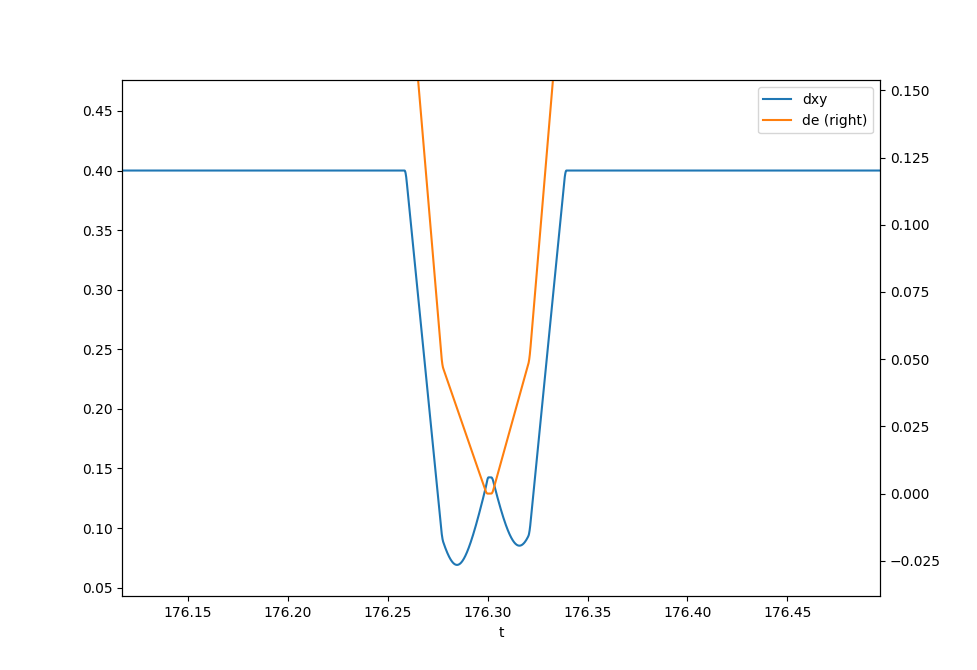

In [14]:
%matplotlib notebook
res = emulate(profile, accel_step=planner.accel_step, verbose=0)
res["x"] = res["X_x"] / planner.spm
res["y"] = res["Y_x"] / planner.spm
res["e"] = res["Z_x"] / planner.spme
sf = 5
res["dx"] = res["X_x"].diff().rolling(sf*2 + 1).mean().shift(-sf)
res["dy"] = res["Y_x"].diff().rolling(sf*2 + 1).mean().shift(-sf)
res["de"] = -res["Z_x"].diff().rolling(sf*2 + 1).mean().shift(-sf)
res["xv"] = res["X_v"] * 65536 / planner.k_vxy
res["yv"] = res["Y_v"] * 65536 / planner.k_vxy
res["ev"] = res["Z_v"] * 65536 / planner.k_ve
res["xa"] = res["X_a"] / planner.k_axy
res["ya"] = res["Y_a"] / planner.k_axy
res["ea"] = res["Z_a"] / planner.k_ae
res["v"] = np.linalg.norm([res["xv"], res["yv"]], axis=0)
res["dxy"] = np.linalg.norm([res["dx"], res["dy"]], axis=0)
#display(res[["t", "x", "y", "xv", "yv", "v", "xa", "ya"]])
#res.plot(x="x", y="y", style=None)
res.plot(x="t", y=["dxy", "de"],secondary_y=["de"])


<IPython.core.display.Javascript object>


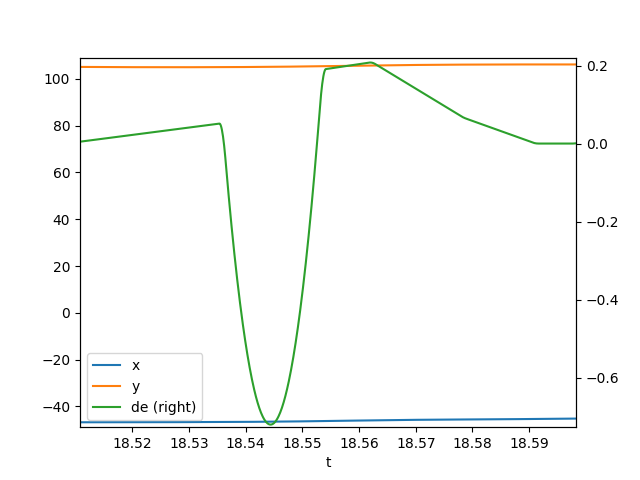

In [6]:
#res.plot(x="t", y=["xv", "yv", "v", "xa", "ya"], secondary_y=["xa", "ya"])

res.plot(x="t", y=["x", "y", "de"],secondary_y=["de"])
#res.plot(x="x", y="y", style="*")

In [ ]:
s = "   |"

for i in range(1, 20):
    s += " {:3d}".format(i)
    
print(s)
print("-" * len(s))

for i in range(1, 20):
    s = "{:2d} |".format(i)
    for o in range(1, 20):
        s += " {:3d}".format(i*o)
    print(s)